<a href="https://colab.research.google.com/github/tmaiecnj/tmaiecnj/blob/main/YOLO_NAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install roboflow -q

from roboflow import Roboflow
rf = Roboflow(api_key="AuDVSVQoG80A5Wom9G87")
project = rf.workspace("roboflow-58fyf").project("rock-paper-scissors-sxsw")
version = project.version(14)
dataset = version.download("yolov5")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to rock-paper-scissors-14 in yolov5pytorch:: 100%|██████████| 14682/14682 [00:01<00:00, 8537.29it/s] 


---

In [2]:
!pip install super_gradients -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.9/913.9 kB 39.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.8 MB/s e

In [3]:
from super_gradients.training import Trainer
from super_gradients.training.models import YoloNAS_M
from super_gradients.training.datasets import COCODetectionDataset
import super_gradients

The console stream is logged into /root/sg_logs/console.log


[2024-11-13 06:24:22] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-11-13 06:24:31] INFO - utils.py - NumExpr defaulting to 12 threads.


In [5]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [4]:
dataset_params = {
    'data_dir': dataset.location,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': sorted(project.classes.keys())
}

In [6]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 304/304 [00:00<00:00, 6222.61it/s]


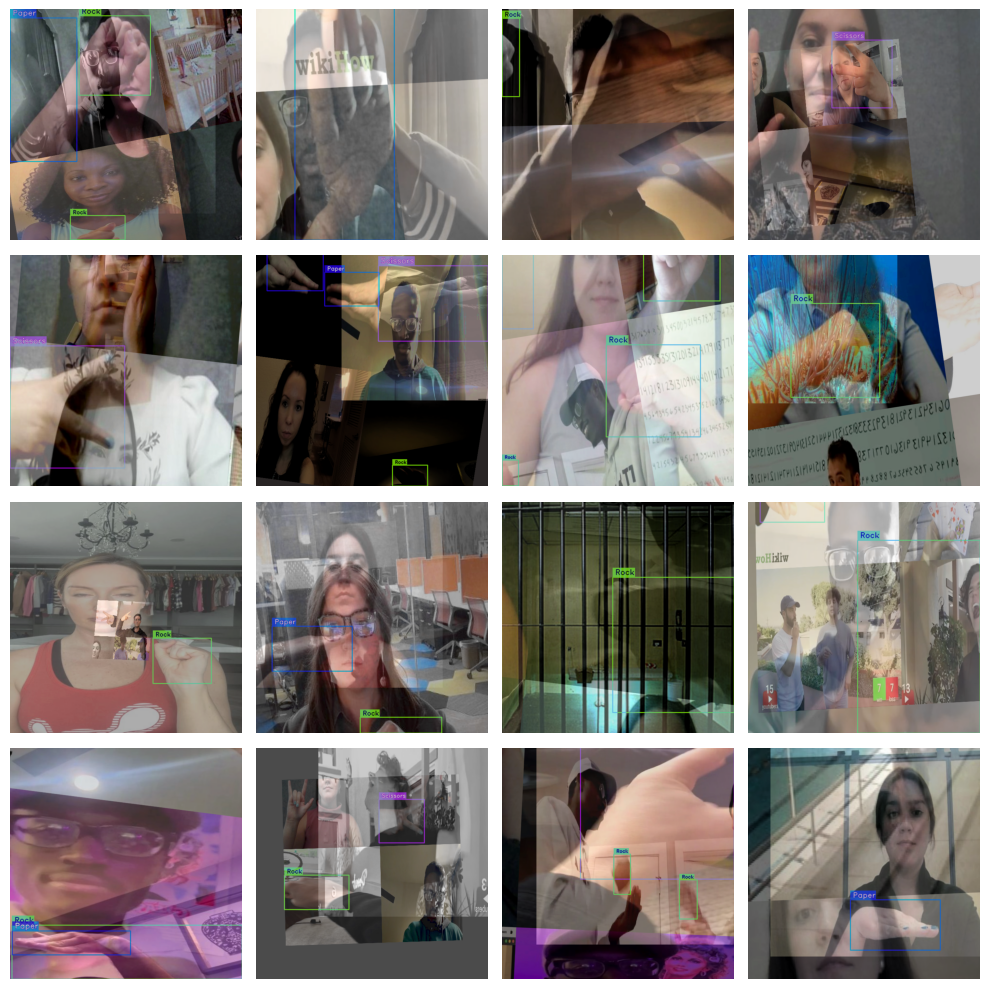

In [7]:
train_data.dataset.plot()

----

In [8]:
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050, DetectionMetrics_050_095
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

In [9]:
trainer = Trainer(experiment_name="model1_YOLONAS",
                  ckpt_root_dir="YOLONAS_checkpoints")

In [10]:
model = models.get('yolo_nas_m',
                   num_classes=len(dataset_params['classes']))

In [18]:
train_params = {
    "max_epochs": 150,
    "initial_lr": 0.001,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.0001},
    "train_batch_size": 32,
    "val_batch_size": 16,
    "mixed_precision": True,
    "lr_warmup_epochs": 3,
    "lr_warmup_initial_lr": 1e-5,
    "loss": PPYoloELoss(
    use_static_assigner=False,
    num_classes=len(dataset_params['classes']),
    reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            ))],
    "metric_to_watch": 'map@0.50_0.95'
}

In [19]:
## Train the model

trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-11-13 06:41:21] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20241113_064121_739659`
[2024-11-13 06:41:21] INFO - sg_trainer.py - Checkpoints directory: YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659


The console stream is now moved to YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/console_Nov13_06_41_21.txt


[2024-11-13 06:41:24] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            3939       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         246        (len(train_loader))
    - Gradient updates per epoch:   246        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_M  (51.13M parameters, 51.13M optimized)
    - Learning Rates and Weight Decays:
      - default: (51.13M parameters). LR: 0.001 (51.13M parameters) WD: 0.0001, (51.13M parameters)

[2024-11-13 06:41:24] INFO - sg_trainer.py - Started training for 150 epochs (0/149)

Train epoch 

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4217
│   ├── Ppyoloeloss/loss_iou = 0.6455
│   ├── Ppyoloeloss/loss_dfl = 0.7841
│   └── Ppyoloeloss/loss = 2.8513
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3727
    ├── Ppyoloeloss/loss_iou = 0.5229
    ├── Ppyoloeloss/loss_dfl = 0.6869
    ├── Ppyoloeloss/loss = 2.5825
    ├── Precision@0.50:0.95 = 0.0072
    ├── Recall@0.50:0.95 = 0.6037
    ├── Map@0.50:0.95 = 0.1649
    ├── F1@0.50:0.95 = 0.0141
    └── Best_score_threshold = 0.36



Validating epoch 1: 100%|██████████| 22/22 [00:04<00:00,  5.37it/s]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4111
│   │   ├── Epoch N-1      = 1.4217 (↘ -0.0106)
│   │   └── Best until now = 1.4217 (↘ -0.0106)
│   ├── Ppyoloeloss/loss_iou = 0.6422
│   │   ├── Epoch N-1      = 0.6455 (↘ -0.0033)
│   │   └── Best until now = 0.6455 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.7751
│   │   ├── Epoch N-1      = 0.7841 (↘ -0.009)
│   │   └── Best until now = 0.7841 (↘ -0.009)
│   └── Ppyoloeloss/loss = 2.8284
│       ├── Epoch N-1      = 2.8513 (↘ -0.0229)
│       └── Best until now = 2.8513 (↘ -0.0229)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3842
    │   ├── Epoch N-1      = 1.3727 (↗ 0.0115)
    │   └── Best until now = 1.3727 (↗ 0.0115)
    ├── Ppyoloeloss/loss_iou = 0.5268
    │   ├── Epoch N-1      = 0.5229 (↗ 0.0039)
    │   └── Best until now = 0.5229 (↗ 0.0039)
    ├── Ppyoloeloss/loss_dfl = 0.6822
    │   ├── Epoch N-1      = 0.6869 (↘ -0.0047)
    │   └── Best until now = 0.6869 (↘ -0.0047)
    ├── Ppyoloeloss/loss = 2

Validating epoch 2: 100%|██████████| 22/22 [00:03<00:00,  5.50it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4244
│   │   ├── Epoch N-1      = 1.4111 (↗ 0.0134)
│   │   └── Best until now = 1.4111 (↗ 0.0134)
│   ├── Ppyoloeloss/loss_iou = 0.6554
│   │   ├── Epoch N-1      = 0.6422 (↗ 0.0131)
│   │   └── Best until now = 0.6422 (↗ 0.0131)
│   ├── Ppyoloeloss/loss_dfl = 0.783
│   │   ├── Epoch N-1      = 0.7751 (↗ 0.0079)
│   │   └── Best until now = 0.7751 (↗ 0.0079)
│   └── Ppyoloeloss/loss = 2.8628
│       ├── Epoch N-1      = 2.8284 (↗ 0.0344)
│       └── Best until now = 2.8284 (↗ 0.0344)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3231
    │   ├── Epoch N-1      = 1.3842 (↘ -0.0611)
    │   └── Best until now = 1.3727 (↘ -0.0496)
    ├── Ppyoloeloss/loss_iou = 0.5413
    │   ├── Epoch N-1      = 0.5268 (↗ 0.0145)
    │   └── Best until now = 0.5229 (↗ 0.0184)
    ├── Ppyoloeloss/loss_dfl = 0.7014
    │   ├── Epoch N-1      = 0.6822 (↗ 0.0192)
    │   └── Best until now = 0.6822 (↗ 0.0192)
    ├── Ppyoloeloss/loss = 2.5658
 

Validating epoch 3: 100%|██████████| 22/22 [00:03<00:00,  5.53it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4168
│   │   ├── Epoch N-1      = 1.4244 (↘ -0.0076)
│   │   └── Best until now = 1.4111 (↗ 0.0057)
│   ├── Ppyoloeloss/loss_iou = 0.6504
│   │   ├── Epoch N-1      = 0.6554 (↘ -0.005)
│   │   └── Best until now = 0.6422 (↗ 0.0081)
│   ├── Ppyoloeloss/loss_dfl = 0.7792
│   │   ├── Epoch N-1      = 0.783  (↘ -0.0037)
│   │   └── Best until now = 0.7751 (↗ 0.0042)
│   └── Ppyoloeloss/loss = 2.8464
│       ├── Epoch N-1      = 2.8628 (↘ -0.0163)
│       └── Best until now = 2.8284 (↗ 0.018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3177
    │   ├── Epoch N-1      = 1.3231 (↘ -0.0054)
    │   └── Best until now = 1.3231 (↘ -0.0054)
    ├── Ppyoloeloss/loss_iou = 0.5232
    │   ├── Epoch N-1      = 0.5413 (↘ -0.0181)
    │   └── Best until now = 0.5229 (↗ 0.0004)
    ├── Ppyoloeloss/loss_dfl = 0.6795
    │   ├── Epoch N-1      = 0.7014 (↘ -0.0219)
    │   └── Best until now = 0.6822 (↘ -0.0027)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 4: 100%|██████████| 22/22 [00:04<00:00,  5.43it/s]
[2024-11-13 06:49:11] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 06:49:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.17041568458080292


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4118
│   │   ├── Epoch N-1      = 1.4168 (↘ -0.005)
│   │   └── Best until now = 1.4111 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_iou = 0.6458
│   │   ├── Epoch N-1      = 0.6504 (↘ -0.0045)
│   │   └── Best until now = 0.6422 (↗ 0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.7712
│   │   ├── Epoch N-1      = 0.7792 (↘ -0.0081)
│   │   └── Best until now = 0.7751 (↘ -0.0039)
│   └── Ppyoloeloss/loss = 2.8288
│       ├── Epoch N-1      = 2.8464 (↘ -0.0177)
│       └── Best until now = 2.8284 (↗ 0.0004)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3188
    │   ├── Epoch N-1      = 1.3177 (↗ 0.0011)
    │   └── Best until now = 1.3177 (↗ 0.0011)
    ├── Ppyoloeloss/loss_iou = 0.5136
    │   ├── Epoch N-1      = 0.5232 (↘ -0.0097)
    │   └── Best until now = 0.5229 (↘ -0.0093)
    ├── Ppyoloeloss/loss_dfl = 0.6782
    │   ├── Epoch N-1      = 0.6795 (↘ -0.0013)
    │   └── Best until now = 0.6795 (↘ -0.0013)
    ├── Ppyoloeloss/loss = 2

Validating epoch 5: 100%|██████████| 22/22 [00:04<00:00,  5.32it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3952
│   │   ├── Epoch N-1      = 1.4118 (↘ -0.0166)
│   │   └── Best until now = 1.4111 (↘ -0.0159)
│   ├── Ppyoloeloss/loss_iou = 0.6376
│   │   ├── Epoch N-1      = 0.6458 (↘ -0.0083)
│   │   └── Best until now = 0.6422 (↘ -0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.76
│   │   ├── Epoch N-1      = 0.7712 (↘ -0.0112)
│   │   └── Best until now = 0.7712 (↘ -0.0112)
│   └── Ppyoloeloss/loss = 2.7928
│       ├── Epoch N-1      = 2.8288 (↘ -0.036)
│       └── Best until now = 2.8284 (↘ -0.0356)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4165
    │   ├── Epoch N-1      = 1.3188 (↗ 0.0977)
    │   └── Best until now = 1.3177 (↗ 0.0988)
    ├── Ppyoloeloss/loss_iou = 0.5174
    │   ├── Epoch N-1      = 0.5136 (↗ 0.0038)
    │   └── Best until now = 0.5136 (↗ 0.0038)
    ├── Ppyoloeloss/loss_dfl = 0.675
    │   ├── Epoch N-1      = 0.6782 (↘ -0.0032)
    │   └── Best until now = 0.6782 (↘ -0.0032)
    ├── Ppyoloeloss/loss = 2.6

Validating epoch 6: 100%|██████████| 22/22 [00:04<00:00,  5.38it/s]
[2024-11-13 06:52:28] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 06:52:28] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.17891760170459747


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3776
│   │   ├── Epoch N-1      = 1.3952 (↘ -0.0176)
│   │   └── Best until now = 1.3952 (↘ -0.0176)
│   ├── Ppyoloeloss/loss_iou = 0.6295
│   │   ├── Epoch N-1      = 0.6376 (↘ -0.0081)
│   │   └── Best until now = 0.6376 (↘ -0.0081)
│   ├── Ppyoloeloss/loss_dfl = 0.7525
│   │   ├── Epoch N-1      = 0.76   (↘ -0.0075)
│   │   └── Best until now = 0.76   (↘ -0.0075)
│   └── Ppyoloeloss/loss = 2.7596
│       ├── Epoch N-1      = 2.7928 (↘ -0.0332)
│       └── Best until now = 2.7928 (↘ -0.0332)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2623
    │   ├── Epoch N-1      = 1.4165 (↘ -0.1542)
    │   └── Best until now = 1.3177 (↘ -0.0554)
    ├── Ppyoloeloss/loss_iou = 0.5012
    │   ├── Epoch N-1      = 0.5174 (↘ -0.0162)
    │   └── Best until now = 0.5136 (↘ -0.0124)
    ├── Ppyoloeloss/loss_dfl = 0.6577
    │   ├── Epoch N-1      = 0.675  (↘ -0.0173)
    │   └── Best until now = 0.675  (↘ -0.0173)
    ├── Ppyoloeloss/lo

Validating epoch 7: 100%|██████████| 22/22 [00:04<00:00,  5.39it/s]
[2024-11-13 06:54:05] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 06:54:05] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.18964625895023346


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3656
│   │   ├── Epoch N-1      = 1.3776 (↘ -0.012)
│   │   └── Best until now = 1.3776 (↘ -0.012)
│   ├── Ppyoloeloss/loss_iou = 0.6245
│   │   ├── Epoch N-1      = 0.6295 (↘ -0.005)
│   │   └── Best until now = 0.6295 (↘ -0.005)
│   ├── Ppyoloeloss/loss_dfl = 0.7395
│   │   ├── Epoch N-1      = 0.7525 (↘ -0.013)
│   │   └── Best until now = 0.7525 (↘ -0.013)
│   └── Ppyoloeloss/loss = 2.7296
│       ├── Epoch N-1      = 2.7596 (↘ -0.03)
│       └── Best until now = 2.7596 (↘ -0.03)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5163
    │   ├── Epoch N-1      = 1.2623 (↗ 0.2539)
    │   └── Best until now = 1.2623 (↗ 0.2539)
    ├── Ppyoloeloss/loss_iou = 0.5328
    │   ├── Epoch N-1      = 0.5012 (↗ 0.0316)
    │   └── Best until now = 0.5012 (↗ 0.0316)
    ├── Ppyoloeloss/loss_dfl = 0.6905
    │   ├── Epoch N-1      = 0.6577 (↗ 0.0328)
    │   └── Best until now = 0.6577 (↗ 0.0328)
    ├── Ppyoloeloss/loss = 2.7395
    

Validating epoch 8: 100%|██████████| 22/22 [00:04<00:00,  5.44it/s]
[2024-11-13 06:55:45] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 06:55:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.21495287120342255


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3704
│   │   ├── Epoch N-1      = 1.3656 (↗ 0.0048)
│   │   └── Best until now = 1.3656 (↗ 0.0048)
│   ├── Ppyoloeloss/loss_iou = 0.6123
│   │   ├── Epoch N-1      = 0.6245 (↘ -0.0122)
│   │   └── Best until now = 0.6245 (↘ -0.0122)
│   ├── Ppyoloeloss/loss_dfl = 0.7342
│   │   ├── Epoch N-1      = 0.7395 (↘ -0.0053)
│   │   └── Best until now = 0.7395 (↘ -0.0053)
│   └── Ppyoloeloss/loss = 2.7169
│       ├── Epoch N-1      = 2.7296 (↘ -0.0127)
│       └── Best until now = 2.7296 (↘ -0.0127)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3058
    │   ├── Epoch N-1      = 1.5163 (↘ -0.2105)
    │   └── Best until now = 1.2623 (↗ 0.0434)
    ├── Ppyoloeloss/loss_iou = 0.506
    │   ├── Epoch N-1      = 0.5328 (↘ -0.0268)
    │   └── Best until now = 0.5012 (↗ 0.0048)
    ├── Ppyoloeloss/loss_dfl = 0.6428
    │   ├── Epoch N-1      = 0.6905 (↘ -0.0477)
    │   └── Best until now = 0.6577 (↘ -0.0149)
    ├── Ppyoloeloss/loss = 

Validating epoch 9: 100%|██████████| 22/22 [00:04<00:00,  5.44it/s]
[2024-11-13 06:57:26] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 06:57:26] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.21896308660507202


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3508
│   │   ├── Epoch N-1      = 1.3704 (↘ -0.0196)
│   │   └── Best until now = 1.3656 (↘ -0.0148)
│   ├── Ppyoloeloss/loss_iou = 0.6071
│   │   ├── Epoch N-1      = 0.6123 (↘ -0.0052)
│   │   └── Best until now = 0.6123 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.725
│   │   ├── Epoch N-1      = 0.7342 (↘ -0.0092)
│   │   └── Best until now = 0.7342 (↘ -0.0092)
│   └── Ppyoloeloss/loss = 2.6829
│       ├── Epoch N-1      = 2.7169 (↘ -0.034)
│       └── Best until now = 2.7169 (↘ -0.034)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2708
    │   ├── Epoch N-1      = 1.3058 (↘ -0.035)
    │   └── Best until now = 1.2623 (↗ 0.0084)
    ├── Ppyoloeloss/loss_iou = 0.5064
    │   ├── Epoch N-1      = 0.506  (↗ 0.0005)
    │   └── Best until now = 0.5012 (↗ 0.0052)
    ├── Ppyoloeloss/loss_dfl = 0.6523
    │   ├── Epoch N-1      = 0.6428 (↗ 0.0094)
    │   └── Best until now = 0.6428 (↗ 0.0094)
    ├── Ppyoloeloss/loss = 2.42

Validating epoch 10: 100%|██████████| 22/22 [00:04<00:00,  5.38it/s]
[2024-11-13 06:59:08] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 06:59:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.22211803495883942


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3355
│   │   ├── Epoch N-1      = 1.3508 (↘ -0.0153)
│   │   └── Best until now = 1.3508 (↘ -0.0153)
│   ├── Ppyoloeloss/loss_iou = 0.607
│   │   ├── Epoch N-1      = 0.6071 (↘ -1e-04)
│   │   └── Best until now = 0.6071 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.7257
│   │   ├── Epoch N-1      = 0.725  (↗ 0.0007)
│   │   └── Best until now = 0.725  (↗ 0.0007)
│   └── Ppyoloeloss/loss = 2.6682
│       ├── Epoch N-1      = 2.6829 (↘ -0.0146)
│       └── Best until now = 2.6829 (↘ -0.0146)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2238
    │   ├── Epoch N-1      = 1.2708 (↘ -0.047)
    │   └── Best until now = 1.2623 (↘ -0.0386)
    ├── Ppyoloeloss/loss_iou = 0.481
    │   ├── Epoch N-1      = 0.5064 (↘ -0.0255)
    │   └── Best until now = 0.5012 (↘ -0.0202)
    ├── Ppyoloeloss/loss_dfl = 0.6311
    │   ├── Epoch N-1      = 0.6523 (↘ -0.0212)
    │   └── Best until now = 0.6428 (↘ -0.0118)
    ├── Ppyoloeloss/loss = 2

Validating epoch 11: 100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3284
│   │   ├── Epoch N-1      = 1.3355 (↘ -0.0071)
│   │   └── Best until now = 1.3355 (↘ -0.0071)
│   ├── Ppyoloeloss/loss_iou = 0.6046
│   │   ├── Epoch N-1      = 0.607  (↘ -0.0024)
│   │   └── Best until now = 0.607  (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.718
│   │   ├── Epoch N-1      = 0.7257 (↘ -0.0077)
│   │   └── Best until now = 0.725  (↘ -0.007)
│   └── Ppyoloeloss/loss = 2.651
│       ├── Epoch N-1      = 2.6682 (↘ -0.0172)
│       └── Best until now = 2.6682 (↘ -0.0172)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3135
    │   ├── Epoch N-1      = 1.2238 (↗ 0.0897)
    │   └── Best until now = 1.2238 (↗ 0.0897)
    ├── Ppyoloeloss/loss_iou = 0.5043
    │   ├── Epoch N-1      = 0.481  (↗ 0.0233)
    │   └── Best until now = 0.481  (↗ 0.0233)
    ├── Ppyoloeloss/loss_dfl = 0.6402
    │   ├── Epoch N-1      = 0.6311 (↗ 0.0091)
    │   └── Best until now = 0.6311 (↗ 0.0091)
    ├── Ppyoloeloss/loss = 2.4

Validating epoch 12: 100%|██████████| 22/22 [00:04<00:00,  5.41it/s]
[2024-11-13 07:02:32] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:02:32] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2332400530576706


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3279
│   │   ├── Epoch N-1      = 1.3284 (↘ -0.0005)
│   │   └── Best until now = 1.3284 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_iou = 0.5919
│   │   ├── Epoch N-1      = 0.6046 (↘ -0.0127)
│   │   └── Best until now = 0.6046 (↘ -0.0127)
│   ├── Ppyoloeloss/loss_dfl = 0.7069
│   │   ├── Epoch N-1      = 0.718  (↘ -0.0111)
│   │   └── Best until now = 0.718  (↘ -0.0111)
│   └── Ppyoloeloss/loss = 2.6267
│       ├── Epoch N-1      = 2.651  (↘ -0.0243)
│       └── Best until now = 2.651  (↘ -0.0243)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2401
    │   ├── Epoch N-1      = 1.3135 (↘ -0.0734)
    │   └── Best until now = 1.2238 (↗ 0.0163)
    ├── Ppyoloeloss/loss_iou = 0.4668
    │   ├── Epoch N-1      = 0.5043 (↘ -0.0375)
    │   └── Best until now = 0.481  (↘ -0.0142)
    ├── Ppyoloeloss/loss_dfl = 0.6077
    │   ├── Epoch N-1      = 0.6402 (↘ -0.0324)
    │   └── Best until now = 0.6311 (↘ -0.0233)
    ├── Ppyoloeloss/lo

Validating epoch 13: 100%|██████████| 22/22 [00:04<00:00,  5.35it/s]
[2024-11-13 07:04:15] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:04:15] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2653818726539612


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.316
│   │   ├── Epoch N-1      = 1.3279 (↘ -0.0119)
│   │   └── Best until now = 1.3279 (↘ -0.0119)
│   ├── Ppyoloeloss/loss_iou = 0.5899
│   │   ├── Epoch N-1      = 0.5919 (↘ -0.002)
│   │   └── Best until now = 0.5919 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.7062
│   │   ├── Epoch N-1      = 0.7069 (↘ -0.0008)
│   │   └── Best until now = 0.7069 (↘ -0.0008)
│   └── Ppyoloeloss/loss = 2.6121
│       ├── Epoch N-1      = 2.6267 (↘ -0.0146)
│       └── Best until now = 2.6267 (↘ -0.0146)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4611
    │   ├── Epoch N-1      = 1.2401 (↗ 0.2211)
    │   └── Best until now = 1.2238 (↗ 0.2374)
    ├── Ppyoloeloss/loss_iou = 0.4636
    │   ├── Epoch N-1      = 0.4668 (↘ -0.0032)
    │   └── Best until now = 0.4668 (↘ -0.0032)
    ├── Ppyoloeloss/loss_dfl = 0.6151
    │   ├── Epoch N-1      = 0.6077 (↗ 0.0074)
    │   └── Best until now = 0.6077 (↗ 0.0074)
    ├── Ppyoloeloss/loss = 2

Validating epoch 14: 100%|██████████| 22/22 [00:04<00:00,  5.35it/s]
[2024-11-13 07:05:57] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:05:57] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2870258390903473


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2973
│   │   ├── Epoch N-1      = 1.316  (↘ -0.0187)
│   │   └── Best until now = 1.316  (↘ -0.0187)
│   ├── Ppyoloeloss/loss_iou = 0.5794
│   │   ├── Epoch N-1      = 0.5899 (↘ -0.0106)
│   │   └── Best until now = 0.5899 (↘ -0.0106)
│   ├── Ppyoloeloss/loss_dfl = 0.6931
│   │   ├── Epoch N-1      = 0.7062 (↘ -0.013)
│   │   └── Best until now = 0.7062 (↘ -0.013)
│   └── Ppyoloeloss/loss = 2.5698
│       ├── Epoch N-1      = 2.6121 (↘ -0.0423)
│       └── Best until now = 2.6121 (↘ -0.0423)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2039
    │   ├── Epoch N-1      = 1.4611 (↘ -0.2573)
    │   └── Best until now = 1.2238 (↘ -0.0199)
    ├── Ppyoloeloss/loss_iou = 0.4721
    │   ├── Epoch N-1      = 0.4636 (↗ 0.0085)
    │   └── Best until now = 0.4636 (↗ 0.0085)
    ├── Ppyoloeloss/loss_dfl = 0.6117
    │   ├── Epoch N-1      = 0.6151 (↘ -0.0034)
    │   └── Best until now = 0.6077 (↗ 0.004)
    ├── Ppyoloeloss/loss = 

Validating epoch 15: 100%|██████████| 22/22 [00:04<00:00,  5.43it/s]
[2024-11-13 07:07:38] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:07:38] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3168007731437683


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.295
│   │   ├── Epoch N-1      = 1.2973 (↘ -0.0023)
│   │   └── Best until now = 1.2973 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.5832
│   │   ├── Epoch N-1      = 0.5794 (↗ 0.0038)
│   │   └── Best until now = 0.5794 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.695
│   │   ├── Epoch N-1      = 0.6931 (↗ 0.0019)
│   │   └── Best until now = 0.6931 (↗ 0.0019)
│   └── Ppyoloeloss/loss = 2.5731
│       ├── Epoch N-1      = 2.5698 (↗ 0.0033)
│       └── Best until now = 2.5698 (↗ 0.0033)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1909
    │   ├── Epoch N-1      = 1.2039 (↘ -0.0129)
    │   └── Best until now = 1.2039 (↘ -0.0129)
    ├── Ppyoloeloss/loss_iou = 0.4607
    │   ├── Epoch N-1      = 0.4721 (↘ -0.0115)
    │   └── Best until now = 0.4636 (↘ -0.0029)
    ├── Ppyoloeloss/loss_dfl = 0.6071
    │   ├── Epoch N-1      = 0.6117 (↘ -0.0046)
    │   └── Best until now = 0.6077 (↘ -0.0006)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 16: 100%|██████████| 22/22 [00:04<00:00,  5.37it/s]
[2024-11-13 07:09:21] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:09:21] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.33713799715042114


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2729
│   │   ├── Epoch N-1      = 1.295  (↘ -0.0221)
│   │   └── Best until now = 1.295  (↘ -0.0221)
│   ├── Ppyoloeloss/loss_iou = 0.5782
│   │   ├── Epoch N-1      = 0.5832 (↘ -0.005)
│   │   └── Best until now = 0.5794 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.686
│   │   ├── Epoch N-1      = 0.695  (↘ -0.009)
│   │   └── Best until now = 0.6931 (↘ -0.0071)
│   └── Ppyoloeloss/loss = 2.5371
│       ├── Epoch N-1      = 2.5731 (↘ -0.036)
│       └── Best until now = 2.5698 (↘ -0.0327)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1522
    │   ├── Epoch N-1      = 1.1909 (↘ -0.0388)
    │   └── Best until now = 1.1909 (↘ -0.0388)
    ├── Ppyoloeloss/loss_iou = 0.4577
    │   ├── Epoch N-1      = 0.4607 (↘ -0.003)
    │   └── Best until now = 0.4607 (↘ -0.003)
    ├── Ppyoloeloss/loss_dfl = 0.5954
    │   ├── Epoch N-1      = 0.6071 (↘ -0.0117)
    │   └── Best until now = 0.6071 (↘ -0.0117)
    ├── Ppyoloeloss/loss = 

Validating epoch 17: 100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2809
│   │   ├── Epoch N-1      = 1.2729 (↗ 0.008)
│   │   └── Best until now = 1.2729 (↗ 0.008)
│   ├── Ppyoloeloss/loss_iou = 0.5759
│   │   ├── Epoch N-1      = 0.5782 (↘ -0.0023)
│   │   └── Best until now = 0.5782 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.6839
│   │   ├── Epoch N-1      = 0.686  (↘ -0.0022)
│   │   └── Best until now = 0.686  (↘ -0.0022)
│   └── Ppyoloeloss/loss = 2.5406
│       ├── Epoch N-1      = 2.5371 (↗ 0.0035)
│       └── Best until now = 2.5371 (↗ 0.0035)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1643
    │   ├── Epoch N-1      = 1.1522 (↗ 0.0121)
    │   └── Best until now = 1.1522 (↗ 0.0121)
    ├── Ppyoloeloss/loss_iou = 0.4434
    │   ├── Epoch N-1      = 0.4577 (↘ -0.0143)
    │   └── Best until now = 0.4577 (↘ -0.0143)
    ├── Ppyoloeloss/loss_dfl = 0.5864
    │   ├── Epoch N-1      = 0.5954 (↘ -0.009)
    │   └── Best until now = 0.5954 (↘ -0.009)
    ├── Ppyoloeloss/loss = 2.19

Validating epoch 18: 100%|██████████| 22/22 [00:04<00:00,  5.44it/s]
[2024-11-13 07:12:45] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:12:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.36319300532341003


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2624
│   │   ├── Epoch N-1      = 1.2809 (↘ -0.0185)
│   │   └── Best until now = 1.2729 (↘ -0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.5684
│   │   ├── Epoch N-1      = 0.5759 (↘ -0.0075)
│   │   └── Best until now = 0.5759 (↘ -0.0075)
│   ├── Ppyoloeloss/loss_dfl = 0.6749
│   │   ├── Epoch N-1      = 0.6839 (↘ -0.0089)
│   │   └── Best until now = 0.6839 (↘ -0.0089)
│   └── Ppyoloeloss/loss = 2.5056
│       ├── Epoch N-1      = 2.5406 (↘ -0.035)
│       └── Best until now = 2.5371 (↘ -0.0315)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1283
    │   ├── Epoch N-1      = 1.1643 (↘ -0.036)
    │   └── Best until now = 1.1522 (↘ -0.0239)
    ├── Ppyoloeloss/loss_iou = 0.4439
    │   ├── Epoch N-1      = 0.4434 (↗ 0.0005)
    │   └── Best until now = 0.4434 (↗ 0.0005)
    ├── Ppyoloeloss/loss_dfl = 0.5913
    │   ├── Epoch N-1      = 0.5864 (↗ 0.005)
    │   └── Best until now = 0.5864 (↗ 0.005)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 19: 100%|██████████| 22/22 [00:04<00:00,  5.28it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2529
│   │   ├── Epoch N-1      = 1.2624 (↘ -0.0094)
│   │   └── Best until now = 1.2624 (↘ -0.0094)
│   ├── Ppyoloeloss/loss_iou = 0.5621
│   │   ├── Epoch N-1      = 0.5684 (↘ -0.0063)
│   │   └── Best until now = 0.5684 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_dfl = 0.6688
│   │   ├── Epoch N-1      = 0.6749 (↘ -0.0062)
│   │   └── Best until now = 0.6749 (↘ -0.0062)
│   └── Ppyoloeloss/loss = 2.4838
│       ├── Epoch N-1      = 2.5056 (↘ -0.0218)
│       └── Best until now = 2.5056 (↘ -0.0218)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1071
    │   ├── Epoch N-1      = 1.1283 (↘ -0.0212)
    │   └── Best until now = 1.1283 (↘ -0.0212)
    ├── Ppyoloeloss/loss_iou = 0.449
    │   ├── Epoch N-1      = 0.4439 (↗ 0.005)
    │   └── Best until now = 0.4434 (↗ 0.0056)
    ├── Ppyoloeloss/loss_dfl = 0.5853
    │   ├── Epoch N-1      = 0.5913 (↘ -0.006)
    │   └── Best until now = 0.5864 (↘ -0.0011)
    ├── Ppyoloeloss/loss =

Validating epoch 20: 100%|██████████| 22/22 [00:04<00:00,  5.38it/s]
[2024-11-13 07:16:05] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:16:05] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.38330185413360596


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2565
│   │   ├── Epoch N-1      = 1.2529 (↗ 0.0036)
│   │   └── Best until now = 1.2529 (↗ 0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.5628
│   │   ├── Epoch N-1      = 0.5621 (↗ 0.0007)
│   │   └── Best until now = 0.5621 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.6651
│   │   ├── Epoch N-1      = 0.6688 (↘ -0.0037)
│   │   └── Best until now = 0.6688 (↘ -0.0037)
│   └── Ppyoloeloss/loss = 2.4844
│       ├── Epoch N-1      = 2.4838 (↗ 0.0006)
│       └── Best until now = 2.4838 (↗ 0.0006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1344
    │   ├── Epoch N-1      = 1.1071 (↗ 0.0273)
    │   └── Best until now = 1.1071 (↗ 0.0273)
    ├── Ppyoloeloss/loss_iou = 0.4425
    │   ├── Epoch N-1      = 0.449  (↘ -0.0064)
    │   └── Best until now = 0.4434 (↘ -0.0009)
    ├── Ppyoloeloss/loss_dfl = 0.5699
    │   ├── Epoch N-1      = 0.5853 (↘ -0.0154)
    │   └── Best until now = 0.5853 (↘ -0.0154)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 21: 100%|██████████| 22/22 [00:04<00:00,  5.41it/s]
[2024-11-13 07:17:45] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:17:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3924368619918823


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2474
│   │   ├── Epoch N-1      = 1.2565 (↘ -0.0091)
│   │   └── Best until now = 1.2529 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.5613
│   │   ├── Epoch N-1      = 0.5628 (↘ -0.0015)
│   │   └── Best until now = 0.5621 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.665
│   │   ├── Epoch N-1      = 0.6651 (↘ -1e-04)
│   │   └── Best until now = 0.6651 (↘ -1e-04)
│   └── Ppyoloeloss/loss = 2.4737
│       ├── Epoch N-1      = 2.4844 (↘ -0.0107)
│       └── Best until now = 2.4838 (↘ -0.01)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1577
    │   ├── Epoch N-1      = 1.1344 (↗ 0.0233)
    │   └── Best until now = 1.1071 (↗ 0.0506)
    ├── Ppyoloeloss/loss_iou = 0.4358
    │   ├── Epoch N-1      = 0.4425 (↘ -0.0067)
    │   └── Best until now = 0.4425 (↘ -0.0067)
    ├── Ppyoloeloss/loss_dfl = 0.5672
    │   ├── Epoch N-1      = 0.5699 (↘ -0.0027)
    │   └── Best until now = 0.5699 (↘ -0.0027)
    ├── Ppyoloeloss/loss = 2

Validating epoch 22: 100%|██████████| 22/22 [00:03<00:00,  5.55it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2306
│   │   ├── Epoch N-1      = 1.2474 (↘ -0.0168)
│   │   └── Best until now = 1.2474 (↘ -0.0168)
│   ├── Ppyoloeloss/loss_iou = 0.5538
│   │   ├── Epoch N-1      = 0.5613 (↘ -0.0075)
│   │   └── Best until now = 0.5613 (↘ -0.0075)
│   ├── Ppyoloeloss/loss_dfl = 0.6527
│   │   ├── Epoch N-1      = 0.665  (↘ -0.0123)
│   │   └── Best until now = 0.665  (↘ -0.0123)
│   └── Ppyoloeloss/loss = 2.4372
│       ├── Epoch N-1      = 2.4737 (↘ -0.0366)
│       └── Best until now = 2.4737 (↘ -0.0366)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0934
    │   ├── Epoch N-1      = 1.1577 (↘ -0.0643)
    │   └── Best until now = 1.1071 (↘ -0.0137)
    ├── Ppyoloeloss/loss_iou = 0.4428
    │   ├── Epoch N-1      = 0.4358 (↗ 0.007)
    │   └── Best until now = 0.4358 (↗ 0.007)
    ├── Ppyoloeloss/loss_dfl = 0.5721
    │   ├── Epoch N-1      = 0.5672 (↗ 0.0049)
    │   └── Best until now = 0.5672 (↗ 0.0049)
    ├── Ppyoloeloss/loss = 

Validating epoch 23: 100%|██████████| 22/22 [00:04<00:00,  5.44it/s]
[2024-11-13 07:21:05] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:21:05] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.41041502356529236


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2286
│   │   ├── Epoch N-1      = 1.2306 (↘ -0.002)
│   │   └── Best until now = 1.2306 (↘ -0.002)
│   ├── Ppyoloeloss/loss_iou = 0.5538
│   │   ├── Epoch N-1      = 0.5538 (↘ -0.0)
│   │   └── Best until now = 0.5538 (↘ -0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.6524
│   │   ├── Epoch N-1      = 0.6527 (↘ -0.0003)
│   │   └── Best until now = 0.6527 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 2.4348
│       ├── Epoch N-1      = 2.4372 (↘ -0.0023)
│       └── Best until now = 2.4372 (↘ -0.0023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0806
    │   ├── Epoch N-1      = 1.0934 (↘ -0.0129)
    │   └── Best until now = 1.0934 (↘ -0.0129)
    ├── Ppyoloeloss/loss_iou = 0.4308
    │   ├── Epoch N-1      = 0.4428 (↘ -0.012)
    │   └── Best until now = 0.4358 (↘ -0.005)
    ├── Ppyoloeloss/loss_dfl = 0.5604
    │   ├── Epoch N-1      = 0.5721 (↘ -0.0117)
    │   └── Best until now = 0.5672 (↘ -0.0068)
    ├── Ppyoloeloss/loss = 2.07

Validating epoch 24: 100%|██████████| 22/22 [00:04<00:00,  5.37it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2175
│   │   ├── Epoch N-1      = 1.2286 (↘ -0.0111)
│   │   └── Best until now = 1.2286 (↘ -0.0111)
│   ├── Ppyoloeloss/loss_iou = 0.5476
│   │   ├── Epoch N-1      = 0.5538 (↘ -0.0062)
│   │   └── Best until now = 0.5538 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.6483
│   │   ├── Epoch N-1      = 0.6524 (↘ -0.0041)
│   │   └── Best until now = 0.6524 (↘ -0.0041)
│   └── Ppyoloeloss/loss = 2.4134
│       ├── Epoch N-1      = 2.4348 (↘ -0.0214)
│       └── Best until now = 2.4348 (↘ -0.0214)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2171
    │   ├── Epoch N-1      = 1.0806 (↗ 0.1365)
    │   └── Best until now = 1.0806 (↗ 0.1365)
    ├── Ppyoloeloss/loss_iou = 0.441
    │   ├── Epoch N-1      = 0.4308 (↗ 0.0102)
    │   └── Best until now = 0.4308 (↗ 0.0102)
    ├── Ppyoloeloss/loss_dfl = 0.5733
    │   ├── Epoch N-1      = 0.5604 (↗ 0.0129)
    │   └── Best until now = 0.5604 (↗ 0.0129)
    ├── Ppyoloeloss/loss = 2

Validating epoch 25: 100%|██████████| 22/22 [00:04<00:00,  5.28it/s]
[2024-11-13 07:24:24] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:24:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.42642632126808167


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2142
│   │   ├── Epoch N-1      = 1.2175 (↘ -0.0033)
│   │   └── Best until now = 1.2175 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_iou = 0.5495
│   │   ├── Epoch N-1      = 0.5476 (↗ 0.0019)
│   │   └── Best until now = 0.5476 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.6461
│   │   ├── Epoch N-1      = 0.6483 (↘ -0.0022)
│   │   └── Best until now = 0.6483 (↘ -0.0022)
│   └── Ppyoloeloss/loss = 2.4098
│       ├── Epoch N-1      = 2.4134 (↘ -0.0036)
│       └── Best until now = 2.4134 (↘ -0.0036)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9969
    │   ├── Epoch N-1      = 1.2171 (↘ -0.2202)
    │   └── Best until now = 1.0806 (↘ -0.0837)
    ├── Ppyoloeloss/loss_iou = 0.4215
    │   ├── Epoch N-1      = 0.441  (↘ -0.0195)
    │   └── Best until now = 0.4308 (↘ -0.0093)
    ├── Ppyoloeloss/loss_dfl = 0.5387
    │   ├── Epoch N-1      = 0.5733 (↘ -0.0346)
    │   └── Best until now = 0.5604 (↘ -0.0217)
    ├── Ppyoloeloss/los

Validating epoch 26: 100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2077
│   │   ├── Epoch N-1      = 1.2142 (↘ -0.0065)
│   │   └── Best until now = 1.2142 (↘ -0.0065)
│   ├── Ppyoloeloss/loss_iou = 0.5452
│   │   ├── Epoch N-1      = 0.5495 (↘ -0.0043)
│   │   └── Best until now = 0.5476 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.6384
│   │   ├── Epoch N-1      = 0.6461 (↘ -0.0076)
│   │   └── Best until now = 0.6461 (↘ -0.0076)
│   └── Ppyoloeloss/loss = 2.3914
│       ├── Epoch N-1      = 2.4098 (↘ -0.0184)
│       └── Best until now = 2.4098 (↘ -0.0184)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.064
    │   ├── Epoch N-1      = 0.9969 (↗ 0.0671)
    │   └── Best until now = 0.9969 (↗ 0.0671)
    ├── Ppyoloeloss/loss_iou = 0.4343
    │   ├── Epoch N-1      = 0.4215 (↗ 0.0128)
    │   └── Best until now = 0.4215 (↗ 0.0128)
    ├── Ppyoloeloss/loss_dfl = 0.5619
    │   ├── Epoch N-1      = 0.5387 (↗ 0.0232)
    │   └── Best until now = 0.5387 (↗ 0.0232)
    ├── Ppyoloeloss/loss = 2

Validating epoch 27: 100%|██████████| 22/22 [00:04<00:00,  5.41it/s]
[2024-11-13 07:27:45] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:27:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4444665312767029


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2073
│   │   ├── Epoch N-1      = 1.2077 (↘ -0.0004)
│   │   └── Best until now = 1.2077 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_iou = 0.5478
│   │   ├── Epoch N-1      = 0.5452 (↗ 0.0026)
│   │   └── Best until now = 0.5452 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.643
│   │   ├── Epoch N-1      = 0.6384 (↗ 0.0045)
│   │   └── Best until now = 0.6384 (↗ 0.0045)
│   └── Ppyoloeloss/loss = 2.3981
│       ├── Epoch N-1      = 2.3914 (↗ 0.0067)
│       └── Best until now = 2.3914 (↗ 0.0067)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0578
    │   ├── Epoch N-1      = 1.064  (↘ -0.0062)
    │   └── Best until now = 0.9969 (↗ 0.061)
    ├── Ppyoloeloss/loss_iou = 0.4268
    │   ├── Epoch N-1      = 0.4343 (↘ -0.0076)
    │   └── Best until now = 0.4215 (↗ 0.0053)
    ├── Ppyoloeloss/loss_dfl = 0.5598
    │   ├── Epoch N-1      = 0.5619 (↘ -0.0021)
    │   └── Best until now = 0.5387 (↗ 0.0211)
    ├── Ppyoloeloss/loss = 2.044

Validating epoch 28: 100%|██████████| 22/22 [00:04<00:00,  5.44it/s]
[2024-11-13 07:29:24] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:29:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4733200967311859


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1893
│   │   ├── Epoch N-1      = 1.2073 (↘ -0.018)
│   │   └── Best until now = 1.2073 (↘ -0.018)
│   ├── Ppyoloeloss/loss_iou = 0.5348
│   │   ├── Epoch N-1      = 0.5478 (↘ -0.013)
│   │   └── Best until now = 0.5452 (↘ -0.0104)
│   ├── Ppyoloeloss/loss_dfl = 0.633
│   │   ├── Epoch N-1      = 0.643  (↘ -0.0099)
│   │   └── Best until now = 0.6384 (↘ -0.0054)
│   └── Ppyoloeloss/loss = 2.3571
│       ├── Epoch N-1      = 2.3981 (↘ -0.041)
│       └── Best until now = 2.3914 (↘ -0.0343)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0174
    │   ├── Epoch N-1      = 1.0578 (↘ -0.0405)
    │   └── Best until now = 0.9969 (↗ 0.0205)
    ├── Ppyoloeloss/loss_iou = 0.4208
    │   ├── Epoch N-1      = 0.4268 (↘ -0.006)
    │   └── Best until now = 0.4215 (↘ -0.0007)
    ├── Ppyoloeloss/loss_dfl = 0.5524
    │   ├── Epoch N-1      = 0.5598 (↘ -0.0074)
    │   └── Best until now = 0.5387 (↗ 0.0136)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 29: 100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1871
│   │   ├── Epoch N-1      = 1.1893 (↘ -0.0022)
│   │   └── Best until now = 1.1893 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.5337
│   │   ├── Epoch N-1      = 0.5348 (↘ -0.0011)
│   │   └── Best until now = 0.5348 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.6299
│   │   ├── Epoch N-1      = 0.633  (↘ -0.0031)
│   │   └── Best until now = 0.633  (↘ -0.0031)
│   └── Ppyoloeloss/loss = 2.3507
│       ├── Epoch N-1      = 2.3571 (↘ -0.0064)
│       └── Best until now = 2.3571 (↘ -0.0064)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0244
    │   ├── Epoch N-1      = 1.0174 (↗ 0.007)
    │   └── Best until now = 0.9969 (↗ 0.0275)
    ├── Ppyoloeloss/loss_iou = 0.4109
    │   ├── Epoch N-1      = 0.4208 (↘ -0.0099)
    │   └── Best until now = 0.4208 (↘ -0.0099)
    ├── Ppyoloeloss/loss_dfl = 0.5436
    │   ├── Epoch N-1      = 0.5524 (↘ -0.0088)
    │   └── Best until now = 0.5387 (↗ 0.0049)
    ├── Ppyoloeloss/loss 

Validating epoch 30: 100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1944
│   │   ├── Epoch N-1      = 1.1871 (↗ 0.0073)
│   │   └── Best until now = 1.1871 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_iou = 0.5361
│   │   ├── Epoch N-1      = 0.5337 (↗ 0.0024)
│   │   └── Best until now = 0.5337 (↗ 0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.6327
│   │   ├── Epoch N-1      = 0.6299 (↗ 0.0028)
│   │   └── Best until now = 0.6299 (↗ 0.0028)
│   └── Ppyoloeloss/loss = 2.3632
│       ├── Epoch N-1      = 2.3507 (↗ 0.0125)
│       └── Best until now = 2.3507 (↗ 0.0125)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0364
    │   ├── Epoch N-1      = 1.0244 (↗ 0.012)
    │   └── Best until now = 0.9969 (↗ 0.0395)
    ├── Ppyoloeloss/loss_iou = 0.4097
    │   ├── Epoch N-1      = 0.4109 (↘ -0.0012)
    │   └── Best until now = 0.4109 (↘ -0.0012)
    ├── Ppyoloeloss/loss_dfl = 0.5452
    │   ├── Epoch N-1      = 0.5436 (↗ 0.0015)
    │   └── Best until now = 0.5387 (↗ 0.0064)
    ├── Ppyoloeloss/loss = 1.9913


Validating epoch 31: 100%|██████████| 22/22 [00:04<00:00,  5.43it/s]
[2024-11-13 07:34:24] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:34:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.49820759892463684


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.173
│   │   ├── Epoch N-1      = 1.1944 (↘ -0.0214)
│   │   └── Best until now = 1.1871 (↘ -0.0141)
│   ├── Ppyoloeloss/loss_iou = 0.5347
│   │   ├── Epoch N-1      = 0.5361 (↘ -0.0014)
│   │   └── Best until now = 0.5337 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.627
│   │   ├── Epoch N-1      = 0.6327 (↘ -0.0058)
│   │   └── Best until now = 0.6299 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 2.3347
│       ├── Epoch N-1      = 2.3632 (↘ -0.0285)
│       └── Best until now = 2.3507 (↘ -0.016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9772
    │   ├── Epoch N-1      = 1.0364 (↘ -0.0592)
    │   └── Best until now = 0.9969 (↘ -0.0197)
    ├── Ppyoloeloss/loss_iou = 0.401
    │   ├── Epoch N-1      = 0.4097 (↘ -0.0087)
    │   └── Best until now = 0.4097 (↘ -0.0087)
    ├── Ppyoloeloss/loss_dfl = 0.5304
    │   ├── Epoch N-1      = 0.5452 (↘ -0.0147)
    │   └── Best until now = 0.5387 (↘ -0.0083)
    ├── Ppyoloeloss/loss = 

Validating epoch 32: 100%|██████████| 22/22 [00:04<00:00,  5.45it/s]
[2024-11-13 07:36:06] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:36:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5057593584060669


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1729
│   │   ├── Epoch N-1      = 1.173  (↘ -1e-04)
│   │   └── Best until now = 1.173  (↘ -1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.535
│   │   ├── Epoch N-1      = 0.5347 (↗ 0.0003)
│   │   └── Best until now = 0.5337 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.6275
│   │   ├── Epoch N-1      = 0.627  (↗ 0.0005)
│   │   └── Best until now = 0.627  (↗ 0.0005)
│   └── Ppyoloeloss/loss = 2.3354
│       ├── Epoch N-1      = 2.3347 (↗ 0.0007)
│       └── Best until now = 2.3347 (↗ 0.0007)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9507
    │   ├── Epoch N-1      = 0.9772 (↘ -0.0265)
    │   └── Best until now = 0.9772 (↘ -0.0265)
    ├── Ppyoloeloss/loss_iou = 0.3944
    │   ├── Epoch N-1      = 0.401  (↘ -0.0065)
    │   └── Best until now = 0.401  (↘ -0.0065)
    ├── Ppyoloeloss/loss_dfl = 0.5257
    │   ├── Epoch N-1      = 0.5304 (↘ -0.0048)
    │   └── Best until now = 0.5304 (↘ -0.0048)
    ├── Ppyoloeloss/loss = 1.8

Validating epoch 33: 100%|██████████| 22/22 [00:03<00:00,  5.55it/s]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.163
│   │   ├── Epoch N-1      = 1.1729 (↘ -0.0099)
│   │   └── Best until now = 1.1729 (↘ -0.0099)
│   ├── Ppyoloeloss/loss_iou = 0.5334
│   │   ├── Epoch N-1      = 0.535  (↘ -0.0016)
│   │   └── Best until now = 0.5337 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.623
│   │   ├── Epoch N-1      = 0.6275 (↘ -0.0045)
│   │   └── Best until now = 0.627  (↘ -0.0039)
│   └── Ppyoloeloss/loss = 2.3194
│       ├── Epoch N-1      = 2.3354 (↘ -0.016)
│       └── Best until now = 2.3347 (↘ -0.0153)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0632
    │   ├── Epoch N-1      = 0.9507 (↗ 0.1125)
    │   └── Best until now = 0.9507 (↗ 0.1125)
    ├── Ppyoloeloss/loss_iou = 0.4206
    │   ├── Epoch N-1      = 0.3944 (↗ 0.0262)
    │   └── Best until now = 0.3944 (↗ 0.0262)
    ├── Ppyoloeloss/loss_dfl = 0.5436
    │   ├── Epoch N-1      = 0.5257 (↗ 0.0179)
    │   └── Best until now = 0.5257 (↗ 0.0179)
    ├── Ppyoloeloss/loss = 2.0

Validating epoch 34: 100%|██████████| 22/22 [00:04<00:00,  5.35it/s]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1548
│   │   ├── Epoch N-1      = 1.163  (↘ -0.0082)
│   │   └── Best until now = 1.163  (↘ -0.0082)
│   ├── Ppyoloeloss/loss_iou = 0.5256
│   │   ├── Epoch N-1      = 0.5334 (↘ -0.0078)
│   │   └── Best until now = 0.5334 (↘ -0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.6166
│   │   ├── Epoch N-1      = 0.623  (↘ -0.0064)
│   │   └── Best until now = 0.623  (↘ -0.0064)
│   └── Ppyoloeloss/loss = 2.2969
│       ├── Epoch N-1      = 2.3194 (↘ -0.0224)
│       └── Best until now = 2.3194 (↘ -0.0224)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9728
    │   ├── Epoch N-1      = 1.0632 (↘ -0.0904)
    │   └── Best until now = 0.9507 (↗ 0.0222)
    ├── Ppyoloeloss/loss_iou = 0.4102
    │   ├── Epoch N-1      = 0.4206 (↘ -0.0104)
    │   └── Best until now = 0.3944 (↗ 0.0158)
    ├── Ppyoloeloss/loss_dfl = 0.5273
    │   ├── Epoch N-1      = 0.5436 (↘ -0.0163)
    │   └── Best until now = 0.5257 (↗ 0.0016)
    ├── Ppyoloeloss/loss

Validating epoch 35: 100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1526
│   │   ├── Epoch N-1      = 1.1548 (↘ -0.0022)
│   │   └── Best until now = 1.1548 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.5249
│   │   ├── Epoch N-1      = 0.5256 (↘ -0.0007)
│   │   └── Best until now = 0.5256 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.6142
│   │   ├── Epoch N-1      = 0.6166 (↘ -0.0024)
│   │   └── Best until now = 0.6166 (↘ -0.0024)
│   └── Ppyoloeloss/loss = 2.2916
│       ├── Epoch N-1      = 2.2969 (↘ -0.0053)
│       └── Best until now = 2.2969 (↘ -0.0053)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0196
    │   ├── Epoch N-1      = 0.9728 (↗ 0.0467)
    │   └── Best until now = 0.9507 (↗ 0.0689)
    ├── Ppyoloeloss/loss_iou = 0.4114
    │   ├── Epoch N-1      = 0.4102 (↗ 0.0011)
    │   └── Best until now = 0.3944 (↗ 0.0169)
    ├── Ppyoloeloss/loss_dfl = 0.5391
    │   ├── Epoch N-1      = 0.5273 (↗ 0.0118)
    │   └── Best until now = 0.5257 (↗ 0.0134)
    ├── Ppyoloeloss/loss = 

Validating epoch 36: 100%|██████████| 22/22 [00:04<00:00,  5.50it/s]


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1515
│   │   ├── Epoch N-1      = 1.1526 (↘ -0.0011)
│   │   └── Best until now = 1.1526 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_iou = 0.5256
│   │   ├── Epoch N-1      = 0.5249 (↗ 0.0008)
│   │   └── Best until now = 0.5249 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.6127
│   │   ├── Epoch N-1      = 0.6142 (↘ -0.0015)
│   │   └── Best until now = 0.6142 (↘ -0.0015)
│   └── Ppyoloeloss/loss = 2.2898
│       ├── Epoch N-1      = 2.2916 (↘ -0.0018)
│       └── Best until now = 2.2916 (↘ -0.0018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9711
    │   ├── Epoch N-1      = 1.0196 (↘ -0.0485)
    │   └── Best until now = 0.9507 (↗ 0.0204)
    ├── Ppyoloeloss/loss_iou = 0.4079
    │   ├── Epoch N-1      = 0.4114 (↘ -0.0035)
    │   └── Best until now = 0.3944 (↗ 0.0135)
    ├── Ppyoloeloss/loss_dfl = 0.5157
    │   ├── Epoch N-1      = 0.5391 (↘ -0.0233)
    │   └── Best until now = 0.5257 (↘ -0.0099)
    ├── Ppyoloeloss/loss 

Validating epoch 37: 100%|██████████| 22/22 [00:04<00:00,  5.45it/s]


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1541
│   │   ├── Epoch N-1      = 1.1515 (↗ 0.0026)
│   │   └── Best until now = 1.1515 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_iou = 0.528
│   │   ├── Epoch N-1      = 0.5256 (↗ 0.0024)
│   │   └── Best until now = 0.5249 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.6094
│   │   ├── Epoch N-1      = 0.6127 (↘ -0.0033)
│   │   └── Best until now = 0.6127 (↘ -0.0033)
│   └── Ppyoloeloss/loss = 2.2915
│       ├── Epoch N-1      = 2.2898 (↗ 0.0017)
│       └── Best until now = 2.2898 (↗ 0.0017)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9472
    │   ├── Epoch N-1      = 0.9711 (↘ -0.0239)
    │   └── Best until now = 0.9507 (↘ -0.0035)
    ├── Ppyoloeloss/loss_iou = 0.3956
    │   ├── Epoch N-1      = 0.4079 (↘ -0.0123)
    │   └── Best until now = 0.3944 (↗ 0.0011)
    ├── Ppyoloeloss/loss_dfl = 0.5114
    │   ├── Epoch N-1      = 0.5157 (↘ -0.0043)
    │   └── Best until now = 0.5157 (↘ -0.0043)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 38: 100%|██████████| 22/22 [00:03<00:00,  5.50it/s]
[2024-11-13 07:46:02] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:46:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5475921630859375


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1488
│   │   ├── Epoch N-1      = 1.1541 (↘ -0.0054)
│   │   └── Best until now = 1.1515 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.5232
│   │   ├── Epoch N-1      = 0.528  (↘ -0.0048)
│   │   └── Best until now = 0.5249 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.6078
│   │   ├── Epoch N-1      = 0.6094 (↘ -0.0016)
│   │   └── Best until now = 0.6094 (↘ -0.0016)
│   └── Ppyoloeloss/loss = 2.2797
│       ├── Epoch N-1      = 2.2915 (↘ -0.0118)
│       └── Best until now = 2.2898 (↘ -0.0101)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8876
    │   ├── Epoch N-1      = 0.9472 (↘ -0.0596)
    │   └── Best until now = 0.9472 (↘ -0.0596)
    ├── Ppyoloeloss/loss_iou = 0.3993
    │   ├── Epoch N-1      = 0.3956 (↗ 0.0038)
    │   └── Best until now = 0.3944 (↗ 0.0049)
    ├── Ppyoloeloss/loss_dfl = 0.5111
    │   ├── Epoch N-1      = 0.5114 (↘ -0.0003)
    │   └── Best until now = 0.5114 (↘ -0.0003)
    ├── Ppyoloeloss/los

Validating epoch 39: 100%|██████████| 22/22 [00:03<00:00,  5.54it/s]


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1353
│   │   ├── Epoch N-1      = 1.1488 (↘ -0.0134)
│   │   └── Best until now = 1.1488 (↘ -0.0134)
│   ├── Ppyoloeloss/loss_iou = 0.518
│   │   ├── Epoch N-1      = 0.5232 (↘ -0.0052)
│   │   └── Best until now = 0.5232 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.6051
│   │   ├── Epoch N-1      = 0.6078 (↘ -0.0027)
│   │   └── Best until now = 0.6078 (↘ -0.0027)
│   └── Ppyoloeloss/loss = 2.2585
│       ├── Epoch N-1      = 2.2797 (↘ -0.0212)
│       └── Best until now = 2.2797 (↘ -0.0212)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9761
    │   ├── Epoch N-1      = 0.8876 (↗ 0.0885)
    │   └── Best until now = 0.8876 (↗ 0.0885)
    ├── Ppyoloeloss/loss_iou = 0.4219
    │   ├── Epoch N-1      = 0.3993 (↗ 0.0225)
    │   └── Best until now = 0.3944 (↗ 0.0275)
    ├── Ppyoloeloss/loss_dfl = 0.525
    │   ├── Epoch N-1      = 0.5111 (↗ 0.0139)
    │   └── Best until now = 0.5111 (↗ 0.0139)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 40: 100%|██████████| 22/22 [00:03<00:00,  5.59it/s]


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1329
│   │   ├── Epoch N-1      = 1.1353 (↘ -0.0024)
│   │   └── Best until now = 1.1353 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_iou = 0.5151
│   │   ├── Epoch N-1      = 0.518  (↘ -0.0029)
│   │   └── Best until now = 0.518  (↘ -0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.6027
│   │   ├── Epoch N-1      = 0.6051 (↘ -0.0025)
│   │   └── Best until now = 0.6051 (↘ -0.0025)
│   └── Ppyoloeloss/loss = 2.2507
│       ├── Epoch N-1      = 2.2585 (↘ -0.0077)
│       └── Best until now = 2.2585 (↘ -0.0077)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9492
    │   ├── Epoch N-1      = 0.9761 (↘ -0.0269)
    │   └── Best until now = 0.8876 (↗ 0.0617)
    ├── Ppyoloeloss/loss_iou = 0.4161
    │   ├── Epoch N-1      = 0.4219 (↘ -0.0058)
    │   └── Best until now = 0.3944 (↗ 0.0216)
    ├── Ppyoloeloss/loss_dfl = 0.5236
    │   ├── Epoch N-1      = 0.525  (↘ -0.0015)
    │   └── Best until now = 0.5111 (↗ 0.0125)
    ├── Ppyoloeloss/loss

Validating epoch 41: 100%|██████████| 22/22 [00:03<00:00,  5.60it/s]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1284
│   │   ├── Epoch N-1      = 1.1329 (↘ -0.0045)
│   │   └── Best until now = 1.1329 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_iou = 0.516
│   │   ├── Epoch N-1      = 0.5151 (↗ 0.0009)
│   │   └── Best until now = 0.5151 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.6002
│   │   ├── Epoch N-1      = 0.6027 (↘ -0.0025)
│   │   └── Best until now = 0.6027 (↘ -0.0025)
│   └── Ppyoloeloss/loss = 2.2445
│       ├── Epoch N-1      = 2.2507 (↘ -0.0062)
│       └── Best until now = 2.2507 (↘ -0.0062)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.974
    │   ├── Epoch N-1      = 0.9492 (↗ 0.0247)
    │   └── Best until now = 0.8876 (↗ 0.0864)
    ├── Ppyoloeloss/loss_iou = 0.4295
    │   ├── Epoch N-1      = 0.4161 (↗ 0.0134)
    │   └── Best until now = 0.3944 (↗ 0.0351)
    ├── Ppyoloeloss/loss_dfl = 0.5206
    │   ├── Epoch N-1      = 0.5236 (↘ -0.0029)
    │   └── Best until now = 0.5111 (↗ 0.0096)
    ├── Ppyoloeloss/loss = 1.9

Validating epoch 42: 100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1204
│   │   ├── Epoch N-1      = 1.1284 (↘ -0.008)
│   │   └── Best until now = 1.1284 (↘ -0.008)
│   ├── Ppyoloeloss/loss_iou = 0.5151
│   │   ├── Epoch N-1      = 0.516  (↘ -0.0009)
│   │   └── Best until now = 0.5151 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.5981
│   │   ├── Epoch N-1      = 0.6002 (↘ -0.002)
│   │   └── Best until now = 0.6002 (↘ -0.002)
│   └── Ppyoloeloss/loss = 2.2336
│       ├── Epoch N-1      = 2.2445 (↘ -0.0109)
│       └── Best until now = 2.2445 (↘ -0.0109)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9105
    │   ├── Epoch N-1      = 0.974  (↘ -0.0635)
    │   └── Best until now = 0.8876 (↗ 0.0229)
    ├── Ppyoloeloss/loss_iou = 0.3963
    │   ├── Epoch N-1      = 0.4295 (↘ -0.0332)
    │   └── Best until now = 0.3944 (↗ 0.0018)
    ├── Ppyoloeloss/loss_dfl = 0.5055
    │   ├── Epoch N-1      = 0.5206 (↘ -0.0151)
    │   └── Best until now = 0.5111 (↘ -0.0056)
    ├── Ppyoloeloss/loss = 1

Validating epoch 43: 100%|██████████| 22/22 [00:04<00:00,  5.34it/s]


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1123
│   │   ├── Epoch N-1      = 1.1204 (↘ -0.0082)
│   │   └── Best until now = 1.1204 (↘ -0.0082)
│   ├── Ppyoloeloss/loss_iou = 0.5082
│   │   ├── Epoch N-1      = 0.5151 (↘ -0.0068)
│   │   └── Best until now = 0.5151 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.587
│   │   ├── Epoch N-1      = 0.5981 (↘ -0.0111)
│   │   └── Best until now = 0.5981 (↘ -0.0111)
│   └── Ppyoloeloss/loss = 2.2075
│       ├── Epoch N-1      = 2.2336 (↘ -0.0261)
│       └── Best until now = 2.2336 (↘ -0.0261)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9314
    │   ├── Epoch N-1      = 0.9105 (↗ 0.0209)
    │   └── Best until now = 0.8876 (↗ 0.0438)
    ├── Ppyoloeloss/loss_iou = 0.3864
    │   ├── Epoch N-1      = 0.3963 (↘ -0.0099)
    │   └── Best until now = 0.3944 (↘ -0.0081)
    ├── Ppyoloeloss/loss_dfl = 0.4906
    │   ├── Epoch N-1      = 0.5055 (↘ -0.0149)
    │   └── Best until now = 0.5055 (↘ -0.0149)
    ├── Ppyoloeloss/loss

Validating epoch 44: 100%|██████████| 22/22 [00:03<00:00,  5.62it/s]


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1092
│   │   ├── Epoch N-1      = 1.1123 (↘ -0.0031)
│   │   └── Best until now = 1.1123 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.5129
│   │   ├── Epoch N-1      = 0.5082 (↗ 0.0047)
│   │   └── Best until now = 0.5082 (↗ 0.0047)
│   ├── Ppyoloeloss/loss_dfl = 0.5943
│   │   ├── Epoch N-1      = 0.587  (↗ 0.0072)
│   │   └── Best until now = 0.587  (↗ 0.0072)
│   └── Ppyoloeloss/loss = 2.2164
│       ├── Epoch N-1      = 2.2075 (↗ 0.0088)
│       └── Best until now = 2.2075 (↗ 0.0088)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9591
    │   ├── Epoch N-1      = 0.9314 (↗ 0.0277)
    │   └── Best until now = 0.8876 (↗ 0.0715)
    ├── Ppyoloeloss/loss_iou = 0.4167
    │   ├── Epoch N-1      = 0.3864 (↗ 0.0304)
    │   └── Best until now = 0.3864 (↗ 0.0304)
    ├── Ppyoloeloss/loss_dfl = 0.5151
    │   ├── Epoch N-1      = 0.4906 (↗ 0.0245)
    │   └── Best until now = 0.4906 (↗ 0.0245)
    ├── Ppyoloeloss/loss = 1.8909

Validating epoch 45: 100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1083
│   │   ├── Epoch N-1      = 1.1092 (↘ -0.0009)
│   │   └── Best until now = 1.1092 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_iou = 0.5068
│   │   ├── Epoch N-1      = 0.5129 (↘ -0.0061)
│   │   └── Best until now = 0.5082 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.5901
│   │   ├── Epoch N-1      = 0.5943 (↘ -0.0042)
│   │   └── Best until now = 0.587  (↗ 0.0031)
│   └── Ppyoloeloss/loss = 2.2051
│       ├── Epoch N-1      = 2.2164 (↘ -0.0112)
│       └── Best until now = 2.2075 (↘ -0.0024)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8903
    │   ├── Epoch N-1      = 0.9591 (↘ -0.0687)
    │   └── Best until now = 0.8876 (↗ 0.0028)
    ├── Ppyoloeloss/loss_iou = 0.3927
    │   ├── Epoch N-1      = 0.4167 (↘ -0.0241)
    │   └── Best until now = 0.3864 (↗ 0.0063)
    ├── Ppyoloeloss/loss_dfl = 0.5056
    │   ├── Epoch N-1      = 0.5151 (↘ -0.0095)
    │   └── Best until now = 0.4906 (↗ 0.015)
    ├── Ppyoloeloss/loss =

Validating epoch 46: 100%|██████████| 22/22 [00:03<00:00,  5.51it/s]
[2024-11-13 07:59:17] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 07:59:17] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.561022162437439


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1061
│   │   ├── Epoch N-1      = 1.1083 (↘ -0.0022)
│   │   └── Best until now = 1.1083 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.5089
│   │   ├── Epoch N-1      = 0.5068 (↗ 0.0022)
│   │   └── Best until now = 0.5068 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.5892
│   │   ├── Epoch N-1      = 0.5901 (↘ -0.0009)
│   │   └── Best until now = 0.587  (↗ 0.0021)
│   └── Ppyoloeloss/loss = 2.2042
│       ├── Epoch N-1      = 2.2051 (↘ -0.001)
│       └── Best until now = 2.2051 (↘ -0.001)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9163
    │   ├── Epoch N-1      = 0.8903 (↗ 0.0259)
    │   └── Best until now = 0.8876 (↗ 0.0287)
    ├── Ppyoloeloss/loss_iou = 0.3824
    │   ├── Epoch N-1      = 0.3927 (↘ -0.0103)
    │   └── Best until now = 0.3864 (↘ -0.004)
    ├── Ppyoloeloss/loss_dfl = 0.4912
    │   ├── Epoch N-1      = 0.5056 (↘ -0.0144)
    │   └── Best until now = 0.4906 (↗ 0.0007)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 47: 100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1011
│   │   ├── Epoch N-1      = 1.1061 (↘ -0.005)
│   │   └── Best until now = 1.1061 (↘ -0.005)
│   ├── Ppyoloeloss/loss_iou = 0.5055
│   │   ├── Epoch N-1      = 0.5089 (↘ -0.0034)
│   │   └── Best until now = 0.5068 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.5866
│   │   ├── Epoch N-1      = 0.5892 (↘ -0.0025)
│   │   └── Best until now = 0.587  (↘ -0.0004)
│   └── Ppyoloeloss/loss = 2.1932
│       ├── Epoch N-1      = 2.2042 (↘ -0.011)
│       └── Best until now = 2.2042 (↘ -0.011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9109
    │   ├── Epoch N-1      = 0.9163 (↘ -0.0054)
    │   └── Best until now = 0.8876 (↗ 0.0233)
    ├── Ppyoloeloss/loss_iou = 0.3965
    │   ├── Epoch N-1      = 0.3824 (↗ 0.0142)
    │   └── Best until now = 0.3824 (↗ 0.0142)
    ├── Ppyoloeloss/loss_dfl = 0.5021
    │   ├── Epoch N-1      = 0.4912 (↗ 0.0109)
    │   └── Best until now = 0.4906 (↗ 0.0115)
    ├── Ppyoloeloss/loss = 1.8

Validating epoch 48: 100%|██████████| 22/22 [00:03<00:00,  5.54it/s]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0922
│   │   ├── Epoch N-1      = 1.1011 (↘ -0.0089)
│   │   └── Best until now = 1.1011 (↘ -0.0089)
│   ├── Ppyoloeloss/loss_iou = 0.5039
│   │   ├── Epoch N-1      = 0.5055 (↘ -0.0015)
│   │   └── Best until now = 0.5055 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.5833
│   │   ├── Epoch N-1      = 0.5866 (↘ -0.0033)
│   │   └── Best until now = 0.5866 (↘ -0.0033)
│   └── Ppyoloeloss/loss = 2.1795
│       ├── Epoch N-1      = 2.1932 (↘ -0.0137)
│       └── Best until now = 2.1932 (↘ -0.0137)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9003
    │   ├── Epoch N-1      = 0.9109 (↘ -0.0106)
    │   └── Best until now = 0.8876 (↗ 0.0128)
    ├── Ppyoloeloss/loss_iou = 0.4082
    │   ├── Epoch N-1      = 0.3965 (↗ 0.0117)
    │   └── Best until now = 0.3824 (↗ 0.0258)
    ├── Ppyoloeloss/loss_dfl = 0.5068
    │   ├── Epoch N-1      = 0.5021 (↗ 0.0047)
    │   └── Best until now = 0.4906 (↗ 0.0163)
    ├── Ppyoloeloss/loss =

Validating epoch 49: 100%|██████████| 22/22 [00:03<00:00,  5.50it/s]
[2024-11-13 08:04:17] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 08:04:17] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5652459859848022


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0975
│   │   ├── Epoch N-1      = 1.0922 (↗ 0.0053)
│   │   └── Best until now = 1.0922 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.5012
│   │   ├── Epoch N-1      = 0.5039 (↘ -0.0027)
│   │   └── Best until now = 0.5039 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.5788
│   │   ├── Epoch N-1      = 0.5833 (↘ -0.0045)
│   │   └── Best until now = 0.5833 (↘ -0.0045)
│   └── Ppyoloeloss/loss = 2.1775
│       ├── Epoch N-1      = 2.1795 (↘ -0.0019)
│       └── Best until now = 2.1795 (↘ -0.0019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9014
    │   ├── Epoch N-1      = 0.9003 (↗ 0.001)
    │   └── Best until now = 0.8876 (↗ 0.0138)
    ├── Ppyoloeloss/loss_iou = 0.3793
    │   ├── Epoch N-1      = 0.4082 (↘ -0.0289)
    │   └── Best until now = 0.3824 (↘ -0.003)
    ├── Ppyoloeloss/loss_dfl = 0.4927
    │   ├── Epoch N-1      = 0.5068 (↘ -0.0142)
    │   └── Best until now = 0.4906 (↗ 0.0021)
    ├── Ppyoloeloss/loss = 1

Validating epoch 50: 100%|██████████| 22/22 [00:03<00:00,  5.58it/s]
[2024-11-13 08:06:00] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 08:06:00] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5717667937278748


SUMMARY OF EPOCH 50
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0899
│   │   ├── Epoch N-1      = 1.0975 (↘ -0.0076)
│   │   └── Best until now = 1.0922 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.5011
│   │   ├── Epoch N-1      = 0.5012 (↘ -1e-04)
│   │   └── Best until now = 0.5012 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.5757
│   │   ├── Epoch N-1      = 0.5788 (↘ -0.0031)
│   │   └── Best until now = 0.5788 (↘ -0.0031)
│   └── Ppyoloeloss/loss = 2.1667
│       ├── Epoch N-1      = 2.1775 (↘ -0.0108)
│       └── Best until now = 2.1775 (↘ -0.0108)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8793
    │   ├── Epoch N-1      = 0.9014 (↘ -0.0221)
    │   └── Best until now = 0.8876 (↘ -0.0083)
    ├── Ppyoloeloss/loss_iou = 0.3939
    │   ├── Epoch N-1      = 0.3793 (↗ 0.0145)
    │   └── Best until now = 0.3793 (↗ 0.0145)
    ├── Ppyoloeloss/loss_dfl = 0.4949
    │   ├── Epoch N-1      = 0.4927 (↗ 0.0022)
    │   └── Best until now = 0.4906 (↗ 0.0043)
    ├── Ppyoloeloss/loss = 

Validating epoch 51: 100%|██████████| 22/22 [00:04<00:00,  5.44it/s]
[2024-11-13 08:07:41] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 08:07:41] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5728238224983215


SUMMARY OF EPOCH 51
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0858
│   │   ├── Epoch N-1      = 1.0899 (↘ -0.004)
│   │   └── Best until now = 1.0899 (↘ -0.004)
│   ├── Ppyoloeloss/loss_iou = 0.502
│   │   ├── Epoch N-1      = 0.5011 (↗ 0.0009)
│   │   └── Best until now = 0.5011 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.5798
│   │   ├── Epoch N-1      = 0.5757 (↗ 0.004)
│   │   └── Best until now = 0.5757 (↗ 0.004)
│   └── Ppyoloeloss/loss = 2.1676
│       ├── Epoch N-1      = 2.1667 (↗ 0.0009)
│       └── Best until now = 2.1667 (↗ 0.0009)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8615
    │   ├── Epoch N-1      = 0.8793 (↘ -0.0178)
    │   └── Best until now = 0.8793 (↘ -0.0178)
    ├── Ppyoloeloss/loss_iou = 0.3892
    │   ├── Epoch N-1      = 0.3939 (↘ -0.0046)
    │   └── Best until now = 0.3793 (↗ 0.0099)
    ├── Ppyoloeloss/loss_dfl = 0.4921
    │   ├── Epoch N-1      = 0.4949 (↘ -0.0028)
    │   └── Best until now = 0.4906 (↗ 0.0015)
    ├── Ppyoloeloss/loss = 1.7428


Validating epoch 52: 100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


SUMMARY OF EPOCH 52
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0803
│   │   ├── Epoch N-1      = 1.0858 (↘ -0.0056)
│   │   └── Best until now = 1.0858 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_iou = 0.4973
│   │   ├── Epoch N-1      = 0.502  (↘ -0.0047)
│   │   └── Best until now = 0.5011 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.5732
│   │   ├── Epoch N-1      = 0.5798 (↘ -0.0066)
│   │   └── Best until now = 0.5757 (↘ -0.0026)
│   └── Ppyoloeloss/loss = 2.1508
│       ├── Epoch N-1      = 2.1676 (↘ -0.0168)
│       └── Best until now = 2.1667 (↘ -0.016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8958
    │   ├── Epoch N-1      = 0.8615 (↗ 0.0344)
    │   └── Best until now = 0.8615 (↗ 0.0344)
    ├── Ppyoloeloss/loss_iou = 0.4238
    │   ├── Epoch N-1      = 0.3892 (↗ 0.0346)
    │   └── Best until now = 0.3793 (↗ 0.0445)
    ├── Ppyoloeloss/loss_dfl = 0.5159
    │   ├── Epoch N-1      = 0.4921 (↗ 0.0238)
    │   └── Best until now = 0.4906 (↗ 0.0253)
    ├── Ppyoloeloss/loss = 1

Validating epoch 53: 100%|██████████| 22/22 [00:03<00:00,  5.57it/s]
[2024-11-13 08:11:02] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 08:11:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.587624192237854


SUMMARY OF EPOCH 53
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0754
│   │   ├── Epoch N-1      = 1.0803 (↘ -0.0049)
│   │   └── Best until now = 1.0803 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.4983
│   │   ├── Epoch N-1      = 0.4973 (↗ 0.001)
│   │   └── Best until now = 0.4973 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.5772
│   │   ├── Epoch N-1      = 0.5732 (↗ 0.004)
│   │   └── Best until now = 0.5732 (↗ 0.004)
│   └── Ppyoloeloss/loss = 2.1508
│       ├── Epoch N-1      = 2.1508 (↗ 0.0)
│       └── Best until now = 2.1508 (↗ 0.0)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8808
    │   ├── Epoch N-1      = 0.8958 (↘ -0.015)
    │   └── Best until now = 0.8615 (↗ 0.0193)
    ├── Ppyoloeloss/loss_iou = 0.3749
    │   ├── Epoch N-1      = 0.4238 (↘ -0.0489)
    │   └── Best until now = 0.3793 (↘ -0.0044)
    ├── Ppyoloeloss/loss_dfl = 0.4789
    │   ├── Epoch N-1      = 0.5159 (↘ -0.037)
    │   └── Best until now = 0.4906 (↘ -0.0117)
    ├── Ppyoloeloss/loss = 1.7346
    │ 

Validating epoch 54: 100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


SUMMARY OF EPOCH 54
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0808
│   │   ├── Epoch N-1      = 1.0754 (↗ 0.0054)
│   │   └── Best until now = 1.0754 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.5024
│   │   ├── Epoch N-1      = 0.4983 (↗ 0.0041)
│   │   └── Best until now = 0.4973 (↗ 0.0051)
│   ├── Ppyoloeloss/loss_dfl = 0.5784
│   │   ├── Epoch N-1      = 0.5772 (↗ 0.0013)
│   │   └── Best until now = 0.5732 (↗ 0.0053)
│   └── Ppyoloeloss/loss = 2.1617
│       ├── Epoch N-1      = 2.1508 (↗ 0.0109)
│       └── Best until now = 2.1508 (↗ 0.0109)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8787
    │   ├── Epoch N-1      = 0.8808 (↘ -0.0021)
    │   └── Best until now = 0.8615 (↗ 0.0173)
    ├── Ppyoloeloss/loss_iou = 0.3786
    │   ├── Epoch N-1      = 0.3749 (↗ 0.0037)
    │   └── Best until now = 0.3749 (↗ 0.0037)
    ├── Ppyoloeloss/loss_dfl = 0.4846
    │   ├── Epoch N-1      = 0.4789 (↗ 0.0057)
    │   └── Best until now = 0.4789 (↗ 0.0057)
    ├── Ppyoloeloss/loss = 1.7419


Validating epoch 55: 100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


SUMMARY OF EPOCH 55
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0767
│   │   ├── Epoch N-1      = 1.0808 (↘ -0.0041)
│   │   └── Best until now = 1.0754 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_iou = 0.4952
│   │   ├── Epoch N-1      = 0.5024 (↘ -0.0072)
│   │   └── Best until now = 0.4973 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.5708
│   │   ├── Epoch N-1      = 0.5784 (↘ -0.0076)
│   │   └── Best until now = 0.5732 (↘ -0.0024)
│   └── Ppyoloeloss/loss = 2.1427
│       ├── Epoch N-1      = 2.1617 (↘ -0.0189)
│       └── Best until now = 2.1508 (↘ -0.008)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9173
    │   ├── Epoch N-1      = 0.8787 (↗ 0.0385)
    │   └── Best until now = 0.8615 (↗ 0.0558)
    ├── Ppyoloeloss/loss_iou = 0.4062
    │   ├── Epoch N-1      = 0.3786 (↗ 0.0276)
    │   └── Best until now = 0.3749 (↗ 0.0313)
    ├── Ppyoloeloss/loss_dfl = 0.4998
    │   ├── Epoch N-1      = 0.4846 (↗ 0.0152)
    │   └── Best until now = 0.4789 (↗ 0.0209)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 56: 100%|██████████| 22/22 [00:04<00:00,  5.50it/s]
[2024-11-13 08:16:02] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 08:16:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5953360795974731


SUMMARY OF EPOCH 56
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0669
│   │   ├── Epoch N-1      = 1.0767 (↘ -0.0099)
│   │   └── Best until now = 1.0754 (↘ -0.0085)
│   ├── Ppyoloeloss/loss_iou = 0.5021
│   │   ├── Epoch N-1      = 0.4952 (↗ 0.0069)
│   │   └── Best until now = 0.4952 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_dfl = 0.5733
│   │   ├── Epoch N-1      = 0.5708 (↗ 0.0025)
│   │   └── Best until now = 0.5708 (↗ 0.0025)
│   └── Ppyoloeloss/loss = 2.1422
│       ├── Epoch N-1      = 2.1427 (↘ -0.0005)
│       └── Best until now = 2.1427 (↘ -0.0005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8431
    │   ├── Epoch N-1      = 0.9173 (↘ -0.0742)
    │   └── Best until now = 0.8615 (↘ -0.0184)
    ├── Ppyoloeloss/loss_iou = 0.3773
    │   ├── Epoch N-1      = 0.4062 (↘ -0.029)
    │   └── Best until now = 0.3749 (↗ 0.0023)
    ├── Ppyoloeloss/loss_dfl = 0.4849
    │   ├── Epoch N-1      = 0.4998 (↘ -0.015)
    │   └── Best until now = 0.4789 (↗ 0.0059)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 57: 100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


SUMMARY OF EPOCH 57
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0723
│   │   ├── Epoch N-1      = 1.0669 (↗ 0.0054)
│   │   └── Best until now = 1.0669 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.4991
│   │   ├── Epoch N-1      = 0.5021 (↘ -0.003)
│   │   └── Best until now = 0.4952 (↗ 0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.5752
│   │   ├── Epoch N-1      = 0.5733 (↗ 0.0019)
│   │   └── Best until now = 0.5708 (↗ 0.0044)
│   └── Ppyoloeloss/loss = 2.1466
│       ├── Epoch N-1      = 2.1422 (↗ 0.0044)
│       └── Best until now = 2.1422 (↗ 0.0044)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8644
    │   ├── Epoch N-1      = 0.8431 (↗ 0.0214)
    │   └── Best until now = 0.8431 (↗ 0.0214)
    ├── Ppyoloeloss/loss_iou = 0.3731
    │   ├── Epoch N-1      = 0.3773 (↘ -0.0042)
    │   └── Best until now = 0.3749 (↘ -0.0019)
    ├── Ppyoloeloss/loss_dfl = 0.4741
    │   ├── Epoch N-1      = 0.4849 (↘ -0.0108)
    │   └── Best until now = 0.4789 (↘ -0.0048)
    ├── Ppyoloeloss/loss = 1.71

Validating epoch 58: 100%|██████████| 22/22 [00:03<00:00,  5.56it/s]
[2024-11-13 08:19:20] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 08:19:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6021414995193481


SUMMARY OF EPOCH 58
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0643
│   │   ├── Epoch N-1      = 1.0723 (↘ -0.008)
│   │   └── Best until now = 1.0669 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_iou = 0.4953
│   │   ├── Epoch N-1      = 0.4991 (↘ -0.0039)
│   │   └── Best until now = 0.4952 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.5694
│   │   ├── Epoch N-1      = 0.5752 (↘ -0.0058)
│   │   └── Best until now = 0.5708 (↘ -0.0014)
│   └── Ppyoloeloss/loss = 2.1289
│       ├── Epoch N-1      = 2.1466 (↘ -0.0177)
│       └── Best until now = 2.1422 (↘ -0.0133)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8664
    │   ├── Epoch N-1      = 0.8644 (↗ 0.002)
    │   └── Best until now = 0.8431 (↗ 0.0234)
    ├── Ppyoloeloss/loss_iou = 0.3857
    │   ├── Epoch N-1      = 0.3731 (↗ 0.0126)
    │   └── Best until now = 0.3731 (↗ 0.0126)
    ├── Ppyoloeloss/loss_dfl = 0.4949
    │   ├── Epoch N-1      = 0.4741 (↗ 0.0208)
    │   └── Best until now = 0.4741 (↗ 0.0208)
    ├── Ppyoloeloss/loss = 1.74

Validating epoch 59: 100%|██████████| 22/22 [00:03<00:00,  5.59it/s]


SUMMARY OF EPOCH 59
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.066
│   │   ├── Epoch N-1      = 1.0643 (↗ 0.0017)
│   │   └── Best until now = 1.0643 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.4943
│   │   ├── Epoch N-1      = 0.4953 (↘ -0.001)
│   │   └── Best until now = 0.4952 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.5671
│   │   ├── Epoch N-1      = 0.5694 (↘ -0.0023)
│   │   └── Best until now = 0.5694 (↘ -0.0023)
│   └── Ppyoloeloss/loss = 2.1274
│       ├── Epoch N-1      = 2.1289 (↘ -0.0015)
│       └── Best until now = 2.1289 (↘ -0.0015)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8347
    │   ├── Epoch N-1      = 0.8664 (↘ -0.0317)
    │   └── Best until now = 0.8431 (↘ -0.0084)
    ├── Ppyoloeloss/loss_iou = 0.3855
    │   ├── Epoch N-1      = 0.3857 (↘ -0.0002)
    │   └── Best until now = 0.3731 (↗ 0.0124)
    ├── Ppyoloeloss/loss_dfl = 0.478
    │   ├── Epoch N-1      = 0.4949 (↘ -0.0168)
    │   └── Best until now = 0.4741 (↗ 0.004)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 60: 100%|██████████| 22/22 [00:03<00:00,  5.57it/s]


SUMMARY OF EPOCH 60
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0661
│   │   ├── Epoch N-1      = 1.066  (↗ 1e-04)
│   │   └── Best until now = 1.0643 (↗ 0.0018)
│   ├── Ppyoloeloss/loss_iou = 0.4937
│   │   ├── Epoch N-1      = 0.4943 (↘ -0.0006)
│   │   └── Best until now = 0.4943 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.567
│   │   ├── Epoch N-1      = 0.5671 (↘ -0.0002)
│   │   └── Best until now = 0.5671 (↘ -0.0002)
│   └── Ppyoloeloss/loss = 2.1267
│       ├── Epoch N-1      = 2.1274 (↘ -0.0007)
│       └── Best until now = 2.1274 (↘ -0.0007)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8401
    │   ├── Epoch N-1      = 0.8347 (↗ 0.0054)
    │   └── Best until now = 0.8347 (↗ 0.0054)
    ├── Ppyoloeloss/loss_iou = 0.3847
    │   ├── Epoch N-1      = 0.3855 (↘ -0.0007)
    │   └── Best until now = 0.3731 (↗ 0.0117)
    ├── Ppyoloeloss/loss_dfl = 0.4783
    │   ├── Epoch N-1      = 0.478  (↗ 0.0003)
    │   └── Best until now = 0.4741 (↗ 0.0042)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 61: 100%|██████████| 22/22 [00:03<00:00,  5.62it/s]


SUMMARY OF EPOCH 61
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0543
│   │   ├── Epoch N-1      = 1.0661 (↘ -0.0118)
│   │   └── Best until now = 1.0643 (↘ -0.01)
│   ├── Ppyoloeloss/loss_iou = 0.4904
│   │   ├── Epoch N-1      = 0.4937 (↘ -0.0033)
│   │   └── Best until now = 0.4937 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.5634
│   │   ├── Epoch N-1      = 0.567  (↘ -0.0035)
│   │   └── Best until now = 0.567  (↘ -0.0035)
│   └── Ppyoloeloss/loss = 2.1081
│       ├── Epoch N-1      = 2.1267 (↘ -0.0186)
│       └── Best until now = 2.1267 (↘ -0.0186)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9178
    │   ├── Epoch N-1      = 0.8401 (↗ 0.0778)
    │   └── Best until now = 0.8347 (↗ 0.0831)
    ├── Ppyoloeloss/loss_iou = 0.402
    │   ├── Epoch N-1      = 0.3847 (↗ 0.0173)
    │   └── Best until now = 0.3731 (↗ 0.0289)
    ├── Ppyoloeloss/loss_dfl = 0.4934
    │   ├── Epoch N-1      = 0.4783 (↗ 0.0151)
    │   └── Best until now = 0.4741 (↗ 0.0194)
    ├── Ppyoloeloss/loss = 1.8

Validating epoch 62: 100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


SUMMARY OF EPOCH 62
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0542
│   │   ├── Epoch N-1      = 1.0543 (↘ -1e-04)
│   │   └── Best until now = 1.0543 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.4892
│   │   ├── Epoch N-1      = 0.4904 (↘ -0.0012)
│   │   └── Best until now = 0.4904 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.5654
│   │   ├── Epoch N-1      = 0.5634 (↗ 0.002)
│   │   └── Best until now = 0.5634 (↗ 0.002)
│   └── Ppyoloeloss/loss = 2.1088
│       ├── Epoch N-1      = 2.1081 (↗ 0.0007)
│       └── Best until now = 2.1081 (↗ 0.0007)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8851
    │   ├── Epoch N-1      = 0.9178 (↘ -0.0328)
    │   └── Best until now = 0.8347 (↗ 0.0504)
    ├── Ppyoloeloss/loss_iou = 0.3841
    │   ├── Epoch N-1      = 0.402  (↘ -0.0179)
    │   └── Best until now = 0.3731 (↗ 0.011)
    ├── Ppyoloeloss/loss_dfl = 0.4854
    │   ├── Epoch N-1      = 0.4934 (↘ -0.008)
    │   └── Best until now = 0.4741 (↗ 0.0113)
    ├── Ppyoloeloss/loss = 1.7546


Validating epoch 63: 100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


SUMMARY OF EPOCH 63
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0573
│   │   ├── Epoch N-1      = 1.0542 (↗ 0.0031)
│   │   └── Best until now = 1.0542 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.4934
│   │   ├── Epoch N-1      = 0.4892 (↗ 0.0042)
│   │   └── Best until now = 0.4892 (↗ 0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.5655
│   │   ├── Epoch N-1      = 0.5654 (↗ 1e-04)
│   │   └── Best until now = 0.5634 (↗ 0.002)
│   └── Ppyoloeloss/loss = 2.1162
│       ├── Epoch N-1      = 2.1088 (↗ 0.0074)
│       └── Best until now = 2.1081 (↗ 0.0081)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8755
    │   ├── Epoch N-1      = 0.8851 (↘ -0.0095)
    │   └── Best until now = 0.8347 (↗ 0.0408)
    ├── Ppyoloeloss/loss_iou = 0.3899
    │   ├── Epoch N-1      = 0.3841 (↗ 0.0058)
    │   └── Best until now = 0.3731 (↗ 0.0168)
    ├── Ppyoloeloss/loss_dfl = 0.4884
    │   ├── Epoch N-1      = 0.4854 (↗ 0.003)
    │   └── Best until now = 0.4741 (↗ 0.0143)
    ├── Ppyoloeloss/loss = 1.7538
   

Validating epoch 64: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


SUMMARY OF EPOCH 64
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0488
│   │   ├── Epoch N-1      = 1.0573 (↘ -0.0085)
│   │   └── Best until now = 1.0542 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.4874
│   │   ├── Epoch N-1      = 0.4934 (↘ -0.006)
│   │   └── Best until now = 0.4892 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.5639
│   │   ├── Epoch N-1      = 0.5655 (↘ -0.0015)
│   │   └── Best until now = 0.5634 (↗ 0.0005)
│   └── Ppyoloeloss/loss = 2.1002
│       ├── Epoch N-1      = 2.1162 (↘ -0.016)
│       └── Best until now = 2.1081 (↘ -0.0079)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.822
    │   ├── Epoch N-1      = 0.8755 (↘ -0.0535)
    │   └── Best until now = 0.8347 (↘ -0.0127)
    ├── Ppyoloeloss/loss_iou = 0.405
    │   ├── Epoch N-1      = 0.3899 (↗ 0.0151)
    │   └── Best until now = 0.3731 (↗ 0.0319)
    ├── Ppyoloeloss/loss_dfl = 0.4997
    │   ├── Epoch N-1      = 0.4884 (↗ 0.0113)
    │   └── Best until now = 0.4741 (↗ 0.0256)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 65: 100%|██████████| 22/22 [00:03<00:00,  5.63it/s]
[2024-11-13 08:31:00] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 08:31:00] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6059169769287109


SUMMARY OF EPOCH 65
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0441
│   │   ├── Epoch N-1      = 1.0488 (↘ -0.0047)
│   │   └── Best until now = 1.0488 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.4884
│   │   ├── Epoch N-1      = 0.4874 (↗ 0.001)
│   │   └── Best until now = 0.4874 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.5609
│   │   ├── Epoch N-1      = 0.5639 (↘ -0.0031)
│   │   └── Best until now = 0.5634 (↘ -0.0026)
│   └── Ppyoloeloss/loss = 2.0934
│       ├── Epoch N-1      = 2.1002 (↘ -0.0068)
│       └── Best until now = 2.1002 (↘ -0.0068)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8392
    │   ├── Epoch N-1      = 0.822  (↗ 0.0172)
    │   └── Best until now = 0.822  (↗ 0.0172)
    ├── Ppyoloeloss/loss_iou = 0.3822
    │   ├── Epoch N-1      = 0.405  (↘ -0.0228)
    │   └── Best until now = 0.3731 (↗ 0.0092)
    ├── Ppyoloeloss/loss_dfl = 0.4888
    │   ├── Epoch N-1      = 0.4997 (↘ -0.0109)
    │   └── Best until now = 0.4741 (↗ 0.0147)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 66: 100%|██████████| 22/22 [00:03<00:00,  5.61it/s]
[2024-11-13 08:32:40] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 08:32:40] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6213420629501343


SUMMARY OF EPOCH 66
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0462
│   │   ├── Epoch N-1      = 1.0441 (↗ 0.002)
│   │   └── Best until now = 1.0441 (↗ 0.002)
│   ├── Ppyoloeloss/loss_iou = 0.4833
│   │   ├── Epoch N-1      = 0.4884 (↘ -0.0051)
│   │   └── Best until now = 0.4874 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.5591
│   │   ├── Epoch N-1      = 0.5609 (↘ -0.0018)
│   │   └── Best until now = 0.5609 (↘ -0.0018)
│   └── Ppyoloeloss/loss = 2.0886
│       ├── Epoch N-1      = 2.0934 (↘ -0.0048)
│       └── Best until now = 2.0934 (↘ -0.0048)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7753
    │   ├── Epoch N-1      = 0.8392 (↘ -0.0638)
    │   └── Best until now = 0.822  (↘ -0.0467)
    ├── Ppyoloeloss/loss_iou = 0.3665
    │   ├── Epoch N-1      = 0.3822 (↘ -0.0158)
    │   └── Best until now = 0.3731 (↘ -0.0066)
    ├── Ppyoloeloss/loss_dfl = 0.4736
    │   ├── Epoch N-1      = 0.4888 (↘ -0.0152)
    │   └── Best until now = 0.4741 (↘ -0.0005)
    ├── Ppyoloeloss/loss 

Validating epoch 67: 100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


SUMMARY OF EPOCH 67
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0374
│   │   ├── Epoch N-1      = 1.0462 (↘ -0.0088)
│   │   └── Best until now = 1.0441 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_iou = 0.4872
│   │   ├── Epoch N-1      = 0.4833 (↗ 0.0039)
│   │   └── Best until now = 0.4833 (↗ 0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.5592
│   │   ├── Epoch N-1      = 0.5591 (↗ 1e-04)
│   │   └── Best until now = 0.5591 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 2.0838
│       ├── Epoch N-1      = 2.0886 (↘ -0.0048)
│       └── Best until now = 2.0886 (↘ -0.0048)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8633
    │   ├── Epoch N-1      = 0.7753 (↗ 0.088)
    │   └── Best until now = 0.7753 (↗ 0.088)
    ├── Ppyoloeloss/loss_iou = 0.3854
    │   ├── Epoch N-1      = 0.3665 (↗ 0.019)
    │   └── Best until now = 0.3665 (↗ 0.019)
    ├── Ppyoloeloss/loss_dfl = 0.4825
    │   ├── Epoch N-1      = 0.4736 (↗ 0.009)
    │   └── Best until now = 0.4736 (↗ 0.009)
    ├── Ppyoloeloss/loss = 1.7313
    │

Validating epoch 68: 100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


SUMMARY OF EPOCH 68
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.043
│   │   ├── Epoch N-1      = 1.0374 (↗ 0.0056)
│   │   └── Best until now = 1.0374 (↗ 0.0056)
│   ├── Ppyoloeloss/loss_iou = 0.4853
│   │   ├── Epoch N-1      = 0.4872 (↘ -0.0019)
│   │   └── Best until now = 0.4833 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.5595
│   │   ├── Epoch N-1      = 0.5592 (↗ 0.0003)
│   │   └── Best until now = 0.5591 (↗ 0.0004)
│   └── Ppyoloeloss/loss = 2.0878
│       ├── Epoch N-1      = 2.0838 (↗ 0.004)
│       └── Best until now = 2.0838 (↗ 0.004)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8117
    │   ├── Epoch N-1      = 0.8633 (↘ -0.0516)
    │   └── Best until now = 0.7753 (↗ 0.0364)
    ├── Ppyoloeloss/loss_iou = 0.3828
    │   ├── Epoch N-1      = 0.3854 (↘ -0.0027)
    │   └── Best until now = 0.3665 (↗ 0.0163)
    ├── Ppyoloeloss/loss_dfl = 0.4805
    │   ├── Epoch N-1      = 0.4825 (↘ -0.002)
    │   └── Best until now = 0.4736 (↗ 0.0069)
    ├── Ppyoloeloss/loss = 1.675
   

Validating epoch 69: 100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


SUMMARY OF EPOCH 69
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0325
│   │   ├── Epoch N-1      = 1.043  (↘ -0.0105)
│   │   └── Best until now = 1.0374 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.4801
│   │   ├── Epoch N-1      = 0.4853 (↘ -0.0052)
│   │   └── Best until now = 0.4833 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.5537
│   │   ├── Epoch N-1      = 0.5595 (↘ -0.0058)
│   │   └── Best until now = 0.5591 (↘ -0.0055)
│   └── Ppyoloeloss/loss = 2.0663
│       ├── Epoch N-1      = 2.0878 (↘ -0.0216)
│       └── Best until now = 2.0838 (↘ -0.0175)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.812
    │   ├── Epoch N-1      = 0.8117 (↗ 0.0003)
    │   └── Best until now = 0.7753 (↗ 0.0367)
    ├── Ppyoloeloss/loss_iou = 0.3904
    │   ├── Epoch N-1      = 0.3828 (↗ 0.0077)
    │   └── Best until now = 0.3665 (↗ 0.024)
    ├── Ppyoloeloss/loss_dfl = 0.4808
    │   ├── Epoch N-1      = 0.4805 (↗ 0.0003)
    │   └── Best until now = 0.4736 (↗ 0.0073)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 70: 100%|██████████| 22/22 [00:03<00:00,  5.54it/s]


SUMMARY OF EPOCH 70
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0355
│   │   ├── Epoch N-1      = 1.0325 (↗ 0.003)
│   │   └── Best until now = 1.0325 (↗ 0.003)
│   ├── Ppyoloeloss/loss_iou = 0.4865
│   │   ├── Epoch N-1      = 0.4801 (↗ 0.0064)
│   │   └── Best until now = 0.4801 (↗ 0.0064)
│   ├── Ppyoloeloss/loss_dfl = 0.5545
│   │   ├── Epoch N-1      = 0.5537 (↗ 0.0009)
│   │   └── Best until now = 0.5537 (↗ 0.0009)
│   └── Ppyoloeloss/loss = 2.0765
│       ├── Epoch N-1      = 2.0663 (↗ 0.0102)
│       └── Best until now = 2.0663 (↗ 0.0102)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8001
    │   ├── Epoch N-1      = 0.812  (↘ -0.0119)
    │   └── Best until now = 0.7753 (↗ 0.0248)
    ├── Ppyoloeloss/loss_iou = 0.3832
    │   ├── Epoch N-1      = 0.3904 (↘ -0.0073)
    │   └── Best until now = 0.3665 (↗ 0.0167)
    ├── Ppyoloeloss/loss_dfl = 0.4663
    │   ├── Epoch N-1      = 0.4808 (↘ -0.0146)
    │   └── Best until now = 0.4736 (↘ -0.0073)
    ├── Ppyoloeloss/loss = 1.6496

Validating epoch 71: 100%|██████████| 22/22 [00:03<00:00,  5.89it/s]


SUMMARY OF EPOCH 71
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0396
│   │   ├── Epoch N-1      = 1.0355 (↗ 0.0041)
│   │   └── Best until now = 1.0325 (↗ 0.0071)
│   ├── Ppyoloeloss/loss_iou = 0.4829
│   │   ├── Epoch N-1      = 0.4865 (↘ -0.0036)
│   │   └── Best until now = 0.4801 (↗ 0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.5532
│   │   ├── Epoch N-1      = 0.5545 (↘ -0.0014)
│   │   └── Best until now = 0.5537 (↘ -0.0005)
│   └── Ppyoloeloss/loss = 2.0757
│       ├── Epoch N-1      = 2.0765 (↘ -0.0008)
│       └── Best until now = 2.0663 (↗ 0.0094)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9051
    │   ├── Epoch N-1      = 0.8001 (↗ 0.105)
    │   └── Best until now = 0.7753 (↗ 0.1298)
    ├── Ppyoloeloss/loss_iou = 0.3815
    │   ├── Epoch N-1      = 0.3832 (↘ -0.0017)
    │   └── Best until now = 0.3665 (↗ 0.0151)
    ├── Ppyoloeloss/loss_dfl = 0.4772
    │   ├── Epoch N-1      = 0.4663 (↗ 0.0109)
    │   └── Best until now = 0.4663 (↗ 0.0109)
    ├── Ppyoloeloss/loss = 1.76

Validating epoch 72: 100%|██████████| 22/22 [00:03<00:00,  5.70it/s]


SUMMARY OF EPOCH 72
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0399
│   │   ├── Epoch N-1      = 1.0396 (↗ 0.0003)
│   │   └── Best until now = 1.0325 (↗ 0.0074)
│   ├── Ppyoloeloss/loss_iou = 0.4874
│   │   ├── Epoch N-1      = 0.4829 (↗ 0.0045)
│   │   └── Best until now = 0.4801 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.5555
│   │   ├── Epoch N-1      = 0.5532 (↗ 0.0024)
│   │   └── Best until now = 0.5532 (↗ 0.0024)
│   └── Ppyoloeloss/loss = 2.0828
│       ├── Epoch N-1      = 2.0757 (↗ 0.0072)
│       └── Best until now = 2.0663 (↗ 0.0166)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7951
    │   ├── Epoch N-1      = 0.9051 (↘ -0.11)
    │   └── Best until now = 0.7753 (↗ 0.0198)
    ├── Ppyoloeloss/loss_iou = 0.3836
    │   ├── Epoch N-1      = 0.3815 (↗ 0.002)
    │   └── Best until now = 0.3665 (↗ 0.0171)
    ├── Ppyoloeloss/loss_dfl = 0.4647
    │   ├── Epoch N-1      = 0.4772 (↘ -0.0125)
    │   └── Best until now = 0.4663 (↘ -0.0016)
    ├── Ppyoloeloss/loss = 1.6434
 

Validating epoch 73: 100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


SUMMARY OF EPOCH 73
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0287
│   │   ├── Epoch N-1      = 1.0399 (↘ -0.0112)
│   │   └── Best until now = 1.0325 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_iou = 0.4811
│   │   ├── Epoch N-1      = 0.4874 (↘ -0.0063)
│   │   └── Best until now = 0.4801 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.5515
│   │   ├── Epoch N-1      = 0.5555 (↘ -0.0041)
│   │   └── Best until now = 0.5532 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 2.0613
│       ├── Epoch N-1      = 2.0828 (↘ -0.0215)
│       └── Best until now = 2.0663 (↘ -0.005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8361
    │   ├── Epoch N-1      = 0.7951 (↗ 0.041)
    │   └── Best until now = 0.7753 (↗ 0.0608)
    ├── Ppyoloeloss/loss_iou = 0.404
    │   ├── Epoch N-1      = 0.3836 (↗ 0.0204)
    │   └── Best until now = 0.3665 (↗ 0.0375)
    ├── Ppyoloeloss/loss_dfl = 0.4906
    │   ├── Epoch N-1      = 0.4647 (↗ 0.026)
    │   └── Best until now = 0.4647 (↗ 0.026)
    ├── Ppyoloeloss/loss = 1.7307


Validating epoch 74: 100%|██████████| 22/22 [00:03<00:00,  5.61it/s]
[2024-11-13 08:45:59] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 08:45:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6220535039901733


SUMMARY OF EPOCH 74
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0302
│   │   ├── Epoch N-1      = 1.0287 (↗ 0.0015)
│   │   └── Best until now = 1.0287 (↗ 0.0015)
│   ├── Ppyoloeloss/loss_iou = 0.4799
│   │   ├── Epoch N-1      = 0.4811 (↘ -0.0012)
│   │   └── Best until now = 0.4801 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.5532
│   │   ├── Epoch N-1      = 0.5515 (↗ 0.0017)
│   │   └── Best until now = 0.5515 (↗ 0.0017)
│   └── Ppyoloeloss/loss = 2.0633
│       ├── Epoch N-1      = 2.0613 (↗ 0.002)
│       └── Best until now = 2.0613 (↗ 0.002)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7814
    │   ├── Epoch N-1      = 0.8361 (↘ -0.0547)
    │   └── Best until now = 0.7753 (↗ 0.0061)
    ├── Ppyoloeloss/loss_iou = 0.3968
    │   ├── Epoch N-1      = 0.404  (↘ -0.0072)
    │   └── Best until now = 0.3665 (↗ 0.0303)
    ├── Ppyoloeloss/loss_dfl = 0.4838
    │   ├── Epoch N-1      = 0.4906 (↘ -0.0068)
    │   └── Best until now = 0.4647 (↗ 0.0192)
    ├── Ppyoloeloss/loss = 1.662

Validating epoch 75: 100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


SUMMARY OF EPOCH 75
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0285
│   │   ├── Epoch N-1      = 1.0302 (↘ -0.0017)
│   │   └── Best until now = 1.0287 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_iou = 0.4834
│   │   ├── Epoch N-1      = 0.4799 (↗ 0.0035)
│   │   └── Best until now = 0.4799 (↗ 0.0035)
│   ├── Ppyoloeloss/loss_dfl = 0.5558
│   │   ├── Epoch N-1      = 0.5532 (↗ 0.0026)
│   │   └── Best until now = 0.5515 (↗ 0.0043)
│   └── Ppyoloeloss/loss = 2.0677
│       ├── Epoch N-1      = 2.0633 (↗ 0.0044)
│       └── Best until now = 2.0613 (↗ 0.0064)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7935
    │   ├── Epoch N-1      = 0.7814 (↗ 0.0121)
    │   └── Best until now = 0.7753 (↗ 0.0181)
    ├── Ppyoloeloss/loss_iou = 0.3821
    │   ├── Epoch N-1      = 0.3968 (↘ -0.0147)
    │   └── Best until now = 0.3665 (↗ 0.0156)
    ├── Ppyoloeloss/loss_dfl = 0.4703
    │   ├── Epoch N-1      = 0.4838 (↘ -0.0136)
    │   └── Best until now = 0.4647 (↗ 0.0056)
    ├── Ppyoloeloss/loss = 1.64

Validating epoch 76: 100%|██████████| 22/22 [00:03<00:00,  5.72it/s]
[2024-11-13 08:49:20] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 08:49:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6293061375617981


SUMMARY OF EPOCH 76
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0218
│   │   ├── Epoch N-1      = 1.0285 (↘ -0.0067)
│   │   └── Best until now = 1.0285 (↘ -0.0067)
│   ├── Ppyoloeloss/loss_iou = 0.4736
│   │   ├── Epoch N-1      = 0.4834 (↘ -0.0098)
│   │   └── Best until now = 0.4799 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_dfl = 0.5466
│   │   ├── Epoch N-1      = 0.5558 (↘ -0.0091)
│   │   └── Best until now = 0.5515 (↘ -0.0048)
│   └── Ppyoloeloss/loss = 2.0421
│       ├── Epoch N-1      = 2.0677 (↘ -0.0256)
│       └── Best until now = 2.0613 (↘ -0.0192)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7979
    │   ├── Epoch N-1      = 0.7935 (↗ 0.0045)
    │   └── Best until now = 0.7753 (↗ 0.0226)
    ├── Ppyoloeloss/loss_iou = 0.368
    │   ├── Epoch N-1      = 0.3821 (↘ -0.0141)
    │   └── Best until now = 0.3665 (↗ 0.0015)
    ├── Ppyoloeloss/loss_dfl = 0.4712
    │   ├── Epoch N-1      = 0.4703 (↗ 0.0009)
    │   └── Best until now = 0.4647 (↗ 0.0065)
    ├── Ppyoloeloss/loss = 

Validating epoch 77: 100%|██████████| 22/22 [00:03<00:00,  5.61it/s]


SUMMARY OF EPOCH 77
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0216
│   │   ├── Epoch N-1      = 1.0218 (↘ -0.0002)
│   │   └── Best until now = 1.0218 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_iou = 0.4825
│   │   ├── Epoch N-1      = 0.4736 (↗ 0.0089)
│   │   └── Best until now = 0.4736 (↗ 0.0089)
│   ├── Ppyoloeloss/loss_dfl = 0.5515
│   │   ├── Epoch N-1      = 0.5466 (↗ 0.0048)
│   │   └── Best until now = 0.5466 (↗ 0.0048)
│   └── Ppyoloeloss/loss = 2.0556
│       ├── Epoch N-1      = 2.0421 (↗ 0.0135)
│       └── Best until now = 2.0421 (↗ 0.0135)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7717
    │   ├── Epoch N-1      = 0.7979 (↘ -0.0262)
    │   └── Best until now = 0.7753 (↘ -0.0036)
    ├── Ppyoloeloss/loss_iou = 0.3728
    │   ├── Epoch N-1      = 0.368  (↗ 0.0048)
    │   └── Best until now = 0.3665 (↗ 0.0063)
    ├── Ppyoloeloss/loss_dfl = 0.4705
    │   ├── Epoch N-1      = 0.4712 (↘ -0.0007)
    │   └── Best until now = 0.4647 (↗ 0.0058)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 78: 100%|██████████| 22/22 [00:03<00:00,  5.52it/s]
[2024-11-13 08:52:41] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 08:52:41] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6327137351036072


SUMMARY OF EPOCH 78
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0187
│   │   ├── Epoch N-1      = 1.0216 (↘ -0.0029)
│   │   └── Best until now = 1.0216 (↘ -0.0029)
│   ├── Ppyoloeloss/loss_iou = 0.4814
│   │   ├── Epoch N-1      = 0.4825 (↘ -0.0011)
│   │   └── Best until now = 0.4736 (↗ 0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.5517
│   │   ├── Epoch N-1      = 0.5515 (↗ 0.0002)
│   │   └── Best until now = 0.5466 (↗ 0.0051)
│   └── Ppyoloeloss/loss = 2.0518
│       ├── Epoch N-1      = 2.0556 (↘ -0.0038)
│       └── Best until now = 2.0421 (↗ 0.0097)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7576
    │   ├── Epoch N-1      = 0.7717 (↘ -0.0141)
    │   └── Best until now = 0.7717 (↘ -0.0141)
    ├── Ppyoloeloss/loss_iou = 0.371
    │   ├── Epoch N-1      = 0.3728 (↘ -0.0018)
    │   └── Best until now = 0.3665 (↗ 0.0045)
    ├── Ppyoloeloss/loss_dfl = 0.4659
    │   ├── Epoch N-1      = 0.4705 (↘ -0.0045)
    │   └── Best until now = 0.4647 (↗ 0.0013)
    ├── Ppyoloeloss/loss = 1

Validating epoch 79: 100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


SUMMARY OF EPOCH 79
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0211
│   │   ├── Epoch N-1      = 1.0187 (↗ 0.0024)
│   │   └── Best until now = 1.0187 (↗ 0.0024)
│   ├── Ppyoloeloss/loss_iou = 0.481
│   │   ├── Epoch N-1      = 0.4814 (↘ -0.0004)
│   │   └── Best until now = 0.4736 (↗ 0.0074)
│   ├── Ppyoloeloss/loss_dfl = 0.5486
│   │   ├── Epoch N-1      = 0.5517 (↘ -0.0031)
│   │   └── Best until now = 0.5466 (↗ 0.0019)
│   └── Ppyoloeloss/loss = 2.0507
│       ├── Epoch N-1      = 2.0518 (↘ -0.0011)
│       └── Best until now = 2.0421 (↗ 0.0086)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8038
    │   ├── Epoch N-1      = 0.7576 (↗ 0.0462)
    │   └── Best until now = 0.7576 (↗ 0.0462)
    ├── Ppyoloeloss/loss_iou = 0.4106
    │   ├── Epoch N-1      = 0.371  (↗ 0.0397)
    │   └── Best until now = 0.3665 (↗ 0.0442)
    ├── Ppyoloeloss/loss_dfl = 0.4868
    │   ├── Epoch N-1      = 0.4659 (↗ 0.0209)
    │   └── Best until now = 0.4647 (↗ 0.0221)
    ├── Ppyoloeloss/loss = 1.7012

Validating epoch 80: 100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


SUMMARY OF EPOCH 80
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0103
│   │   ├── Epoch N-1      = 1.0211 (↘ -0.0108)
│   │   └── Best until now = 1.0187 (↘ -0.0084)
│   ├── Ppyoloeloss/loss_iou = 0.475
│   │   ├── Epoch N-1      = 0.481  (↘ -0.006)
│   │   └── Best until now = 0.4736 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.5429
│   │   ├── Epoch N-1      = 0.5486 (↘ -0.0057)
│   │   └── Best until now = 0.5466 (↘ -0.0038)
│   └── Ppyoloeloss/loss = 2.0282
│       ├── Epoch N-1      = 2.0507 (↘ -0.0225)
│       └── Best until now = 2.0421 (↘ -0.0139)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7734
    │   ├── Epoch N-1      = 0.8038 (↘ -0.0304)
    │   └── Best until now = 0.7576 (↗ 0.0158)
    ├── Ppyoloeloss/loss_iou = 0.3678
    │   ├── Epoch N-1      = 0.4106 (↘ -0.0428)
    │   └── Best until now = 0.3665 (↗ 0.0014)
    ├── Ppyoloeloss/loss_dfl = 0.4678
    │   ├── Epoch N-1      = 0.4868 (↘ -0.0189)
    │   └── Best until now = 0.4647 (↗ 0.0032)
    ├── Ppyoloeloss/loss = 

Validating epoch 81: 100%|██████████| 22/22 [00:03<00:00,  5.74it/s]


SUMMARY OF EPOCH 81
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0138
│   │   ├── Epoch N-1      = 1.0103 (↗ 0.0035)
│   │   └── Best until now = 1.0103 (↗ 0.0035)
│   ├── Ppyoloeloss/loss_iou = 0.4721
│   │   ├── Epoch N-1      = 0.475  (↘ -0.0029)
│   │   └── Best until now = 0.4736 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.5421
│   │   ├── Epoch N-1      = 0.5429 (↘ -0.0008)
│   │   └── Best until now = 0.5429 (↘ -0.0008)
│   └── Ppyoloeloss/loss = 2.0279
│       ├── Epoch N-1      = 2.0282 (↘ -0.0003)
│       └── Best until now = 2.0282 (↘ -0.0003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7904
    │   ├── Epoch N-1      = 0.7734 (↗ 0.017)
    │   └── Best until now = 0.7576 (↗ 0.0328)
    ├── Ppyoloeloss/loss_iou = 0.4023
    │   ├── Epoch N-1      = 0.3678 (↗ 0.0345)
    │   └── Best until now = 0.3665 (↗ 0.0359)
    ├── Ppyoloeloss/loss_dfl = 0.4827
    │   ├── Epoch N-1      = 0.4678 (↗ 0.0149)
    │   └── Best until now = 0.4647 (↗ 0.018)
    ├── Ppyoloeloss/loss = 1.67

Validating epoch 82: 100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


SUMMARY OF EPOCH 82
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0099
│   │   ├── Epoch N-1      = 1.0138 (↘ -0.0038)
│   │   └── Best until now = 1.0103 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_iou = 0.4796
│   │   ├── Epoch N-1      = 0.4721 (↗ 0.0075)
│   │   └── Best until now = 0.4721 (↗ 0.0075)
│   ├── Ppyoloeloss/loss_dfl = 0.5444
│   │   ├── Epoch N-1      = 0.5421 (↗ 0.0023)
│   │   └── Best until now = 0.5421 (↗ 0.0023)
│   └── Ppyoloeloss/loss = 2.0339
│       ├── Epoch N-1      = 2.0279 (↗ 0.006)
│       └── Best until now = 2.0279 (↗ 0.006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8357
    │   ├── Epoch N-1      = 0.7904 (↗ 0.0453)
    │   └── Best until now = 0.7576 (↗ 0.0781)
    ├── Ppyoloeloss/loss_iou = 0.4165
    │   ├── Epoch N-1      = 0.4023 (↗ 0.0142)
    │   └── Best until now = 0.3665 (↗ 0.0501)
    ├── Ppyoloeloss/loss_dfl = 0.4919
    │   ├── Epoch N-1      = 0.4827 (↗ 0.0092)
    │   └── Best until now = 0.4647 (↗ 0.0273)
    ├── Ppyoloeloss/loss = 1.7441
 

Validating epoch 83: 100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


SUMMARY OF EPOCH 83
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9997
│   │   ├── Epoch N-1      = 1.0099 (↘ -0.0102)
│   │   └── Best until now = 1.0099 (↘ -0.0102)
│   ├── Ppyoloeloss/loss_iou = 0.4738
│   │   ├── Epoch N-1      = 0.4796 (↘ -0.0058)
│   │   └── Best until now = 0.4721 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.5401
│   │   ├── Epoch N-1      = 0.5444 (↘ -0.0043)
│   │   └── Best until now = 0.5421 (↘ -0.002)
│   └── Ppyoloeloss/loss = 2.0135
│       ├── Epoch N-1      = 2.0339 (↘ -0.0204)
│       └── Best until now = 2.0279 (↘ -0.0143)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8212
    │   ├── Epoch N-1      = 0.8357 (↘ -0.0145)
    │   └── Best until now = 0.7576 (↗ 0.0637)
    ├── Ppyoloeloss/loss_iou = 0.386
    │   ├── Epoch N-1      = 0.4165 (↘ -0.0305)
    │   └── Best until now = 0.3665 (↗ 0.0196)
    ├── Ppyoloeloss/loss_dfl = 0.4735
    │   ├── Epoch N-1      = 0.4919 (↘ -0.0184)
    │   └── Best until now = 0.4647 (↗ 0.0088)
    ├── Ppyoloeloss/loss = 

Validating epoch 84: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


SUMMARY OF EPOCH 84
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0057
│   │   ├── Epoch N-1      = 0.9997 (↗ 0.006)
│   │   └── Best until now = 0.9997 (↗ 0.006)
│   ├── Ppyoloeloss/loss_iou = 0.4737
│   │   ├── Epoch N-1      = 0.4738 (↘ -1e-04)
│   │   └── Best until now = 0.4721 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.5428
│   │   ├── Epoch N-1      = 0.5401 (↗ 0.0027)
│   │   └── Best until now = 0.5401 (↗ 0.0027)
│   └── Ppyoloeloss/loss = 2.0222
│       ├── Epoch N-1      = 2.0135 (↗ 0.0087)
│       └── Best until now = 2.0135 (↗ 0.0087)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8452
    │   ├── Epoch N-1      = 0.8212 (↗ 0.024)
    │   └── Best until now = 0.7576 (↗ 0.0876)
    ├── Ppyoloeloss/loss_iou = 0.3781
    │   ├── Epoch N-1      = 0.386  (↘ -0.008)
    │   └── Best until now = 0.3665 (↗ 0.0116)
    ├── Ppyoloeloss/loss_dfl = 0.4738
    │   ├── Epoch N-1      = 0.4735 (↗ 0.0003)
    │   └── Best until now = 0.4647 (↗ 0.0091)
    ├── Ppyoloeloss/loss = 1.6971
    

Validating epoch 85: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s]
[2024-11-13 09:04:24] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 09:04:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6415340900421143


SUMMARY OF EPOCH 85
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9994
│   │   ├── Epoch N-1      = 1.0057 (↘ -0.0062)
│   │   └── Best until now = 0.9997 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_iou = 0.4702
│   │   ├── Epoch N-1      = 0.4737 (↘ -0.0035)
│   │   └── Best until now = 0.4721 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.5399
│   │   ├── Epoch N-1      = 0.5428 (↘ -0.0029)
│   │   └── Best until now = 0.5401 (↘ -0.0002)
│   └── Ppyoloeloss/loss = 2.0096
│       ├── Epoch N-1      = 2.0222 (↘ -0.0127)
│       └── Best until now = 2.0135 (↘ -0.004)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7947
    │   ├── Epoch N-1      = 0.8452 (↘ -0.0505)
    │   └── Best until now = 0.7576 (↗ 0.0372)
    ├── Ppyoloeloss/loss_iou = 0.3615
    │   ├── Epoch N-1      = 0.3781 (↘ -0.0165)
    │   └── Best until now = 0.3665 (↘ -0.0049)
    ├── Ppyoloeloss/loss_dfl = 0.4536
    │   ├── Epoch N-1      = 0.4738 (↘ -0.0202)
    │   └── Best until now = 0.4647 (↘ -0.0111)
    ├── Ppyoloeloss/los

Validating epoch 86: 100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


SUMMARY OF EPOCH 86
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0022
│   │   ├── Epoch N-1      = 0.9994 (↗ 0.0028)
│   │   └── Best until now = 0.9994 (↗ 0.0028)
│   ├── Ppyoloeloss/loss_iou = 0.4759
│   │   ├── Epoch N-1      = 0.4702 (↗ 0.0057)
│   │   └── Best until now = 0.4702 (↗ 0.0057)
│   ├── Ppyoloeloss/loss_dfl = 0.5415
│   │   ├── Epoch N-1      = 0.5399 (↗ 0.0015)
│   │   └── Best until now = 0.5399 (↗ 0.0015)
│   └── Ppyoloeloss/loss = 2.0195
│       ├── Epoch N-1      = 2.0096 (↗ 0.01)
│       └── Best until now = 2.0096 (↗ 0.01)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8125
    │   ├── Epoch N-1      = 0.7947 (↗ 0.0178)
    │   └── Best until now = 0.7576 (↗ 0.0549)
    ├── Ppyoloeloss/loss_iou = 0.3794
    │   ├── Epoch N-1      = 0.3615 (↗ 0.0179)
    │   └── Best until now = 0.3615 (↗ 0.0179)
    ├── Ppyoloeloss/loss_dfl = 0.4688
    │   ├── Epoch N-1      = 0.4536 (↗ 0.0152)
    │   └── Best until now = 0.4536 (↗ 0.0152)
    ├── Ppyoloeloss/loss = 1.6607
    │

Validating epoch 87: 100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


SUMMARY OF EPOCH 87
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.992
│   │   ├── Epoch N-1      = 1.0022 (↘ -0.0102)
│   │   └── Best until now = 0.9994 (↘ -0.0075)
│   ├── Ppyoloeloss/loss_iou = 0.4722
│   │   ├── Epoch N-1      = 0.4759 (↘ -0.0037)
│   │   └── Best until now = 0.4702 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.5391
│   │   ├── Epoch N-1      = 0.5415 (↘ -0.0024)
│   │   └── Best until now = 0.5399 (↘ -0.0008)
│   └── Ppyoloeloss/loss = 2.0032
│       ├── Epoch N-1      = 2.0195 (↘ -0.0163)
│       └── Best until now = 2.0096 (↘ -0.0064)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7914
    │   ├── Epoch N-1      = 0.8125 (↘ -0.0211)
    │   └── Best until now = 0.7576 (↗ 0.0338)
    ├── Ppyoloeloss/loss_iou = 0.3906
    │   ├── Epoch N-1      = 0.3794 (↗ 0.0112)
    │   └── Best until now = 0.3615 (↗ 0.029)
    ├── Ppyoloeloss/loss_dfl = 0.4774
    │   ├── Epoch N-1      = 0.4688 (↗ 0.0086)
    │   └── Best until now = 0.4536 (↗ 0.0238)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 88: 100%|██████████| 22/22 [00:03<00:00,  5.70it/s]
[2024-11-13 09:09:23] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 09:09:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6437708735466003


SUMMARY OF EPOCH 88
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9975
│   │   ├── Epoch N-1      = 0.992  (↗ 0.0055)
│   │   └── Best until now = 0.992  (↗ 0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.4713
│   │   ├── Epoch N-1      = 0.4722 (↘ -0.0008)
│   │   └── Best until now = 0.4702 (↗ 0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.5363
│   │   ├── Epoch N-1      = 0.5391 (↘ -0.0028)
│   │   └── Best until now = 0.5391 (↘ -0.0028)
│   └── Ppyoloeloss/loss = 2.0051
│       ├── Epoch N-1      = 2.0032 (↗ 0.0019)
│       └── Best until now = 2.0032 (↗ 0.0019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7607
    │   ├── Epoch N-1      = 0.7914 (↘ -0.0306)
    │   └── Best until now = 0.7576 (↗ 0.0032)
    ├── Ppyoloeloss/loss_iou = 0.374
    │   ├── Epoch N-1      = 0.3906 (↘ -0.0166)
    │   └── Best until now = 0.3615 (↗ 0.0125)
    ├── Ppyoloeloss/loss_dfl = 0.4623
    │   ├── Epoch N-1      = 0.4774 (↘ -0.0151)
    │   └── Best until now = 0.4536 (↗ 0.0087)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 89: 100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


SUMMARY OF EPOCH 89
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9876
│   │   ├── Epoch N-1      = 0.9975 (↘ -0.0099)
│   │   └── Best until now = 0.992  (↘ -0.0044)
│   ├── Ppyoloeloss/loss_iou = 0.4705
│   │   ├── Epoch N-1      = 0.4713 (↘ -0.0008)
│   │   └── Best until now = 0.4702 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.5364
│   │   ├── Epoch N-1      = 0.5363 (↗ 1e-04)
│   │   └── Best until now = 0.5363 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.9944
│       ├── Epoch N-1      = 2.0051 (↘ -0.0107)
│       └── Best until now = 2.0032 (↘ -0.0088)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7604
    │   ├── Epoch N-1      = 0.7607 (↘ -0.0004)
    │   └── Best until now = 0.7576 (↗ 0.0028)
    ├── Ppyoloeloss/loss_iou = 0.3688
    │   ├── Epoch N-1      = 0.374  (↘ -0.0052)
    │   └── Best until now = 0.3615 (↗ 0.0073)
    ├── Ppyoloeloss/loss_dfl = 0.4566
    │   ├── Epoch N-1      = 0.4623 (↘ -0.0056)
    │   └── Best until now = 0.4536 (↗ 0.0031)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 90: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


SUMMARY OF EPOCH 90
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9929
│   │   ├── Epoch N-1      = 0.9876 (↗ 0.0053)
│   │   └── Best until now = 0.9876 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.4685
│   │   ├── Epoch N-1      = 0.4705 (↘ -0.0019)
│   │   └── Best until now = 0.4702 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.5354
│   │   ├── Epoch N-1      = 0.5364 (↘ -0.001)
│   │   └── Best until now = 0.5363 (↘ -0.0009)
│   └── Ppyoloeloss/loss = 1.9969
│       ├── Epoch N-1      = 1.9944 (↗ 0.0024)
│       └── Best until now = 1.9944 (↗ 0.0024)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8016
    │   ├── Epoch N-1      = 0.7604 (↗ 0.0412)
    │   └── Best until now = 0.7576 (↗ 0.044)
    ├── Ppyoloeloss/loss_iou = 0.3718
    │   ├── Epoch N-1      = 0.3688 (↗ 0.003)
    │   └── Best until now = 0.3615 (↗ 0.0102)
    ├── Ppyoloeloss/loss_dfl = 0.4602
    │   ├── Epoch N-1      = 0.4566 (↗ 0.0036)
    │   └── Best until now = 0.4536 (↗ 0.0067)
    ├── Ppyoloeloss/loss = 1.6336


Validating epoch 91: 100%|██████████| 22/22 [00:03<00:00,  5.81it/s]
[2024-11-13 09:14:21] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 09:14:21] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.657060444355011


SUMMARY OF EPOCH 91
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9888
│   │   ├── Epoch N-1      = 0.9929 (↘ -0.0041)
│   │   └── Best until now = 0.9876 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.472
│   │   ├── Epoch N-1      = 0.4685 (↗ 0.0035)
│   │   └── Best until now = 0.4685 (↗ 0.0035)
│   ├── Ppyoloeloss/loss_dfl = 0.5369
│   │   ├── Epoch N-1      = 0.5354 (↗ 0.0014)
│   │   └── Best until now = 0.5354 (↗ 0.0014)
│   └── Ppyoloeloss/loss = 1.9976
│       ├── Epoch N-1      = 1.9969 (↗ 0.0008)
│       └── Best until now = 1.9944 (↗ 0.0032)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7475
    │   ├── Epoch N-1      = 0.8016 (↘ -0.0541)
    │   └── Best until now = 0.7576 (↘ -0.0101)
    ├── Ppyoloeloss/loss_iou = 0.3749
    │   ├── Epoch N-1      = 0.3718 (↗ 0.0032)
    │   └── Best until now = 0.3615 (↗ 0.0134)
    ├── Ppyoloeloss/loss_dfl = 0.4593
    │   ├── Epoch N-1      = 0.4602 (↘ -0.0009)
    │   └── Best until now = 0.4536 (↗ 0.0057)
    ├── Ppyoloeloss/loss = 1.581

Validating epoch 92: 100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


SUMMARY OF EPOCH 92
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9928
│   │   ├── Epoch N-1      = 0.9888 (↗ 0.004)
│   │   └── Best until now = 0.9876 (↗ 0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.4664
│   │   ├── Epoch N-1      = 0.472  (↘ -0.0056)
│   │   └── Best until now = 0.4685 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.5348
│   │   ├── Epoch N-1      = 0.5369 (↘ -0.0021)
│   │   └── Best until now = 0.5354 (↘ -0.0007)
│   └── Ppyoloeloss/loss = 1.9939
│       ├── Epoch N-1      = 1.9976 (↘ -0.0037)
│       └── Best until now = 1.9944 (↘ -0.0005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.751
    │   ├── Epoch N-1      = 0.7475 (↗ 0.0035)
    │   └── Best until now = 0.7475 (↗ 0.0035)
    ├── Ppyoloeloss/loss_iou = 0.3847
    │   ├── Epoch N-1      = 0.3749 (↗ 0.0098)
    │   └── Best until now = 0.3615 (↗ 0.0232)
    ├── Ppyoloeloss/loss_dfl = 0.4584
    │   ├── Epoch N-1      = 0.4593 (↘ -0.0008)
    │   └── Best until now = 0.4536 (↗ 0.0049)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 93: 100%|██████████| 22/22 [00:03<00:00,  5.78it/s]
[2024-11-13 09:17:43] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 09:17:43] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6721961498260498


SUMMARY OF EPOCH 93
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9853
│   │   ├── Epoch N-1      = 0.9928 (↘ -0.0074)
│   │   └── Best until now = 0.9876 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.4666
│   │   ├── Epoch N-1      = 0.4664 (↗ 0.0002)
│   │   └── Best until now = 0.4664 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.5325
│   │   ├── Epoch N-1      = 0.5348 (↘ -0.0022)
│   │   └── Best until now = 0.5348 (↘ -0.0022)
│   └── Ppyoloeloss/loss = 1.9844
│       ├── Epoch N-1      = 1.9939 (↘ -0.0095)
│       └── Best until now = 1.9939 (↘ -0.0095)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7381
    │   ├── Epoch N-1      = 0.751  (↘ -0.0128)
    │   └── Best until now = 0.7475 (↘ -0.0094)
    ├── Ppyoloeloss/loss_iou = 0.3548
    │   ├── Epoch N-1      = 0.3847 (↘ -0.0299)
    │   └── Best until now = 0.3615 (↘ -0.0067)
    ├── Ppyoloeloss/loss_dfl = 0.4453
    │   ├── Epoch N-1      = 0.4584 (↘ -0.0132)
    │   └── Best until now = 0.4536 (↘ -0.0083)
    ├── Ppyoloeloss/los

Validating epoch 94: 100%|██████████| 22/22 [00:03<00:00,  5.85it/s]


SUMMARY OF EPOCH 94
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9804
│   │   ├── Epoch N-1      = 0.9853 (↘ -0.005)
│   │   └── Best until now = 0.9853 (↘ -0.005)
│   ├── Ppyoloeloss/loss_iou = 0.4685
│   │   ├── Epoch N-1      = 0.4666 (↗ 0.0019)
│   │   └── Best until now = 0.4664 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.5322
│   │   ├── Epoch N-1      = 0.5325 (↘ -0.0003)
│   │   └── Best until now = 0.5325 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 1.9811
│       ├── Epoch N-1      = 1.9844 (↘ -0.0033)
│       └── Best until now = 1.9844 (↘ -0.0033)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8257
    │   ├── Epoch N-1      = 0.7381 (↗ 0.0876)
    │   └── Best until now = 0.7381 (↗ 0.0876)
    ├── Ppyoloeloss/loss_iou = 0.3696
    │   ├── Epoch N-1      = 0.3548 (↗ 0.0147)
    │   └── Best until now = 0.3548 (↗ 0.0147)
    ├── Ppyoloeloss/loss_dfl = 0.4664
    │   ├── Epoch N-1      = 0.4453 (↗ 0.0211)
    │   └── Best until now = 0.4453 (↗ 0.0211)
    ├── Ppyoloeloss/loss = 1.66

Validating epoch 95: 100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


SUMMARY OF EPOCH 95
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9704
│   │   ├── Epoch N-1      = 0.9804 (↘ -0.01)
│   │   └── Best until now = 0.9804 (↘ -0.01)
│   ├── Ppyoloeloss/loss_iou = 0.4626
│   │   ├── Epoch N-1      = 0.4685 (↘ -0.0059)
│   │   └── Best until now = 0.4664 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.5259
│   │   ├── Epoch N-1      = 0.5322 (↘ -0.0064)
│   │   └── Best until now = 0.5322 (↘ -0.0064)
│   └── Ppyoloeloss/loss = 1.9588
│       ├── Epoch N-1      = 1.9811 (↘ -0.0223)
│       └── Best until now = 1.9811 (↘ -0.0223)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7572
    │   ├── Epoch N-1      = 0.8257 (↘ -0.0685)
    │   └── Best until now = 0.7381 (↗ 0.0191)
    ├── Ppyoloeloss/loss_iou = 0.3841
    │   ├── Epoch N-1      = 0.3696 (↗ 0.0146)
    │   └── Best until now = 0.3548 (↗ 0.0293)
    ├── Ppyoloeloss/loss_dfl = 0.4648
    │   ├── Epoch N-1      = 0.4664 (↘ -0.0015)
    │   └── Best until now = 0.4453 (↗ 0.0195)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 96: 100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


SUMMARY OF EPOCH 96
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.98
│   │   ├── Epoch N-1      = 0.9704 (↗ 0.0096)
│   │   └── Best until now = 0.9704 (↗ 0.0096)
│   ├── Ppyoloeloss/loss_iou = 0.4678
│   │   ├── Epoch N-1      = 0.4626 (↗ 0.0052)
│   │   └── Best until now = 0.4626 (↗ 0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.5339
│   │   ├── Epoch N-1      = 0.5259 (↗ 0.008)
│   │   └── Best until now = 0.5259 (↗ 0.008)
│   └── Ppyoloeloss/loss = 1.9816
│       ├── Epoch N-1      = 1.9588 (↗ 0.0228)
│       └── Best until now = 1.9588 (↗ 0.0228)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7804
    │   ├── Epoch N-1      = 0.7572 (↗ 0.0232)
    │   └── Best until now = 0.7381 (↗ 0.0423)
    ├── Ppyoloeloss/loss_iou = 0.3722
    │   ├── Epoch N-1      = 0.3841 (↘ -0.0119)
    │   └── Best until now = 0.3548 (↗ 0.0174)
    ├── Ppyoloeloss/loss_dfl = 0.4516
    │   ├── Epoch N-1      = 0.4648 (↘ -0.0133)
    │   └── Best until now = 0.4453 (↗ 0.0063)
    ├── Ppyoloeloss/loss = 1.6042
   

Validating epoch 97: 100%|██████████| 22/22 [00:03<00:00,  5.83it/s]


SUMMARY OF EPOCH 97
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9899
│   │   ├── Epoch N-1      = 0.98   (↗ 0.0099)
│   │   └── Best until now = 0.9704 (↗ 0.0195)
│   ├── Ppyoloeloss/loss_iou = 0.4657
│   │   ├── Epoch N-1      = 0.4678 (↘ -0.0021)
│   │   └── Best until now = 0.4626 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.5326
│   │   ├── Epoch N-1      = 0.5339 (↘ -0.0013)
│   │   └── Best until now = 0.5259 (↗ 0.0067)
│   └── Ppyoloeloss/loss = 1.9882
│       ├── Epoch N-1      = 1.9816 (↗ 0.0066)
│       └── Best until now = 1.9588 (↗ 0.0293)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7823
    │   ├── Epoch N-1      = 0.7804 (↗ 0.0018)
    │   └── Best until now = 0.7381 (↗ 0.0441)
    ├── Ppyoloeloss/loss_iou = 0.3787
    │   ├── Epoch N-1      = 0.3722 (↗ 0.0065)
    │   └── Best until now = 0.3548 (↗ 0.0239)
    ├── Ppyoloeloss/loss_dfl = 0.4591
    │   ├── Epoch N-1      = 0.4516 (↗ 0.0075)
    │   └── Best until now = 0.4453 (↗ 0.0138)
    ├── Ppyoloeloss/loss = 1.62
 

Validating epoch 98: 100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


SUMMARY OF EPOCH 98
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9796
│   │   ├── Epoch N-1      = 0.9899 (↘ -0.0103)
│   │   └── Best until now = 0.9704 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_iou = 0.4628
│   │   ├── Epoch N-1      = 0.4657 (↘ -0.0028)
│   │   └── Best until now = 0.4626 (↗ 0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.5284
│   │   ├── Epoch N-1      = 0.5326 (↘ -0.0042)
│   │   └── Best until now = 0.5259 (↗ 0.0025)
│   └── Ppyoloeloss/loss = 1.9708
│       ├── Epoch N-1      = 1.9882 (↘ -0.0174)
│       └── Best until now = 1.9588 (↗ 0.012)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7495
    │   ├── Epoch N-1      = 0.7823 (↘ -0.0328)
    │   └── Best until now = 0.7381 (↗ 0.0113)
    ├── Ppyoloeloss/loss_iou = 0.3718
    │   ├── Epoch N-1      = 0.3787 (↘ -0.007)
    │   └── Best until now = 0.3548 (↗ 0.0169)
    ├── Ppyoloeloss/loss_dfl = 0.4591
    │   ├── Epoch N-1      = 0.4591 (↗ 1e-04)
    │   └── Best until now = 0.4453 (↗ 0.0139)
    ├── Ppyoloeloss/loss = 1.580

Validating epoch 99: 100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


SUMMARY OF EPOCH 99
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9739
│   │   ├── Epoch N-1      = 0.9796 (↘ -0.0058)
│   │   └── Best until now = 0.9704 (↗ 0.0035)
│   ├── Ppyoloeloss/loss_iou = 0.4632
│   │   ├── Epoch N-1      = 0.4628 (↗ 0.0004)
│   │   └── Best until now = 0.4626 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.5266
│   │   ├── Epoch N-1      = 0.5284 (↘ -0.0018)
│   │   └── Best until now = 0.5259 (↗ 0.0007)
│   └── Ppyoloeloss/loss = 1.9637
│       ├── Epoch N-1      = 1.9708 (↘ -0.0072)
│       └── Best until now = 1.9588 (↗ 0.0048)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7618
    │   ├── Epoch N-1      = 0.7495 (↗ 0.0123)
    │   └── Best until now = 0.7381 (↗ 0.0236)
    ├── Ppyoloeloss/loss_iou = 0.3839
    │   ├── Epoch N-1      = 0.3718 (↗ 0.0122)
    │   └── Best until now = 0.3548 (↗ 0.0291)
    ├── Ppyoloeloss/loss_dfl = 0.4625
    │   ├── Epoch N-1      = 0.4591 (↗ 0.0033)
    │   └── Best until now = 0.4453 (↗ 0.0172)
    ├── Ppyoloeloss/loss = 1.608

Validating epoch 100: 100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


SUMMARY OF EPOCH 100
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9769
│   │   ├── Epoch N-1      = 0.9739 (↗ 0.003)
│   │   └── Best until now = 0.9704 (↗ 0.0065)
│   ├── Ppyoloeloss/loss_iou = 0.4616
│   │   ├── Epoch N-1      = 0.4632 (↘ -0.0016)
│   │   └── Best until now = 0.4626 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.5266
│   │   ├── Epoch N-1      = 0.5266 (↘ -0.0)
│   │   └── Best until now = 0.5259 (↗ 0.0007)
│   └── Ppyoloeloss/loss = 1.965
│       ├── Epoch N-1      = 1.9637 (↗ 0.0014)
│       └── Best until now = 1.9588 (↗ 0.0062)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7398
    │   ├── Epoch N-1      = 0.7618 (↘ -0.0219)
    │   └── Best until now = 0.7381 (↗ 0.0017)
    ├── Ppyoloeloss/loss_iou = 0.3744
    │   ├── Epoch N-1      = 0.3839 (↘ -0.0096)
    │   └── Best until now = 0.3548 (↗ 0.0195)
    ├── Ppyoloeloss/loss_dfl = 0.4587
    │   ├── Epoch N-1      = 0.4625 (↘ -0.0037)
    │   └── Best until now = 0.4453 (↗ 0.0135)
    ├── Ppyoloeloss/loss = 1.5729


Validating epoch 101: 100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


SUMMARY OF EPOCH 101
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9773
│   │   ├── Epoch N-1      = 0.9769 (↗ 0.0004)
│   │   └── Best until now = 0.9704 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_iou = 0.4668
│   │   ├── Epoch N-1      = 0.4616 (↗ 0.0052)
│   │   └── Best until now = 0.4616 (↗ 0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.5329
│   │   ├── Epoch N-1      = 0.5266 (↗ 0.0063)
│   │   └── Best until now = 0.5259 (↗ 0.007)
│   └── Ppyoloeloss/loss = 1.977
│       ├── Epoch N-1      = 1.965  (↗ 0.012)
│       └── Best until now = 1.9588 (↗ 0.0182)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.736
    │   ├── Epoch N-1      = 0.7398 (↘ -0.0039)
    │   └── Best until now = 0.7381 (↘ -0.0022)
    ├── Ppyoloeloss/loss_iou = 0.3739
    │   ├── Epoch N-1      = 0.3744 (↘ -0.0005)
    │   └── Best until now = 0.3548 (↗ 0.0191)
    ├── Ppyoloeloss/loss_dfl = 0.4549
    │   ├── Epoch N-1      = 0.4587 (↘ -0.0039)
    │   └── Best until now = 0.4453 (↗ 0.0096)
    ├── Ppyoloeloss/loss = 1.5647


Validating epoch 102: 100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


SUMMARY OF EPOCH 102
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9759
│   │   ├── Epoch N-1      = 0.9773 (↘ -0.0014)
│   │   └── Best until now = 0.9704 (↗ 0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.4638
│   │   ├── Epoch N-1      = 0.4668 (↘ -0.0031)
│   │   └── Best until now = 0.4616 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.5286
│   │   ├── Epoch N-1      = 0.5329 (↘ -0.0043)
│   │   └── Best until now = 0.5259 (↗ 0.0027)
│   └── Ppyoloeloss/loss = 1.9683
│       ├── Epoch N-1      = 1.977  (↘ -0.0087)
│       └── Best until now = 1.9588 (↗ 0.0095)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7626
    │   ├── Epoch N-1      = 0.736  (↗ 0.0266)
    │   └── Best until now = 0.736  (↗ 0.0266)
    ├── Ppyoloeloss/loss_iou = 0.3784
    │   ├── Epoch N-1      = 0.3739 (↗ 0.0045)
    │   └── Best until now = 0.3548 (↗ 0.0236)
    ├── Ppyoloeloss/loss_dfl = 0.4528
    │   ├── Epoch N-1      = 0.4549 (↘ -0.0021)
    │   └── Best until now = 0.4453 (↗ 0.0075)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 103: 100%|██████████| 22/22 [00:03<00:00,  5.74it/s]


SUMMARY OF EPOCH 103
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9738
│   │   ├── Epoch N-1      = 0.9759 (↘ -0.0021)
│   │   └── Best until now = 0.9704 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_iou = 0.4663
│   │   ├── Epoch N-1      = 0.4638 (↗ 0.0025)
│   │   └── Best until now = 0.4616 (↗ 0.0047)
│   ├── Ppyoloeloss/loss_dfl = 0.5303
│   │   ├── Epoch N-1      = 0.5286 (↗ 0.0017)
│   │   └── Best until now = 0.5259 (↗ 0.0044)
│   └── Ppyoloeloss/loss = 1.9704
│       ├── Epoch N-1      = 1.9683 (↗ 0.0021)
│       └── Best until now = 1.9588 (↗ 0.0116)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7461
    │   ├── Epoch N-1      = 0.7626 (↘ -0.0165)
    │   └── Best until now = 0.736  (↗ 0.0102)
    ├── Ppyoloeloss/loss_iou = 0.3579
    │   ├── Epoch N-1      = 0.3784 (↘ -0.0205)
    │   └── Best until now = 0.3548 (↗ 0.0031)
    ├── Ppyoloeloss/loss_dfl = 0.4471
    │   ├── Epoch N-1      = 0.4528 (↘ -0.0057)
    │   └── Best until now = 0.4453 (↗ 0.0018)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 104: 100%|██████████| 22/22 [00:03<00:00,  5.89it/s]


SUMMARY OF EPOCH 104
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9681
│   │   ├── Epoch N-1      = 0.9738 (↘ -0.0057)
│   │   └── Best until now = 0.9704 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.4626
│   │   ├── Epoch N-1      = 0.4663 (↘ -0.0037)
│   │   └── Best until now = 0.4616 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.5263
│   │   ├── Epoch N-1      = 0.5303 (↘ -0.0039)
│   │   └── Best until now = 0.5259 (↗ 0.0005)
│   └── Ppyoloeloss/loss = 1.957
│       ├── Epoch N-1      = 1.9704 (↘ -0.0134)
│       └── Best until now = 1.9588 (↘ -0.0019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7584
    │   ├── Epoch N-1      = 0.7461 (↗ 0.0123)
    │   └── Best until now = 0.736  (↗ 0.0225)
    ├── Ppyoloeloss/loss_iou = 0.3665
    │   ├── Epoch N-1      = 0.3579 (↗ 0.0085)
    │   └── Best until now = 0.3548 (↗ 0.0116)
    ├── Ppyoloeloss/loss_dfl = 0.4561
    │   ├── Epoch N-1      = 0.4471 (↗ 0.009)
    │   └── Best until now = 0.4453 (↗ 0.0108)
    ├── Ppyoloeloss/loss = 1.58

Validating epoch 105: 100%|██████████| 22/22 [00:03<00:00,  5.85it/s]


SUMMARY OF EPOCH 105
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9722
│   │   ├── Epoch N-1      = 0.9681 (↗ 0.0042)
│   │   └── Best until now = 0.9681 (↗ 0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.4643
│   │   ├── Epoch N-1      = 0.4626 (↗ 0.0018)
│   │   └── Best until now = 0.4616 (↗ 0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.5304
│   │   ├── Epoch N-1      = 0.5263 (↗ 0.0041)
│   │   └── Best until now = 0.5259 (↗ 0.0045)
│   └── Ppyoloeloss/loss = 1.967
│       ├── Epoch N-1      = 1.957  (↗ 0.01)
│       └── Best until now = 1.957  (↗ 0.01)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7756
    │   ├── Epoch N-1      = 0.7584 (↗ 0.0171)
    │   └── Best until now = 0.736  (↗ 0.0396)
    ├── Ppyoloeloss/loss_iou = 0.3782
    │   ├── Epoch N-1      = 0.3665 (↗ 0.0117)
    │   └── Best until now = 0.3548 (↗ 0.0233)
    ├── Ppyoloeloss/loss_dfl = 0.4774
    │   ├── Epoch N-1      = 0.4561 (↗ 0.0213)
    │   └── Best until now = 0.4453 (↗ 0.0321)
    ├── Ppyoloeloss/loss = 1.6312
    │

Validating epoch 106: 100%|██████████| 22/22 [00:03<00:00,  5.71it/s]


SUMMARY OF EPOCH 106
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9668
│   │   ├── Epoch N-1      = 0.9722 (↘ -0.0054)
│   │   └── Best until now = 0.9681 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_iou = 0.4617
│   │   ├── Epoch N-1      = 0.4643 (↘ -0.0026)
│   │   └── Best until now = 0.4616 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.5275
│   │   ├── Epoch N-1      = 0.5304 (↘ -0.0029)
│   │   └── Best until now = 0.5259 (↗ 0.0016)
│   └── Ppyoloeloss/loss = 1.956
│       ├── Epoch N-1      = 1.967  (↘ -0.011)
│       └── Best until now = 1.957  (↘ -0.0009)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7409
    │   ├── Epoch N-1      = 0.7756 (↘ -0.0347)
    │   └── Best until now = 0.736  (↗ 0.0049)
    ├── Ppyoloeloss/loss_iou = 0.3699
    │   ├── Epoch N-1      = 0.3782 (↘ -0.0083)
    │   └── Best until now = 0.3548 (↗ 0.0151)
    ├── Ppyoloeloss/loss_dfl = 0.4614
    │   ├── Epoch N-1      = 0.4774 (↘ -0.016)
    │   └── Best until now = 0.4453 (↗ 0.0161)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 107: 100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


SUMMARY OF EPOCH 107
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9671
│   │   ├── Epoch N-1      = 0.9668 (↗ 0.0003)
│   │   └── Best until now = 0.9668 (↗ 0.0003)
│   ├── Ppyoloeloss/loss_iou = 0.4573
│   │   ├── Epoch N-1      = 0.4617 (↘ -0.0044)
│   │   └── Best until now = 0.4616 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.5238
│   │   ├── Epoch N-1      = 0.5275 (↘ -0.0037)
│   │   └── Best until now = 0.5259 (↘ -0.002)
│   └── Ppyoloeloss/loss = 1.9482
│       ├── Epoch N-1      = 1.956  (↘ -0.0078)
│       └── Best until now = 1.956  (↘ -0.0078)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7213
    │   ├── Epoch N-1      = 0.7409 (↘ -0.0196)
    │   └── Best until now = 0.736  (↘ -0.0146)
    ├── Ppyoloeloss/loss_iou = 0.3709
    │   ├── Epoch N-1      = 0.3699 (↗ 0.001)
    │   └── Best until now = 0.3548 (↗ 0.0161)
    ├── Ppyoloeloss/loss_dfl = 0.4576
    │   ├── Epoch N-1      = 0.4614 (↘ -0.0038)
    │   └── Best until now = 0.4453 (↗ 0.0123)
    ├── Ppyoloeloss/loss = 

Validating epoch 108: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


SUMMARY OF EPOCH 108
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9582
│   │   ├── Epoch N-1      = 0.9671 (↘ -0.0089)
│   │   └── Best until now = 0.9668 (↘ -0.0086)
│   ├── Ppyoloeloss/loss_iou = 0.46
│   │   ├── Epoch N-1      = 0.4573 (↗ 0.0027)
│   │   └── Best until now = 0.4573 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.5232
│   │   ├── Epoch N-1      = 0.5238 (↘ -0.0007)
│   │   └── Best until now = 0.5238 (↘ -0.0007)
│   └── Ppyoloeloss/loss = 1.9413
│       ├── Epoch N-1      = 1.9482 (↘ -0.0069)
│       └── Best until now = 1.9482 (↘ -0.0069)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7421
    │   ├── Epoch N-1      = 0.7213 (↗ 0.0207)
    │   └── Best until now = 0.7213 (↗ 0.0207)
    ├── Ppyoloeloss/loss_iou = 0.3554
    │   ├── Epoch N-1      = 0.3709 (↘ -0.0155)
    │   └── Best until now = 0.3548 (↗ 0.0006)
    ├── Ppyoloeloss/loss_dfl = 0.4495
    │   ├── Epoch N-1      = 0.4576 (↘ -0.0081)
    │   └── Best until now = 0.4453 (↗ 0.0042)
    ├── Ppyoloeloss/loss = 1

Validating epoch 109: 100%|██████████| 22/22 [00:03<00:00,  5.79it/s]


SUMMARY OF EPOCH 109
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9666
│   │   ├── Epoch N-1      = 0.9582 (↗ 0.0084)
│   │   └── Best until now = 0.9582 (↗ 0.0084)
│   ├── Ppyoloeloss/loss_iou = 0.4623
│   │   ├── Epoch N-1      = 0.46   (↗ 0.0023)
│   │   └── Best until now = 0.4573 (↗ 0.005)
│   ├── Ppyoloeloss/loss_dfl = 0.5273
│   │   ├── Epoch N-1      = 0.5232 (↗ 0.0041)
│   │   └── Best until now = 0.5232 (↗ 0.0041)
│   └── Ppyoloeloss/loss = 1.9561
│       ├── Epoch N-1      = 1.9413 (↗ 0.0148)
│       └── Best until now = 1.9413 (↗ 0.0148)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7219
    │   ├── Epoch N-1      = 0.7421 (↘ -0.0201)
    │   └── Best until now = 0.7213 (↗ 0.0006)
    ├── Ppyoloeloss/loss_iou = 0.3671
    │   ├── Epoch N-1      = 0.3554 (↗ 0.0117)
    │   └── Best until now = 0.3548 (↗ 0.0123)
    ├── Ppyoloeloss/loss_dfl = 0.4542
    │   ├── Epoch N-1      = 0.4495 (↗ 0.0047)
    │   └── Best until now = 0.4453 (↗ 0.0089)
    ├── Ppyoloeloss/loss = 1.5432


Validating epoch 110: 100%|██████████| 22/22 [00:03<00:00,  5.80it/s]


SUMMARY OF EPOCH 110
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9659
│   │   ├── Epoch N-1      = 0.9666 (↘ -0.0006)
│   │   └── Best until now = 0.9582 (↗ 0.0078)
│   ├── Ppyoloeloss/loss_iou = 0.4617
│   │   ├── Epoch N-1      = 0.4623 (↘ -0.0006)
│   │   └── Best until now = 0.4573 (↗ 0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.5251
│   │   ├── Epoch N-1      = 0.5273 (↘ -0.0022)
│   │   └── Best until now = 0.5232 (↗ 0.0019)
│   └── Ppyoloeloss/loss = 1.9527
│       ├── Epoch N-1      = 1.9561 (↘ -0.0034)
│       └── Best until now = 1.9413 (↗ 0.0114)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7508
    │   ├── Epoch N-1      = 0.7219 (↗ 0.0289)
    │   └── Best until now = 0.7213 (↗ 0.0295)
    ├── Ppyoloeloss/loss_iou = 0.3934
    │   ├── Epoch N-1      = 0.3671 (↗ 0.0263)
    │   └── Best until now = 0.3548 (↗ 0.0386)
    ├── Ppyoloeloss/loss_dfl = 0.4666
    │   ├── Epoch N-1      = 0.4542 (↗ 0.0124)
    │   └── Best until now = 0.4453 (↗ 0.0213)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 111: 100%|██████████| 22/22 [00:03<00:00,  5.79it/s]


SUMMARY OF EPOCH 111
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9654
│   │   ├── Epoch N-1      = 0.9659 (↘ -0.0005)
│   │   └── Best until now = 0.9582 (↗ 0.0072)
│   ├── Ppyoloeloss/loss_iou = 0.4598
│   │   ├── Epoch N-1      = 0.4617 (↘ -0.0019)
│   │   └── Best until now = 0.4573 (↗ 0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.5252
│   │   ├── Epoch N-1      = 0.5251 (↗ 1e-04)
│   │   └── Best until now = 0.5232 (↗ 0.002)
│   └── Ppyoloeloss/loss = 1.9504
│       ├── Epoch N-1      = 1.9527 (↘ -0.0023)
│       └── Best until now = 1.9413 (↗ 0.0091)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7526
    │   ├── Epoch N-1      = 0.7508 (↗ 0.0019)
    │   └── Best until now = 0.7213 (↗ 0.0313)
    ├── Ppyoloeloss/loss_iou = 0.3634
    │   ├── Epoch N-1      = 0.3934 (↘ -0.03)
    │   └── Best until now = 0.3548 (↗ 0.0086)
    ├── Ppyoloeloss/loss_dfl = 0.4523
    │   ├── Epoch N-1      = 0.4666 (↘ -0.0143)
    │   └── Best until now = 0.4453 (↗ 0.007)
    ├── Ppyoloeloss/loss = 1.5683


Validating epoch 112: 100%|██████████| 22/22 [00:03<00:00,  5.80it/s]
[2024-11-13 09:49:11] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 09:49:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6788568496704102


SUMMARY OF EPOCH 112
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9647
│   │   ├── Epoch N-1      = 0.9654 (↘ -0.0008)
│   │   └── Best until now = 0.9582 (↗ 0.0065)
│   ├── Ppyoloeloss/loss_iou = 0.4601
│   │   ├── Epoch N-1      = 0.4598 (↗ 0.0004)
│   │   └── Best until now = 0.4573 (↗ 0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.5244
│   │   ├── Epoch N-1      = 0.5252 (↘ -0.0008)
│   │   └── Best until now = 0.5232 (↗ 0.0012)
│   └── Ppyoloeloss/loss = 1.9492
│       ├── Epoch N-1      = 1.9504 (↘ -0.0012)
│       └── Best until now = 1.9413 (↗ 0.0079)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7086
    │   ├── Epoch N-1      = 0.7526 (↘ -0.044)
    │   └── Best until now = 0.7213 (↘ -0.0127)
    ├── Ppyoloeloss/loss_iou = 0.3568
    │   ├── Epoch N-1      = 0.3634 (↘ -0.0066)
    │   └── Best until now = 0.3548 (↗ 0.002)
    ├── Ppyoloeloss/loss_dfl = 0.4445
    │   ├── Epoch N-1      = 0.4523 (↘ -0.0078)
    │   └── Best until now = 0.4453 (↘ -0.0008)
    ├── Ppyoloeloss/loss = 1

Validating epoch 113: 100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


SUMMARY OF EPOCH 113
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9588
│   │   ├── Epoch N-1      = 0.9647 (↘ -0.0058)
│   │   └── Best until now = 0.9582 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_iou = 0.4567
│   │   ├── Epoch N-1      = 0.4601 (↘ -0.0034)
│   │   └── Best until now = 0.4573 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.5203
│   │   ├── Epoch N-1      = 0.5244 (↘ -0.0041)
│   │   └── Best until now = 0.5232 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 1.9358
│       ├── Epoch N-1      = 1.9492 (↘ -0.0134)
│       └── Best until now = 1.9413 (↘ -0.0055)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7255
    │   ├── Epoch N-1      = 0.7086 (↗ 0.0169)
    │   └── Best until now = 0.7086 (↗ 0.0169)
    ├── Ppyoloeloss/loss_iou = 0.3727
    │   ├── Epoch N-1      = 0.3568 (↗ 0.0159)
    │   └── Best until now = 0.3548 (↗ 0.0179)
    ├── Ppyoloeloss/loss_dfl = 0.4541
    │   ├── Epoch N-1      = 0.4445 (↗ 0.0096)
    │   └── Best until now = 0.4445 (↗ 0.0096)
    ├── Ppyoloeloss/loss = 

Validating epoch 114: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


SUMMARY OF EPOCH 114
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9535
│   │   ├── Epoch N-1      = 0.9588 (↘ -0.0053)
│   │   └── Best until now = 0.9582 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.46
│   │   ├── Epoch N-1      = 0.4567 (↗ 0.0033)
│   │   └── Best until now = 0.4567 (↗ 0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.5199
│   │   ├── Epoch N-1      = 0.5203 (↘ -0.0003)
│   │   └── Best until now = 0.5203 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 1.9334
│       ├── Epoch N-1      = 1.9358 (↘ -0.0024)
│       └── Best until now = 1.9358 (↘ -0.0024)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7506
    │   ├── Epoch N-1      = 0.7255 (↗ 0.0251)
    │   └── Best until now = 0.7086 (↗ 0.042)
    ├── Ppyoloeloss/loss_iou = 0.3551
    │   ├── Epoch N-1      = 0.3727 (↘ -0.0176)
    │   └── Best until now = 0.3548 (↗ 0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.444
    │   ├── Epoch N-1      = 0.4541 (↘ -0.0101)
    │   └── Best until now = 0.4445 (↘ -0.0005)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 115: 100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


SUMMARY OF EPOCH 115
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9494
│   │   ├── Epoch N-1      = 0.9535 (↘ -0.0041)
│   │   └── Best until now = 0.9535 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.4537
│   │   ├── Epoch N-1      = 0.46   (↘ -0.0063)
│   │   └── Best until now = 0.4567 (↘ -0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.5167
│   │   ├── Epoch N-1      = 0.5199 (↘ -0.0032)
│   │   └── Best until now = 0.5199 (↘ -0.0032)
│   └── Ppyoloeloss/loss = 1.9198
│       ├── Epoch N-1      = 1.9334 (↘ -0.0136)
│       └── Best until now = 1.9334 (↘ -0.0136)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7353
    │   ├── Epoch N-1      = 0.7506 (↘ -0.0153)
    │   └── Best until now = 0.7086 (↗ 0.0267)
    ├── Ppyoloeloss/loss_iou = 0.3724
    │   ├── Epoch N-1      = 0.3551 (↗ 0.0173)
    │   └── Best until now = 0.3548 (↗ 0.0176)
    ├── Ppyoloeloss/loss_dfl = 0.4575
    │   ├── Epoch N-1      = 0.444  (↗ 0.0135)
    │   └── Best until now = 0.444  (↗ 0.0135)
    ├── Ppyoloeloss/loss =

Validating epoch 116: 100%|██████████| 22/22 [00:03<00:00,  5.86it/s]


SUMMARY OF EPOCH 116
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9495
│   │   ├── Epoch N-1      = 0.9494 (↗ 1e-04)
│   │   └── Best until now = 0.9494 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.4542
│   │   ├── Epoch N-1      = 0.4537 (↗ 0.0006)
│   │   └── Best until now = 0.4537 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.5181
│   │   ├── Epoch N-1      = 0.5167 (↗ 0.0014)
│   │   └── Best until now = 0.5167 (↗ 0.0014)
│   └── Ppyoloeloss/loss = 1.9218
│       ├── Epoch N-1      = 1.9198 (↗ 0.002)
│       └── Best until now = 1.9198 (↗ 0.002)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7586
    │   ├── Epoch N-1      = 0.7353 (↗ 0.0233)
    │   └── Best until now = 0.7086 (↗ 0.05)
    ├── Ppyoloeloss/loss_iou = 0.4373
    │   ├── Epoch N-1      = 0.3724 (↗ 0.0649)
    │   └── Best until now = 0.3548 (↗ 0.0825)
    ├── Ppyoloeloss/loss_dfl = 0.4834
    │   ├── Epoch N-1      = 0.4575 (↗ 0.0258)
    │   └── Best until now = 0.444  (↗ 0.0394)
    ├── Ppyoloeloss/loss = 1.6793
    │ 

Validating epoch 117: 100%|██████████| 22/22 [00:03<00:00,  5.61it/s]


SUMMARY OF EPOCH 117
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9467
│   │   ├── Epoch N-1      = 0.9495 (↘ -0.0028)
│   │   └── Best until now = 0.9494 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.4585
│   │   ├── Epoch N-1      = 0.4542 (↗ 0.0043)
│   │   └── Best until now = 0.4537 (↗ 0.0048)
│   ├── Ppyoloeloss/loss_dfl = 0.5201
│   │   ├── Epoch N-1      = 0.5181 (↗ 0.002)
│   │   └── Best until now = 0.5167 (↗ 0.0034)
│   └── Ppyoloeloss/loss = 1.9253
│       ├── Epoch N-1      = 1.9218 (↗ 0.0035)
│       └── Best until now = 1.9198 (↗ 0.0055)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7438
    │   ├── Epoch N-1      = 0.7586 (↘ -0.0148)
    │   └── Best until now = 0.7086 (↗ 0.0352)
    ├── Ppyoloeloss/loss_iou = 0.3601
    │   ├── Epoch N-1      = 0.4373 (↘ -0.0772)
    │   └── Best until now = 0.3548 (↗ 0.0053)
    ├── Ppyoloeloss/loss_dfl = 0.4576
    │   ├── Epoch N-1      = 0.4834 (↘ -0.0257)
    │   └── Best until now = 0.444  (↗ 0.0137)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 118: 100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


SUMMARY OF EPOCH 118
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9444
│   │   ├── Epoch N-1      = 0.9467 (↘ -0.0024)
│   │   └── Best until now = 0.9467 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_iou = 0.4528
│   │   ├── Epoch N-1      = 0.4585 (↘ -0.0057)
│   │   └── Best until now = 0.4537 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.5159
│   │   ├── Epoch N-1      = 0.5201 (↘ -0.0043)
│   │   └── Best until now = 0.5167 (↘ -0.0008)
│   └── Ppyoloeloss/loss = 1.913
│       ├── Epoch N-1      = 1.9253 (↘ -0.0123)
│       └── Best until now = 1.9198 (↘ -0.0068)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7396
    │   ├── Epoch N-1      = 0.7438 (↘ -0.0042)
    │   └── Best until now = 0.7086 (↗ 0.031)
    ├── Ppyoloeloss/loss_iou = 0.3668
    │   ├── Epoch N-1      = 0.3601 (↗ 0.0067)
    │   └── Best until now = 0.3548 (↗ 0.012)
    ├── Ppyoloeloss/loss_dfl = 0.4485
    │   ├── Epoch N-1      = 0.4576 (↘ -0.0092)
    │   └── Best until now = 0.444  (↗ 0.0045)
    ├── Ppyoloeloss/loss = 

Validating epoch 119: 100%|██████████| 22/22 [00:03<00:00,  5.87it/s]


SUMMARY OF EPOCH 119
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9545
│   │   ├── Epoch N-1      = 0.9444 (↗ 0.0102)
│   │   └── Best until now = 0.9444 (↗ 0.0102)
│   ├── Ppyoloeloss/loss_iou = 0.455
│   │   ├── Epoch N-1      = 0.4528 (↗ 0.0022)
│   │   └── Best until now = 0.4528 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.519
│   │   ├── Epoch N-1      = 0.5159 (↗ 0.0032)
│   │   └── Best until now = 0.5159 (↗ 0.0032)
│   └── Ppyoloeloss/loss = 1.9286
│       ├── Epoch N-1      = 1.913  (↗ 0.0156)
│       └── Best until now = 1.913  (↗ 0.0156)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7603
    │   ├── Epoch N-1      = 0.7396 (↗ 0.0207)
    │   └── Best until now = 0.7086 (↗ 0.0517)
    ├── Ppyoloeloss/loss_iou = 0.3829
    │   ├── Epoch N-1      = 0.3668 (↗ 0.0161)
    │   └── Best until now = 0.3548 (↗ 0.028)
    ├── Ppyoloeloss/loss_dfl = 0.4594
    │   ├── Epoch N-1      = 0.4485 (↗ 0.0109)
    │   └── Best until now = 0.444  (↗ 0.0154)
    ├── Ppyoloeloss/loss = 1.6026
   

Validating epoch 120: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


SUMMARY OF EPOCH 120
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9477
│   │   ├── Epoch N-1      = 0.9545 (↘ -0.0069)
│   │   └── Best until now = 0.9444 (↗ 0.0033)
│   ├── Ppyoloeloss/loss_iou = 0.454
│   │   ├── Epoch N-1      = 0.455  (↘ -0.001)
│   │   └── Best until now = 0.4528 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.5157
│   │   ├── Epoch N-1      = 0.519  (↘ -0.0033)
│   │   └── Best until now = 0.5159 (↘ -1e-04)
│   └── Ppyoloeloss/loss = 1.9174
│       ├── Epoch N-1      = 1.9286 (↘ -0.0112)
│       └── Best until now = 1.913  (↗ 0.0044)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7414
    │   ├── Epoch N-1      = 0.7603 (↘ -0.0189)
    │   └── Best until now = 0.7086 (↗ 0.0328)
    ├── Ppyoloeloss/loss_iou = 0.3747
    │   ├── Epoch N-1      = 0.3829 (↘ -0.0082)
    │   └── Best until now = 0.3548 (↗ 0.0198)
    ├── Ppyoloeloss/loss_dfl = 0.4494
    │   ├── Epoch N-1      = 0.4594 (↘ -0.01)
    │   └── Best until now = 0.444  (↗ 0.0054)
    ├── Ppyoloeloss/loss = 1.56

Validating epoch 121: 100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


SUMMARY OF EPOCH 121
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9464
│   │   ├── Epoch N-1      = 0.9477 (↘ -0.0012)
│   │   └── Best until now = 0.9444 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_iou = 0.4555
│   │   ├── Epoch N-1      = 0.454  (↗ 0.0015)
│   │   └── Best until now = 0.4528 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.517
│   │   ├── Epoch N-1      = 0.5157 (↗ 0.0013)
│   │   └── Best until now = 0.5157 (↗ 0.0013)
│   └── Ppyoloeloss/loss = 1.9189
│       ├── Epoch N-1      = 1.9174 (↗ 0.0015)
│       └── Best until now = 1.913  (↗ 0.0059)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7472
    │   ├── Epoch N-1      = 0.7414 (↗ 0.0058)
    │   └── Best until now = 0.7086 (↗ 0.0385)
    ├── Ppyoloeloss/loss_iou = 0.3715
    │   ├── Epoch N-1      = 0.3747 (↘ -0.0031)
    │   └── Best until now = 0.3548 (↗ 0.0167)
    ├── Ppyoloeloss/loss_dfl = 0.4512
    │   ├── Epoch N-1      = 0.4494 (↗ 0.0018)
    │   └── Best until now = 0.444  (↗ 0.0072)
    ├── Ppyoloeloss/loss = 1.5699

Validating epoch 122: 100%|██████████| 22/22 [00:03<00:00,  5.62it/s]


SUMMARY OF EPOCH 122
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9526
│   │   ├── Epoch N-1      = 0.9464 (↗ 0.0062)
│   │   └── Best until now = 0.9444 (↗ 0.0082)
│   ├── Ppyoloeloss/loss_iou = 0.4546
│   │   ├── Epoch N-1      = 0.4555 (↘ -0.0009)
│   │   └── Best until now = 0.4528 (↗ 0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.5196
│   │   ├── Epoch N-1      = 0.517  (↗ 0.0027)
│   │   └── Best until now = 0.5157 (↗ 0.0039)
│   └── Ppyoloeloss/loss = 1.9269
│       ├── Epoch N-1      = 1.9189 (↗ 0.008)
│       └── Best until now = 1.913  (↗ 0.0138)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7504
    │   ├── Epoch N-1      = 0.7472 (↗ 0.0033)
    │   └── Best until now = 0.7086 (↗ 0.0418)
    ├── Ppyoloeloss/loss_iou = 0.4012
    │   ├── Epoch N-1      = 0.3715 (↗ 0.0297)
    │   └── Best until now = 0.3548 (↗ 0.0464)
    ├── Ppyoloeloss/loss_dfl = 0.469
    │   ├── Epoch N-1      = 0.4512 (↗ 0.0178)
    │   └── Best until now = 0.444  (↗ 0.025)
    ├── Ppyoloeloss/loss = 1.6207
  

Validating epoch 123: 100%|██████████| 22/22 [00:03<00:00,  5.80it/s]


SUMMARY OF EPOCH 123
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9447
│   │   ├── Epoch N-1      = 0.9526 (↘ -0.0079)
│   │   └── Best until now = 0.9444 (↗ 0.0003)
│   ├── Ppyoloeloss/loss_iou = 0.4497
│   │   ├── Epoch N-1      = 0.4546 (↘ -0.0049)
│   │   └── Best until now = 0.4528 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.5148
│   │   ├── Epoch N-1      = 0.5196 (↘ -0.0049)
│   │   └── Best until now = 0.5157 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.9091
│       ├── Epoch N-1      = 1.9269 (↘ -0.0177)
│       └── Best until now = 1.913  (↘ -0.0039)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.733
    │   ├── Epoch N-1      = 0.7504 (↘ -0.0174)
    │   └── Best until now = 0.7086 (↗ 0.0244)
    ├── Ppyoloeloss/loss_iou = 0.3645
    │   ├── Epoch N-1      = 0.4012 (↘ -0.0367)
    │   └── Best until now = 0.3548 (↗ 0.0097)
    ├── Ppyoloeloss/loss_dfl = 0.4487
    │   ├── Epoch N-1      = 0.469  (↘ -0.0203)
    │   └── Best until now = 0.444  (↗ 0.0047)
    ├── Ppyoloeloss/loss =

Validating epoch 124: 100%|██████████| 22/22 [00:03<00:00,  5.80it/s]


SUMMARY OF EPOCH 124
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9513
│   │   ├── Epoch N-1      = 0.9447 (↗ 0.0066)
│   │   └── Best until now = 0.9444 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_iou = 0.4536
│   │   ├── Epoch N-1      = 0.4497 (↗ 0.004)
│   │   └── Best until now = 0.4497 (↗ 0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.5189
│   │   ├── Epoch N-1      = 0.5148 (↗ 0.0041)
│   │   └── Best until now = 0.5148 (↗ 0.0041)
│   └── Ppyoloeloss/loss = 1.9238
│       ├── Epoch N-1      = 1.9091 (↗ 0.0147)
│       └── Best until now = 1.9091 (↗ 0.0147)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7343
    │   ├── Epoch N-1      = 0.733  (↗ 0.0013)
    │   └── Best until now = 0.7086 (↗ 0.0257)
    ├── Ppyoloeloss/loss_iou = 0.3752
    │   ├── Epoch N-1      = 0.3645 (↗ 0.0107)
    │   └── Best until now = 0.3548 (↗ 0.0204)
    ├── Ppyoloeloss/loss_dfl = 0.4593
    │   ├── Epoch N-1      = 0.4487 (↗ 0.0106)
    │   └── Best until now = 0.444  (↗ 0.0153)
    ├── Ppyoloeloss/loss = 1.5688
  

Validating epoch 125: 100%|██████████| 22/22 [00:03<00:00,  5.83it/s]


SUMMARY OF EPOCH 125
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9449
│   │   ├── Epoch N-1      = 0.9513 (↘ -0.0063)
│   │   └── Best until now = 0.9444 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.4562
│   │   ├── Epoch N-1      = 0.4536 (↗ 0.0025)
│   │   └── Best until now = 0.4497 (↗ 0.0065)
│   ├── Ppyoloeloss/loss_dfl = 0.5198
│   │   ├── Epoch N-1      = 0.5189 (↗ 0.0009)
│   │   └── Best until now = 0.5148 (↗ 0.005)
│   └── Ppyoloeloss/loss = 1.9209
│       ├── Epoch N-1      = 1.9238 (↘ -0.0029)
│       └── Best until now = 1.9091 (↗ 0.0117)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7706
    │   ├── Epoch N-1      = 0.7343 (↗ 0.0363)
    │   └── Best until now = 0.7086 (↗ 0.062)
    ├── Ppyoloeloss/loss_iou = 0.3833
    │   ├── Epoch N-1      = 0.3752 (↗ 0.0081)
    │   └── Best until now = 0.3548 (↗ 0.0285)
    ├── Ppyoloeloss/loss_dfl = 0.4643
    │   ├── Epoch N-1      = 0.4593 (↗ 0.005)
    │   └── Best until now = 0.444  (↗ 0.0203)
    ├── Ppyoloeloss/loss = 1.6182
 

Validating epoch 126: 100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


SUMMARY OF EPOCH 126
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9405
│   │   ├── Epoch N-1      = 0.9449 (↘ -0.0044)
│   │   └── Best until now = 0.9444 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_iou = 0.4576
│   │   ├── Epoch N-1      = 0.4562 (↗ 0.0014)
│   │   └── Best until now = 0.4497 (↗ 0.0079)
│   ├── Ppyoloeloss/loss_dfl = 0.5172
│   │   ├── Epoch N-1      = 0.5198 (↘ -0.0025)
│   │   └── Best until now = 0.5148 (↗ 0.0025)
│   └── Ppyoloeloss/loss = 1.9153
│       ├── Epoch N-1      = 1.9209 (↘ -0.0055)
│       └── Best until now = 1.9091 (↗ 0.0062)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6934
    │   ├── Epoch N-1      = 0.7706 (↘ -0.0772)
    │   └── Best until now = 0.7086 (↘ -0.0152)
    ├── Ppyoloeloss/loss_iou = 0.3681
    │   ├── Epoch N-1      = 0.3833 (↘ -0.0152)
    │   └── Best until now = 0.3548 (↗ 0.0132)
    ├── Ppyoloeloss/loss_dfl = 0.4447
    │   ├── Epoch N-1      = 0.4643 (↘ -0.0196)
    │   └── Best until now = 0.444  (↗ 0.0007)
    ├── Ppyoloeloss/loss =

Validating epoch 127: 100%|██████████| 22/22 [00:03<00:00,  5.59it/s]


SUMMARY OF EPOCH 127
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9423
│   │   ├── Epoch N-1      = 0.9405 (↗ 0.0018)
│   │   └── Best until now = 0.9405 (↗ 0.0018)
│   ├── Ppyoloeloss/loss_iou = 0.4498
│   │   ├── Epoch N-1      = 0.4576 (↘ -0.0078)
│   │   └── Best until now = 0.4497 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.5129
│   │   ├── Epoch N-1      = 0.5172 (↘ -0.0043)
│   │   └── Best until now = 0.5148 (↘ -0.0018)
│   └── Ppyoloeloss/loss = 1.905
│       ├── Epoch N-1      = 1.9153 (↘ -0.0103)
│       └── Best until now = 1.9091 (↘ -0.0041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7382
    │   ├── Epoch N-1      = 0.6934 (↗ 0.0448)
    │   └── Best until now = 0.6934 (↗ 0.0448)
    ├── Ppyoloeloss/loss_iou = 0.3696
    │   ├── Epoch N-1      = 0.3681 (↗ 0.0016)
    │   └── Best until now = 0.3548 (↗ 0.0148)
    ├── Ppyoloeloss/loss_dfl = 0.4492
    │   ├── Epoch N-1      = 0.4447 (↗ 0.0045)
    │   └── Best until now = 0.444  (↗ 0.0052)
    ├── Ppyoloeloss/loss = 1.55

Validating epoch 128: 100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


SUMMARY OF EPOCH 128
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9341
│   │   ├── Epoch N-1      = 0.9423 (↘ -0.0082)
│   │   └── Best until now = 0.9405 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.4483
│   │   ├── Epoch N-1      = 0.4498 (↘ -0.0014)
│   │   └── Best until now = 0.4497 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.5116
│   │   ├── Epoch N-1      = 0.5129 (↘ -0.0014)
│   │   └── Best until now = 0.5129 (↘ -0.0014)
│   └── Ppyoloeloss/loss = 1.894
│       ├── Epoch N-1      = 1.905  (↘ -0.011)
│       └── Best until now = 1.905  (↘ -0.011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7669
    │   ├── Epoch N-1      = 0.7382 (↗ 0.0287)
    │   └── Best until now = 0.6934 (↗ 0.0735)
    ├── Ppyoloeloss/loss_iou = 0.4023
    │   ├── Epoch N-1      = 0.3696 (↗ 0.0327)
    │   └── Best until now = 0.3548 (↗ 0.0475)
    ├── Ppyoloeloss/loss_dfl = 0.4678
    │   ├── Epoch N-1      = 0.4492 (↗ 0.0186)
    │   └── Best until now = 0.444  (↗ 0.0238)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 129: 100%|██████████| 22/22 [00:03<00:00,  5.81it/s]


SUMMARY OF EPOCH 129
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9262
│   │   ├── Epoch N-1      = 0.9341 (↘ -0.0079)
│   │   └── Best until now = 0.9341 (↘ -0.0079)
│   ├── Ppyoloeloss/loss_iou = 0.4482
│   │   ├── Epoch N-1      = 0.4483 (↘ -1e-04)
│   │   └── Best until now = 0.4483 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.5089
│   │   ├── Epoch N-1      = 0.5116 (↘ -0.0027)
│   │   └── Best until now = 0.5116 (↘ -0.0027)
│   └── Ppyoloeloss/loss = 1.8833
│       ├── Epoch N-1      = 1.894  (↘ -0.0107)
│       └── Best until now = 1.894  (↘ -0.0107)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.689
    │   ├── Epoch N-1      = 0.7669 (↘ -0.0779)
    │   └── Best until now = 0.6934 (↘ -0.0044)
    ├── Ppyoloeloss/loss_iou = 0.3662
    │   ├── Epoch N-1      = 0.4023 (↘ -0.0362)
    │   └── Best until now = 0.3548 (↗ 0.0113)
    ├── Ppyoloeloss/loss_dfl = 0.4474
    │   ├── Epoch N-1      = 0.4678 (↘ -0.0204)
    │   └── Best until now = 0.444  (↗ 0.0034)
    ├── Ppyoloeloss/loss 

Validating epoch 130: 100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


SUMMARY OF EPOCH 130
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.938
│   │   ├── Epoch N-1      = 0.9262 (↗ 0.0118)
│   │   └── Best until now = 0.9262 (↗ 0.0118)
│   ├── Ppyoloeloss/loss_iou = 0.4481
│   │   ├── Epoch N-1      = 0.4482 (↘ -1e-04)
│   │   └── Best until now = 0.4482 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.5111
│   │   ├── Epoch N-1      = 0.5089 (↗ 0.0022)
│   │   └── Best until now = 0.5089 (↗ 0.0022)
│   └── Ppyoloeloss/loss = 1.8972
│       ├── Epoch N-1      = 1.8833 (↗ 0.014)
│       └── Best until now = 1.8833 (↗ 0.014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.707
    │   ├── Epoch N-1      = 0.689  (↗ 0.018)
    │   └── Best until now = 0.689  (↗ 0.018)
    ├── Ppyoloeloss/loss_iou = 0.3627
    │   ├── Epoch N-1      = 0.3662 (↘ -0.0035)
    │   └── Best until now = 0.3548 (↗ 0.0079)
    ├── Ppyoloeloss/loss_dfl = 0.4413
    │   ├── Epoch N-1      = 0.4474 (↘ -0.0061)
    │   └── Best until now = 0.444  (↘ -0.0027)
    ├── Ppyoloeloss/loss = 1.511
    

Validating epoch 131: 100%|██████████| 22/22 [00:03<00:00,  5.85it/s]


SUMMARY OF EPOCH 131
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9329
│   │   ├── Epoch N-1      = 0.938  (↘ -0.0051)
│   │   └── Best until now = 0.9262 (↗ 0.0067)
│   ├── Ppyoloeloss/loss_iou = 0.4499
│   │   ├── Epoch N-1      = 0.4481 (↗ 0.0017)
│   │   └── Best until now = 0.4481 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.5111
│   │   ├── Epoch N-1      = 0.5111 (↘ -0.0)
│   │   └── Best until now = 0.5089 (↗ 0.0022)
│   └── Ppyoloeloss/loss = 1.8939
│       ├── Epoch N-1      = 1.8972 (↘ -0.0033)
│       └── Best until now = 1.8833 (↗ 0.0107)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7083
    │   ├── Epoch N-1      = 0.707  (↗ 0.0013)
    │   └── Best until now = 0.689  (↗ 0.0193)
    ├── Ppyoloeloss/loss_iou = 0.3806
    │   ├── Epoch N-1      = 0.3627 (↗ 0.0179)
    │   └── Best until now = 0.3548 (↗ 0.0258)
    ├── Ppyoloeloss/loss_dfl = 0.4527
    │   ├── Epoch N-1      = 0.4413 (↗ 0.0114)
    │   └── Best until now = 0.4413 (↗ 0.0114)
    ├── Ppyoloeloss/loss = 1.5416


Validating epoch 132: 100%|██████████| 22/22 [00:03<00:00,  5.82it/s]


SUMMARY OF EPOCH 132
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9363
│   │   ├── Epoch N-1      = 0.9329 (↗ 0.0034)
│   │   └── Best until now = 0.9262 (↗ 0.0101)
│   ├── Ppyoloeloss/loss_iou = 0.4489
│   │   ├── Epoch N-1      = 0.4499 (↘ -0.0009)
│   │   └── Best until now = 0.4481 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.5134
│   │   ├── Epoch N-1      = 0.5111 (↗ 0.0023)
│   │   └── Best until now = 0.5089 (↗ 0.0046)
│   └── Ppyoloeloss/loss = 1.8987
│       ├── Epoch N-1      = 1.8939 (↗ 0.0048)
│       └── Best until now = 1.8833 (↗ 0.0155)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7361
    │   ├── Epoch N-1      = 0.7083 (↗ 0.0278)
    │   └── Best until now = 0.689  (↗ 0.0471)
    ├── Ppyoloeloss/loss_iou = 0.3828
    │   ├── Epoch N-1      = 0.3806 (↗ 0.0022)
    │   └── Best until now = 0.3548 (↗ 0.028)
    ├── Ppyoloeloss/loss_dfl = 0.457
    │   ├── Epoch N-1      = 0.4527 (↗ 0.0043)
    │   └── Best until now = 0.4413 (↗ 0.0157)
    ├── Ppyoloeloss/loss = 1.5759
 

Validating epoch 133: 100%|██████████| 22/22 [00:03<00:00,  5.74it/s]
[2024-11-13 10:24:01] INFO - base_sg_logger.py - Checkpoint saved in YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659/ckpt_best.pth
[2024-11-13 10:24:01] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6856222748756409


SUMMARY OF EPOCH 133
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9303
│   │   ├── Epoch N-1      = 0.9363 (↘ -0.006)
│   │   └── Best until now = 0.9262 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.4498
│   │   ├── Epoch N-1      = 0.4489 (↗ 0.0009)
│   │   └── Best until now = 0.4481 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.5155
│   │   ├── Epoch N-1      = 0.5134 (↗ 0.0021)
│   │   └── Best until now = 0.5089 (↗ 0.0066)
│   └── Ppyoloeloss/loss = 1.8956
│       ├── Epoch N-1      = 1.8987 (↘ -0.0031)
│       └── Best until now = 1.8833 (↗ 0.0123)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7019
    │   ├── Epoch N-1      = 0.7361 (↘ -0.0342)
    │   └── Best until now = 0.689  (↗ 0.0129)
    ├── Ppyoloeloss/loss_iou = 0.3549
    │   ├── Epoch N-1      = 0.3828 (↘ -0.0279)
    │   └── Best until now = 0.3548 (↗ 0.0)
    ├── Ppyoloeloss/loss_dfl = 0.4369
    │   ├── Epoch N-1      = 0.457  (↘ -0.0201)
    │   └── Best until now = 0.4413 (↘ -0.0044)
    ├── Ppyoloeloss/loss = 1.493

Validating epoch 134: 100%|██████████| 22/22 [00:03<00:00,  5.86it/s]


SUMMARY OF EPOCH 134
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9252
│   │   ├── Epoch N-1      = 0.9303 (↘ -0.0051)
│   │   └── Best until now = 0.9262 (↘ -0.001)
│   ├── Ppyoloeloss/loss_iou = 0.4463
│   │   ├── Epoch N-1      = 0.4498 (↘ -0.0035)
│   │   └── Best until now = 0.4481 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.5087
│   │   ├── Epoch N-1      = 0.5155 (↘ -0.0068)
│   │   └── Best until now = 0.5089 (↘ -0.0002)
│   └── Ppyoloeloss/loss = 1.8801
│       ├── Epoch N-1      = 1.8956 (↘ -0.0154)
│       └── Best until now = 1.8833 (↘ -0.0031)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7128
    │   ├── Epoch N-1      = 0.7019 (↗ 0.0109)
    │   └── Best until now = 0.689  (↗ 0.0238)
    ├── Ppyoloeloss/loss_iou = 0.3747
    │   ├── Epoch N-1      = 0.3549 (↗ 0.0198)
    │   └── Best until now = 0.3548 (↗ 0.0198)
    ├── Ppyoloeloss/loss_dfl = 0.4552
    │   ├── Epoch N-1      = 0.4369 (↗ 0.0183)
    │   └── Best until now = 0.4369 (↗ 0.0183)
    ├── Ppyoloeloss/loss = 

Validating epoch 135: 100%|██████████| 22/22 [00:03<00:00,  5.92it/s]


SUMMARY OF EPOCH 135
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9298
│   │   ├── Epoch N-1      = 0.9252 (↗ 0.0047)
│   │   └── Best until now = 0.9252 (↗ 0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.451
│   │   ├── Epoch N-1      = 0.4463 (↗ 0.0047)
│   │   └── Best until now = 0.4463 (↗ 0.0047)
│   ├── Ppyoloeloss/loss_dfl = 0.5107
│   │   ├── Epoch N-1      = 0.5087 (↗ 0.002)
│   │   └── Best until now = 0.5087 (↗ 0.002)
│   └── Ppyoloeloss/loss = 1.8915
│       ├── Epoch N-1      = 1.8801 (↗ 0.0114)
│       └── Best until now = 1.8801 (↗ 0.0114)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7504
    │   ├── Epoch N-1      = 0.7128 (↗ 0.0376)
    │   └── Best until now = 0.689  (↗ 0.0614)
    ├── Ppyoloeloss/loss_iou = 0.377
    │   ├── Epoch N-1      = 0.3747 (↗ 0.0023)
    │   └── Best until now = 0.3548 (↗ 0.0221)
    ├── Ppyoloeloss/loss_dfl = 0.4521
    │   ├── Epoch N-1      = 0.4552 (↘ -0.003)
    │   └── Best until now = 0.4369 (↗ 0.0153)
    ├── Ppyoloeloss/loss = 1.5795
    

Validating epoch 136: 100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


SUMMARY OF EPOCH 136
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9246
│   │   ├── Epoch N-1      = 0.9298 (↘ -0.0053)
│   │   └── Best until now = 0.9252 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.4485
│   │   ├── Epoch N-1      = 0.451  (↘ -0.0025)
│   │   └── Best until now = 0.4463 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.509
│   │   ├── Epoch N-1      = 0.5107 (↘ -0.0017)
│   │   └── Best until now = 0.5087 (↗ 0.0003)
│   └── Ppyoloeloss/loss = 1.8821
│       ├── Epoch N-1      = 1.8915 (↘ -0.0095)
│       └── Best until now = 1.8801 (↗ 0.0019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.693
    │   ├── Epoch N-1      = 0.7504 (↘ -0.0574)
    │   └── Best until now = 0.689  (↗ 0.004)
    ├── Ppyoloeloss/loss_iou = 0.353
    │   ├── Epoch N-1      = 0.377  (↘ -0.0239)
    │   └── Best until now = 0.3548 (↘ -0.0018)
    ├── Ppyoloeloss/loss_dfl = 0.4426
    │   ├── Epoch N-1      = 0.4521 (↘ -0.0095)
    │   └── Best until now = 0.4369 (↗ 0.0058)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 137: 100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


SUMMARY OF EPOCH 137
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9236
│   │   ├── Epoch N-1      = 0.9246 (↘ -0.001)
│   │   └── Best until now = 0.9246 (↘ -0.001)
│   ├── Ppyoloeloss/loss_iou = 0.446
│   │   ├── Epoch N-1      = 0.4485 (↘ -0.0025)
│   │   └── Best until now = 0.4463 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.5067
│   │   ├── Epoch N-1      = 0.509  (↘ -0.0023)
│   │   └── Best until now = 0.5087 (↘ -0.0019)
│   └── Ppyoloeloss/loss = 1.8763
│       ├── Epoch N-1      = 1.8821 (↘ -0.0058)
│       └── Best until now = 1.8801 (↘ -0.0039)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7109
    │   ├── Epoch N-1      = 0.693  (↗ 0.0179)
    │   └── Best until now = 0.689  (↗ 0.0219)
    ├── Ppyoloeloss/loss_iou = 0.3718
    │   ├── Epoch N-1      = 0.353  (↗ 0.0187)
    │   └── Best until now = 0.353  (↗ 0.0187)
    ├── Ppyoloeloss/loss_dfl = 0.4462
    │   ├── Epoch N-1      = 0.4426 (↗ 0.0035)
    │   └── Best until now = 0.4369 (↗ 0.0093)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 138: 100%|██████████| 22/22 [00:03<00:00,  5.87it/s]


SUMMARY OF EPOCH 138
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9202
│   │   ├── Epoch N-1      = 0.9236 (↘ -0.0034)
│   │   └── Best until now = 0.9236 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_iou = 0.4441
│   │   ├── Epoch N-1      = 0.446  (↘ -0.0019)
│   │   └── Best until now = 0.446  (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.5039
│   │   ├── Epoch N-1      = 0.5067 (↘ -0.0028)
│   │   └── Best until now = 0.5067 (↘ -0.0028)
│   └── Ppyoloeloss/loss = 1.8682
│       ├── Epoch N-1      = 1.8763 (↘ -0.0081)
│       └── Best until now = 1.8763 (↘ -0.0081)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7057
    │   ├── Epoch N-1      = 0.7109 (↘ -0.0053)
    │   └── Best until now = 0.689  (↗ 0.0167)
    ├── Ppyoloeloss/loss_iou = 0.3825
    │   ├── Epoch N-1      = 0.3718 (↗ 0.0108)
    │   └── Best until now = 0.353  (↗ 0.0295)
    ├── Ppyoloeloss/loss_dfl = 0.4533
    │   ├── Epoch N-1      = 0.4462 (↗ 0.0072)
    │   └── Best until now = 0.4369 (↗ 0.0165)
    ├── Ppyoloeloss/loss 

Validating epoch 139: 100%|██████████| 22/22 [00:03<00:00,  5.85it/s]


SUMMARY OF EPOCH 139
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9292
│   │   ├── Epoch N-1      = 0.9202 (↗ 0.009)
│   │   └── Best until now = 0.9202 (↗ 0.009)
│   ├── Ppyoloeloss/loss_iou = 0.4489
│   │   ├── Epoch N-1      = 0.4441 (↗ 0.0049)
│   │   └── Best until now = 0.4441 (↗ 0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.5103
│   │   ├── Epoch N-1      = 0.5039 (↗ 0.0064)
│   │   └── Best until now = 0.5039 (↗ 0.0064)
│   └── Ppyoloeloss/loss = 1.8885
│       ├── Epoch N-1      = 1.8682 (↗ 0.0204)
│       └── Best until now = 1.8682 (↗ 0.0204)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7246
    │   ├── Epoch N-1      = 0.7057 (↗ 0.0189)
    │   └── Best until now = 0.689  (↗ 0.0355)
    ├── Ppyoloeloss/loss_iou = 0.3737
    │   ├── Epoch N-1      = 0.3825 (↘ -0.0088)
    │   └── Best until now = 0.353  (↗ 0.0206)
    ├── Ppyoloeloss/loss_dfl = 0.4485
    │   ├── Epoch N-1      = 0.4533 (↘ -0.0048)
    │   └── Best until now = 0.4369 (↗ 0.0116)
    ├── Ppyoloeloss/loss = 1.5468


Validating epoch 140: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


SUMMARY OF EPOCH 140
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9364
│   │   ├── Epoch N-1      = 0.9292 (↗ 0.0072)
│   │   └── Best until now = 0.9202 (↗ 0.0162)
│   ├── Ppyoloeloss/loss_iou = 0.4504
│   │   ├── Epoch N-1      = 0.4489 (↗ 0.0015)
│   │   └── Best until now = 0.4441 (↗ 0.0063)
│   ├── Ppyoloeloss/loss_dfl = 0.5125
│   │   ├── Epoch N-1      = 0.5103 (↗ 0.0022)
│   │   └── Best until now = 0.5039 (↗ 0.0086)
│   └── Ppyoloeloss/loss = 1.8993
│       ├── Epoch N-1      = 1.8885 (↗ 0.0108)
│       └── Best until now = 1.8682 (↗ 0.0312)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7112
    │   ├── Epoch N-1      = 0.7246 (↘ -0.0134)
    │   └── Best until now = 0.689  (↗ 0.0222)
    ├── Ppyoloeloss/loss_iou = 0.3786
    │   ├── Epoch N-1      = 0.3737 (↗ 0.0049)
    │   └── Best until now = 0.353  (↗ 0.0255)
    ├── Ppyoloeloss/loss_dfl = 0.4549
    │   ├── Epoch N-1      = 0.4485 (↗ 0.0064)
    │   └── Best until now = 0.4369 (↗ 0.0181)
    ├── Ppyoloeloss/loss = 1.5447

Validating epoch 141: 100%|██████████| 22/22 [00:03<00:00,  5.70it/s]


SUMMARY OF EPOCH 141
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9229
│   │   ├── Epoch N-1      = 0.9364 (↘ -0.0135)
│   │   └── Best until now = 0.9202 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.4461
│   │   ├── Epoch N-1      = 0.4504 (↘ -0.0043)
│   │   └── Best until now = 0.4441 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.5087
│   │   ├── Epoch N-1      = 0.5125 (↘ -0.0038)
│   │   └── Best until now = 0.5039 (↗ 0.0048)
│   └── Ppyoloeloss/loss = 1.8777
│       ├── Epoch N-1      = 1.8993 (↘ -0.0216)
│       └── Best until now = 1.8682 (↗ 0.0095)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7137
    │   ├── Epoch N-1      = 0.7112 (↗ 0.0025)
    │   └── Best until now = 0.689  (↗ 0.0247)
    ├── Ppyoloeloss/loss_iou = 0.3627
    │   ├── Epoch N-1      = 0.3786 (↘ -0.0159)
    │   └── Best until now = 0.353  (↗ 0.0097)
    ├── Ppyoloeloss/loss_dfl = 0.4398
    │   ├── Epoch N-1      = 0.4549 (↘ -0.0151)
    │   └── Best until now = 0.4369 (↗ 0.0029)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 142: 100%|██████████| 22/22 [00:03<00:00,  5.82it/s]


SUMMARY OF EPOCH 142
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.924
│   │   ├── Epoch N-1      = 0.9229 (↗ 0.0011)
│   │   └── Best until now = 0.9202 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_iou = 0.4489
│   │   ├── Epoch N-1      = 0.4461 (↗ 0.0029)
│   │   └── Best until now = 0.4441 (↗ 0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.511
│   │   ├── Epoch N-1      = 0.5087 (↗ 0.0022)
│   │   └── Best until now = 0.5039 (↗ 0.0071)
│   └── Ppyoloeloss/loss = 1.8839
│       ├── Epoch N-1      = 1.8777 (↗ 0.0062)
│       └── Best until now = 1.8682 (↗ 0.0157)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7409
    │   ├── Epoch N-1      = 0.7137 (↗ 0.0272)
    │   └── Best until now = 0.689  (↗ 0.0519)
    ├── Ppyoloeloss/loss_iou = 0.3601
    │   ├── Epoch N-1      = 0.3627 (↘ -0.0026)
    │   └── Best until now = 0.353  (↗ 0.0071)
    ├── Ppyoloeloss/loss_dfl = 0.4512
    │   ├── Epoch N-1      = 0.4398 (↗ 0.0114)
    │   └── Best until now = 0.4369 (↗ 0.0143)
    ├── Ppyoloeloss/loss = 1.5523
 

Validating epoch 143: 100%|██████████| 22/22 [00:03<00:00,  5.85it/s]


SUMMARY OF EPOCH 143
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9114
│   │   ├── Epoch N-1      = 0.924  (↘ -0.0126)
│   │   └── Best until now = 0.9202 (↘ -0.0089)
│   ├── Ppyoloeloss/loss_iou = 0.4447
│   │   ├── Epoch N-1      = 0.4489 (↘ -0.0043)
│   │   └── Best until now = 0.4441 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.5051
│   │   ├── Epoch N-1      = 0.511  (↘ -0.0059)
│   │   └── Best until now = 0.5039 (↗ 0.0012)
│   └── Ppyoloeloss/loss = 1.8611
│       ├── Epoch N-1      = 1.8839 (↘ -0.0228)
│       └── Best until now = 1.8682 (↘ -0.0071)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6977
    │   ├── Epoch N-1      = 0.7409 (↘ -0.0433)
    │   └── Best until now = 0.689  (↗ 0.0087)
    ├── Ppyoloeloss/loss_iou = 0.3682
    │   ├── Epoch N-1      = 0.3601 (↗ 0.0081)
    │   └── Best until now = 0.353  (↗ 0.0151)
    ├── Ppyoloeloss/loss_dfl = 0.4463
    │   ├── Epoch N-1      = 0.4512 (↘ -0.0049)
    │   └── Best until now = 0.4369 (↗ 0.0094)
    ├── Ppyoloeloss/loss =

Validating epoch 144: 100%|██████████| 22/22 [00:03<00:00,  5.79it/s]


SUMMARY OF EPOCH 144
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9178
│   │   ├── Epoch N-1      = 0.9114 (↗ 0.0065)
│   │   └── Best until now = 0.9114 (↗ 0.0065)
│   ├── Ppyoloeloss/loss_iou = 0.4454
│   │   ├── Epoch N-1      = 0.4447 (↗ 0.0008)
│   │   └── Best until now = 0.4441 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.5056
│   │   ├── Epoch N-1      = 0.5051 (↗ 0.0005)
│   │   └── Best until now = 0.5039 (↗ 0.0017)
│   └── Ppyoloeloss/loss = 1.8688
│       ├── Epoch N-1      = 1.8611 (↗ 0.0077)
│       └── Best until now = 1.8611 (↗ 0.0077)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6923
    │   ├── Epoch N-1      = 0.6977 (↘ -0.0053)
    │   └── Best until now = 0.689  (↗ 0.0033)
    ├── Ppyoloeloss/loss_iou = 0.3556
    │   ├── Epoch N-1      = 0.3682 (↘ -0.0126)
    │   └── Best until now = 0.353  (↗ 0.0025)
    ├── Ppyoloeloss/loss_dfl = 0.4405
    │   ├── Epoch N-1      = 0.4463 (↘ -0.0058)
    │   └── Best until now = 0.4369 (↗ 0.0036)
    ├── Ppyoloeloss/loss = 1.48

Validating epoch 145: 100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


SUMMARY OF EPOCH 145
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9098
│   │   ├── Epoch N-1      = 0.9178 (↘ -0.008)
│   │   └── Best until now = 0.9114 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_iou = 0.4462
│   │   ├── Epoch N-1      = 0.4454 (↗ 0.0008)
│   │   └── Best until now = 0.4441 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.5045
│   │   ├── Epoch N-1      = 0.5056 (↘ -0.001)
│   │   └── Best until now = 0.5039 (↗ 0.0007)
│   └── Ppyoloeloss/loss = 1.8606
│       ├── Epoch N-1      = 1.8688 (↘ -0.0082)
│       └── Best until now = 1.8611 (↘ -0.0005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6936
    │   ├── Epoch N-1      = 0.6923 (↗ 0.0012)
    │   └── Best until now = 0.689  (↗ 0.0046)
    ├── Ppyoloeloss/loss_iou = 0.3707
    │   ├── Epoch N-1      = 0.3556 (↗ 0.0151)
    │   └── Best until now = 0.353  (↗ 0.0177)
    ├── Ppyoloeloss/loss_dfl = 0.4444
    │   ├── Epoch N-1      = 0.4405 (↗ 0.004)
    │   └── Best until now = 0.4369 (↗ 0.0076)
    ├── Ppyoloeloss/loss = 1.508

Validating epoch 146: 100%|██████████| 22/22 [00:03<00:00,  5.72it/s]


SUMMARY OF EPOCH 146
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9174
│   │   ├── Epoch N-1      = 0.9098 (↗ 0.0076)
│   │   └── Best until now = 0.9098 (↗ 0.0076)
│   ├── Ppyoloeloss/loss_iou = 0.4417
│   │   ├── Epoch N-1      = 0.4462 (↘ -0.0044)
│   │   └── Best until now = 0.4441 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.5041
│   │   ├── Epoch N-1      = 0.5045 (↘ -0.0004)
│   │   └── Best until now = 0.5039 (↗ 0.0003)
│   └── Ppyoloeloss/loss = 1.8633
│       ├── Epoch N-1      = 1.8606 (↗ 0.0027)
│       └── Best until now = 1.8606 (↗ 0.0027)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6926
    │   ├── Epoch N-1      = 0.6936 (↘ -0.001)
    │   └── Best until now = 0.689  (↗ 0.0036)
    ├── Ppyoloeloss/loss_iou = 0.3565
    │   ├── Epoch N-1      = 0.3707 (↘ -0.0143)
    │   └── Best until now = 0.353  (↗ 0.0034)
    ├── Ppyoloeloss/loss_dfl = 0.4394
    │   ├── Epoch N-1      = 0.4444 (↘ -0.005)
    │   └── Best until now = 0.4369 (↗ 0.0025)
    ├── Ppyoloeloss/loss = 1.4

Validating epoch 147: 100%|██████████| 22/22 [00:03<00:00,  5.79it/s]


SUMMARY OF EPOCH 147
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9181
│   │   ├── Epoch N-1      = 0.9174 (↗ 0.0006)
│   │   └── Best until now = 0.9098 (↗ 0.0082)
│   ├── Ppyoloeloss/loss_iou = 0.4475
│   │   ├── Epoch N-1      = 0.4417 (↗ 0.0057)
│   │   └── Best until now = 0.4417 (↗ 0.0057)
│   ├── Ppyoloeloss/loss_dfl = 0.5062
│   │   ├── Epoch N-1      = 0.5041 (↗ 0.002)
│   │   └── Best until now = 0.5039 (↗ 0.0023)
│   └── Ppyoloeloss/loss = 1.8717
│       ├── Epoch N-1      = 1.8633 (↗ 0.0084)
│       └── Best until now = 1.8606 (↗ 0.0111)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6752
    │   ├── Epoch N-1      = 0.6926 (↘ -0.0175)
    │   └── Best until now = 0.689  (↘ -0.0139)
    ├── Ppyoloeloss/loss_iou = 0.3604
    │   ├── Epoch N-1      = 0.3565 (↗ 0.004)
    │   └── Best until now = 0.353  (↗ 0.0074)
    ├── Ppyoloeloss/loss_dfl = 0.4372
    │   ├── Epoch N-1      = 0.4394 (↘ -0.0022)
    │   └── Best until now = 0.4369 (↗ 0.0004)
    ├── Ppyoloeloss/loss = 1.4728

Validating epoch 148: 100%|██████████| 22/22 [00:03<00:00,  5.81it/s]


SUMMARY OF EPOCH 148
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9152
│   │   ├── Epoch N-1      = 0.9181 (↘ -0.0029)
│   │   └── Best until now = 0.9098 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.446
│   │   ├── Epoch N-1      = 0.4475 (↘ -0.0015)
│   │   └── Best until now = 0.4417 (↗ 0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.5058
│   │   ├── Epoch N-1      = 0.5062 (↘ -0.0003)
│   │   └── Best until now = 0.5039 (↗ 0.002)
│   └── Ppyoloeloss/loss = 1.867
│       ├── Epoch N-1      = 1.8717 (↘ -0.0047)
│       └── Best until now = 1.8606 (↗ 0.0064)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6735
    │   ├── Epoch N-1      = 0.6752 (↘ -0.0016)
    │   └── Best until now = 0.6752 (↘ -0.0016)
    ├── Ppyoloeloss/loss_iou = 0.3683
    │   ├── Epoch N-1      = 0.3604 (↗ 0.0079)
    │   └── Best until now = 0.353  (↗ 0.0153)
    ├── Ppyoloeloss/loss_dfl = 0.4445
    │   ├── Epoch N-1      = 0.4372 (↗ 0.0073)
    │   └── Best until now = 0.4369 (↗ 0.0076)
    ├── Ppyoloeloss/loss = 1.48

Validating epoch 149: 100%|██████████| 22/22 [00:03<00:00,  5.84it/s]


SUMMARY OF EPOCH 149
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.908
│   │   ├── Epoch N-1      = 0.9152 (↘ -0.0071)
│   │   └── Best until now = 0.9098 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_iou = 0.4431
│   │   ├── Epoch N-1      = 0.446  (↘ -0.0029)
│   │   └── Best until now = 0.4417 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.5032
│   │   ├── Epoch N-1      = 0.5058 (↘ -0.0027)
│   │   └── Best until now = 0.5039 (↘ -0.0007)
│   └── Ppyoloeloss/loss = 1.8543
│       ├── Epoch N-1      = 1.867  (↘ -0.0127)
│       └── Best until now = 1.8606 (↘ -0.0063)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6932
    │   ├── Epoch N-1      = 0.6735 (↗ 0.0197)
    │   └── Best until now = 0.6735 (↗ 0.0197)
    ├── Ppyoloeloss/loss_iou = 0.3731
    │   ├── Epoch N-1      = 0.3683 (↗ 0.0048)
    │   └── Best until now = 0.353  (↗ 0.02)
    ├── Ppyoloeloss/loss_dfl = 0.4493
    │   ├── Epoch N-1      = 0.4445 (↗ 0.0049)
    │   └── Best until now = 0.4369 (↗ 0.0125)
    ├── Ppyoloeloss/loss = 1.5

[2024-11-13 10:50:30] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Validating epoch 150: 100%|██████████| 22/22 [00:0

In [21]:
from super_gradients.training.metrics import DetectionMetrics_050_095

In [22]:
test_results = trainer.test(model=model,
                            test_loader=test_data,
                            test_metrics_list = DetectionMetrics_050_095(score_thres=0.1,
                                                                         top_k_predictions=300,
                                                                         num_cls=len(dataset_params['classes']),
                                                                         normalize_targets=True,
                                                                         post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                                                nms_top_k=1000,
                                                                                                                                max_predictions=300,
                                                                                                                                nms_threshold=0.7
                                                                                                                                )
                                                                         )
                            )

Testing: 100%|██████████| 12/12 [00:03<00:00,  4.95it/s]

In [27]:
def print_test_metrics(results):
    print("===== Test Metrics =====")
    for metric_name, value in results.items():
        if isinstance(value, float):
            print(f"{metric_name}:  {value * 100:.2f}%")
        else:
            print(f"{metric_name}:  {value}")
    print("========================")

In [29]:
print_test_metrics(test_results)

===== Test Metrics =====
PPYoloELoss/loss_cls:  0.7337952256202698
PPYoloELoss/loss_iou:  0.3926036059856415
PPYoloELoss/loss_dfl:  0.47504326701164246
PPYoloELoss/loss:  1.6014422178268433
Precision@0.50:0.95:  6.15%
Recall@0.50:0.95:  75.32%
mAP@0.50:0.95:  65.92%
F1@0.50:0.95:  11.37%
Best_score_threshold:  57.00%


In [30]:
## Save the model
import torch

torch.save(model.state_dict(), "/content/yolo_nas_trained.pth")

In [33]:
from google.colab import files

files.download('/content/YOLONAS_checkpoints/model1_YOLONAS/RUN_20241113_064121_739659')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>